# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data
df = pd.read_csv('taxi.csv', parse_dates=['datetime'])

In [3]:
# shapes
df.shape

(26496, 2)

In [4]:
# top 5
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
# check for missing
df.isnull().mean()

datetime      0.0
num_orders    0.0
dtype: float64

In [6]:
# check for duplicates
df.duplicated().sum()

0

In [7]:
# 5 point summary
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [9]:
# duration of the dataset
df['datetime'].min(), df['datetime'].max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

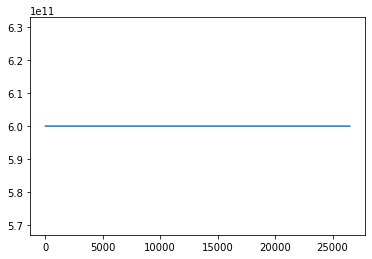

In [10]:
# check for gaps
(df['datetime'] - df['datetime'].shift()).plot()
plt.show()

**Conclusion**

1) There are 26496 orders captured at 10 minute intervals starting from 2018-03-01 to 2018-08-31.

2) There are no duplicates or misisng values

3) The datasets is time ordered and there are no gaps.

4) The mean number of orders is 14, and the ordes range from 0 - 119.

## Preparation and Analysis

#### Create new features

* Add date features (month, day, dayofweek, hour)
* Add rolling mean
* Add rolling median
* Add rolling std

In [11]:
# predictions are required for the next hour
df_hourly = df.copy(deep=True)
df_hourly.set_index('datetime', inplace=True)
df_hourly = df_hourly.resample('1H').sum()

In [12]:
def create_ts_features(df, dt_field, target, max_lag=1, rolling_window=1):
    """
    Create several Timseries features
    """
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(str(lag))] = df[target].shift(lag)
    
    df['rolling_mean'] = df[target].shift().rolling(rolling_window).mean()
    df['rolling_median'] = df[target].shift().rolling(rolling_window).median()
    df['rolling_std'] = df[target].shift().rolling(rolling_window).std()

In [13]:
create_ts_features(df_hourly, 'datetime', 'num_orders', max_lag=7, rolling_window=7)

In [14]:
df_hourly.head(8)

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857,66.0,41.558908


#### Change the dtypes

In [15]:
df_hourly.describe()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4409.000000,4409.000000,4409.000000
mean,84.422781,5.505435,15.836957,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.331108,82.863688,30.913356
std,45.023853,1.713306,8.855229,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,31.807426,32.062825,14.822064
min,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,17.000000,5.814596
25%,54.000000,4.000000,8.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.285714,61.000000,21.037382
50%,78.000000,5.500000,16.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.428571,78.000000,27.944673
75%,107.000000,7.000000,23.250000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.571429,101.000000,37.235416
max,462.000000,8.000000,31.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,254.142857,238.000000,151.400918


In [16]:
# before the change
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   float64
 6   lag_2           4414 non-null   float64
 7   lag_3           4413 non-null   float64
 8   lag_4           4412 non-null   float64
 9   lag_5           4411 non-null   float64
 10  lag_6           4410 non-null   float64
 11  lag_7           4409 non-null   float64
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   float64
 14  rolling_std     4409 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 552.0 KB


In [17]:
cols_to_change = [
                 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
                 'rolling_median'
]
df_hourly[cols_to_change] = df_hourly[cols_to_change].astype('Int16')

In [18]:
# after the change
df_hourly.describe()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_median,rolling_std
count,4416.000000,4416.000000,4416.000000,4416.000000,4416.00000,4415.000000,4414.000000,4413.000000,4412.000000,4411.000000,4410.000000,4409.000000,4409.000000,4409.000000,4409.000000
mean,84.422781,5.505435,15.836957,3.005435,11.50000,84.395470,84.364069,84.347156,84.331369,84.319655,84.291837,84.261737,84.331108,82.863688,30.913356
std,45.023853,1.713306,8.855229,1.990684,6.92297,44.992356,44.949043,44.940088,44.932942,44.931299,44.898387,44.858959,31.807426,32.062825,14.822064
min,0.000000,3.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,17.000000,5.814596
25%,54.000000,4.000000,8.000000,1.000000,5.75000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,62.285714,61.000000,21.037382
50%,78.000000,5.500000,16.000000,3.000000,11.50000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,79.428571,78.000000,27.944673
75%,107.000000,7.000000,23.250000,5.000000,17.25000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,101.571429,101.000000,37.235416
max,462.000000,8.000000,31.000000,6.000000,23.00000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,254.142857,238.000000,151.400918


In [19]:
# after the change
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   month           4416 non-null   int64  
 2   day             4416 non-null   int64  
 3   dayofweek       4416 non-null   int64  
 4   hour            4416 non-null   int64  
 5   lag_1           4415 non-null   Int16  
 6   lag_2           4414 non-null   Int16  
 7   lag_3           4413 non-null   Int16  
 8   lag_4           4412 non-null   Int16  
 9   lag_5           4411 non-null   Int16  
 10  lag_6           4410 non-null   Int16  
 11  lag_7           4409 non-null   Int16  
 12  rolling_mean    4409 non-null   float64
 13  rolling_median  4409 non-null   Int16  
 14  rolling_std     4409 non-null   float64
dtypes: Int16(8), float64(2), int64(5)
memory usage: 379.5 KB


#### Plot time-series orders using different intervals

In [20]:
def plot_orders(dfs, field, r=1, c=1, figsize=(12, 10), is_mean_window=False,
                window=1, titles=[], sup_title=None):
    """
    Plot mean orders based on different time intervals
    """
    fig, axes = plt.subplots(r, c, figsize=figsize)
    if not is_mean_window:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax)
            axes[idx].set_title(title)
    else:
        for idx, (df, title, ax) in enumerate(zip(dfs, titles, axes.flatten())):
            sns.lineplot(df.index, df, ax=ax, label='hourly trend')
            sns.lineplot(df.index, df.shift().rolling(window).mean(), ax=ax, label='mean')
            sns.lineplot(df.index, df.shift().rolling(window).std(), ax=ax, label='std')
            axes[idx].set_title(title)
    axes.flat[-1].set_visible(False) 
    plt.suptitle(sup_title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [21]:
# resample the dataframe on an hourly, daily, and monthly basis
hourly_orders = df.set_index('datetime')['num_orders'].resample('1H').mean()
daily_orders = df.set_index('datetime')['num_orders'].resample('1D').mean()
monthly_orders = df.set_index('datetime')['num_orders'].resample('1M').mean()

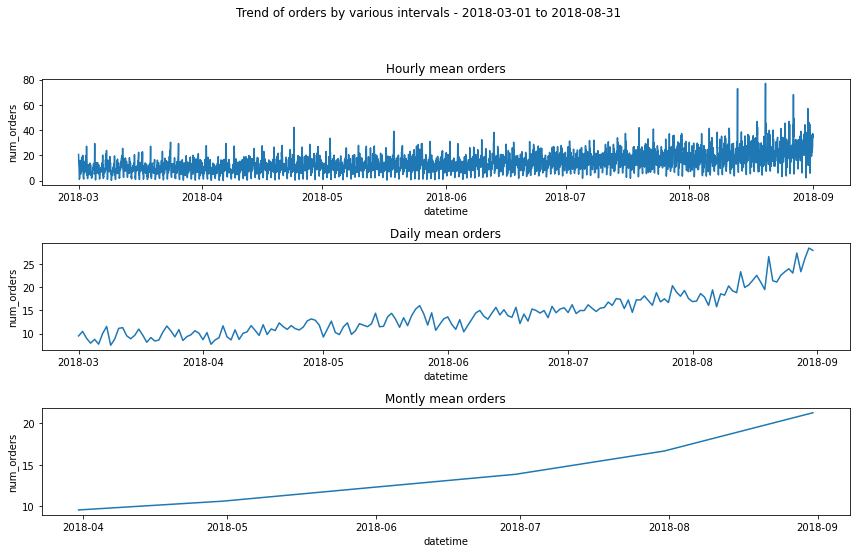

In [22]:
resample_df_list = [hourly_orders, daily_orders, monthly_orders]
titles = ['Hourly mean orders',
         'Daily mean orders',
         'Montly mean orders'
         ]
sup_title = 'Trend of orders by various intervals - 2018-03-01 to 2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=4, c=1, titles=titles, sup_title=sup_title)

1) The overall trend reveals an upward trend in mean orders between 2018-03-01 and 2018-08-31.

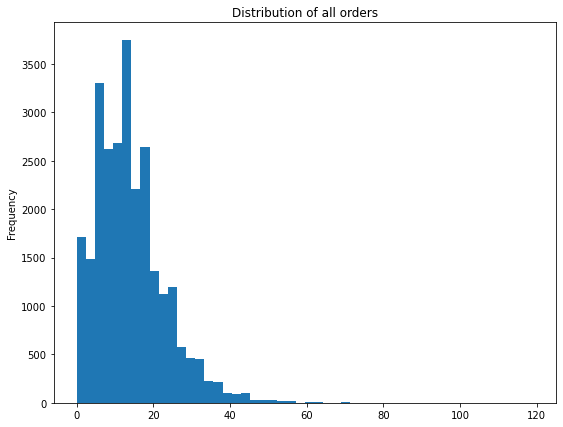

In [23]:
plt.subplots(figsize=(9, 7))
df['num_orders'].plot(kind='hist', bins=50, title='Distribution of all orders')
plt.show()

1) The histogram reveals a right-skewed distribution, which peaks at 9-12 orders.

#### Heatmap of orders by hour of day and day of week

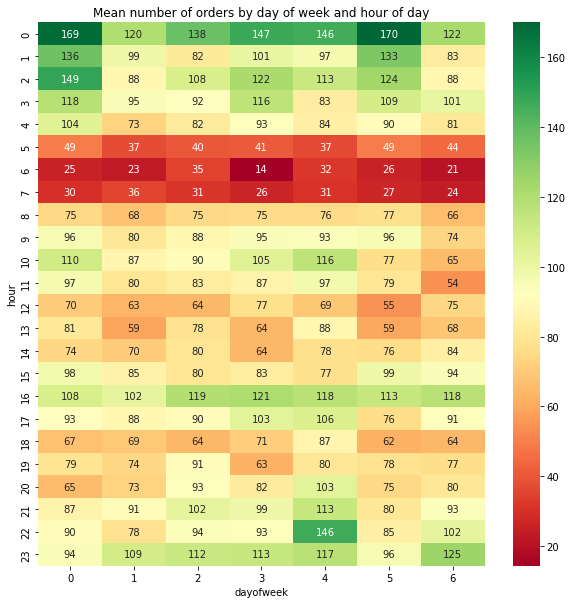

In [24]:
pivoted_df = df_hourly.pivot_table(index=['hour'], columns=['dayofweek'], values=['num_orders'], aggfunc='mean')
pivoted_df = pivoted_df.droplevel(0, axis=1)
plt.figure(figsize=(10, 10))
sns.heatmap(pivoted_df, annot=True, cmap="RdYlGn", fmt=".0f")
plt.title('Mean number of orders by day of week and hour of day')
plt.show()

1) Between 5AM -7 AM, the mean order of requests drops, and this pattern is observed throughout the week.

2) 12AM sees a higher than average number of orders compared to any other hour during any given week.

3) Between 8AM - 8PM, the number of rides is around the mean of 15.

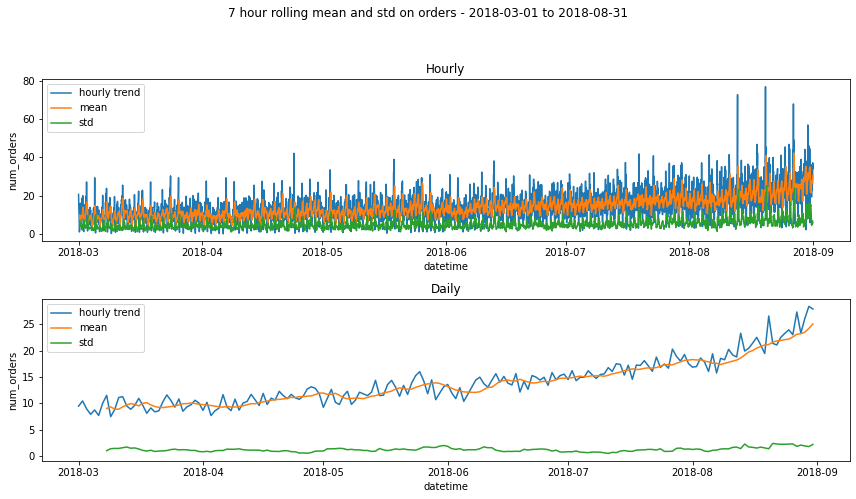

In [25]:
resample_df_list = [hourly_orders, daily_orders]
titles = [
         'Hourly',
         'Daily'
         ]
window = 7
sup_title = f'{window} hour rolling mean and std on orders - 2018-03-01 to 2018-08-31'
plot_orders(resample_df_list, 'num_orders', r=3, c=1, is_mean_window=True, window=window, 
            titles=titles, sup_title=sup_title)

1) The hourly data appears noisy, and the 7 hour mean, and std are noisy. However, in the daily orders, the std appears
constant, and the mean is relatively smoother.

#### Decompose the timeseries components

In [26]:
df_hourly = df_hourly.dropna()

In [27]:
df_hourly.shape

(4409, 15)

In [71]:
decomposed_trend    = df_hourly.apply(lambda x: seasonal_decompose(x).trend)
decomposed_resid    = df_hourly.apply(lambda x: seasonal_decompose(x).resid)
decomposed_seasonal = df_hourly.apply(lambda x: seasonal_decompose(x).seasonal)

decomposed_trend    = decomposed_trend[['num_orders', 'rolling_mean', 'rolling_std']]
decomposed_resid    = decomposed_resid[['num_orders', 'rolling_mean', 'rolling_std']]
decomposed_seasonal = decomposed_seasonal[['num_orders', 'rolling_mean', 'rolling_std']]

In [72]:
decomposed.trend.plot(figsize=(12, 9), title='Trend analysis of hourly orders')
decomposed.seasonal.tail(24*7).plot(figsize=(12, 9), title="Seasonal analysis of last 7 days' hourly orders")
decomposed.resid.plot(figsize=(12, 9), title="Residual plot of hourly orders")
decomposed.seasonal['2018-08-01': '2018-08-02'].plot(figsize=(12, 9), title="Seasonal analysis 1 day' hourly orders")
plt.show()

NameError: name 'decomposed' is not defined

1) The trend plot shows an upward trend.

2) The seasonal trend for last 7 days shows that there is a daily seasonal pattern in ridership.

3) The residuals shows that the residual mean is not 0, which indicates that there could be a bias in the predictions. The spikes in August clearly indicate that the company was peaking with respect to ridership frequency.

4) The seasonal analysis for 1 day shows that ridership frequency increases at midnight, drops to its lowest at 6AM, and then
rises moderately around 5PM.

## Training

In [37]:
def rmse(y_true, y_pred):
    """
    Make scorer to compute rmse
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [38]:
def build_model(model, train_X, train_y, test_X, test_y, 
                hyperparameters={}, 
                scoring=None, cv=5, model_str=None, cat_features=[], verbose=False):
    """
    Build model
    """
    np.random.seed(42)
    best_rmse = 0
    start_time = time.time()
    
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X, train_y)
    if model_str == 'catboost':
        gs.best_estimator_.fit(train_X, train_y, cat_features=cat_features, verbose=verbose)
    else:
        gs.best_estimator_.fit(train_X, train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_rmse = rmse(test_y, preds)
    end_time = time.time() - start_time
    return gs.best_estimator_, best_rmse, np.round(end_time, 2)

In [39]:
# split the dataframe
train_X, test_X, train_y, test_y = train_test_split(df_hourly.drop(['num_orders'], axis=1), 
                                              df_hourly['num_orders'], 
                                              test_size=0.2,
                                              random_state=42, shuffle=False)

In [40]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((3527, 14), (882, 14), (3527,), (882,))

In [55]:
from sklearn.preprocessing import StandardScaler as ss

train_X = pd.DataFrame(ss().fit_transform(train_X), columns=train_X.columns, index=train_X.index)
test_X = pd.DataFrame(ss().fit_transform(test_X), columns=test_X.columns, index=test_X.index)

In [56]:
tscv = TimeSeriesSplit(n_splits=5)

In [57]:
lr = LinearRegression()
best_lr_model, best_lr_rmse, best_lr_time = build_model(lr, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={}, 
                scoring=make_scorer(rmse), cv=tscv)

In [58]:
rf = RandomForestRegressor(random_state=42)
best_rf_model, best_rf_rmse, best_rf_time = build_model(rf, train_X, train_y, 
                                                        test_X, test_y,
                                                        hyperparameters={'n_estimators': range(100, 600, 100),
                                                                        'max_depth': range(5, 10)
                                                                        }, 
                scoring=make_scorer(rmse), cv=tscv)

In [59]:
# cat_features = ['month', 'hour', 'day', 'dayofweek']
cat_features = []
cat = CatBoostRegressor(learning_rate=0.1, loss_function='RMSE',
                        random_seed=42)
best_cb_model, best_cb_rmse, best_cb_time = build_model(cat, train_X.values, train_y.values, 
                                                        test_X.values, test_y.values,
                                                        hyperparameters={'iterations': range(100, 600, 100),
                                                                        'depth': range(5, 10)}, 
                scoring=make_scorer(rmse), cv=tscv, model_str='catboost',
           cat_features=cat_features)

0:	learn: 28.1671839	total: 15ms	remaining: 1.48s
1:	learn: 26.8663699	total: 16.9ms	remaining: 827ms
2:	learn: 26.2444481	total: 17.8ms	remaining: 575ms
3:	learn: 25.0861485	total: 18.6ms	remaining: 445ms
4:	learn: 24.3981393	total: 19.3ms	remaining: 366ms
5:	learn: 23.7346980	total: 19.9ms	remaining: 312ms
6:	learn: 22.9945552	total: 20.8ms	remaining: 276ms
7:	learn: 22.3026165	total: 21.9ms	remaining: 251ms
8:	learn: 21.5301371	total: 23.5ms	remaining: 237ms
9:	learn: 20.8937836	total: 24.4ms	remaining: 220ms
10:	learn: 20.4174489	total: 25.3ms	remaining: 204ms
11:	learn: 19.9889727	total: 26.2ms	remaining: 192ms
12:	learn: 19.6914336	total: 27.1ms	remaining: 181ms
13:	learn: 19.3357131	total: 27.9ms	remaining: 172ms
14:	learn: 19.0968660	total: 29ms	remaining: 165ms
15:	learn: 18.8685419	total: 29.9ms	remaining: 157ms
16:	learn: 18.5908615	total: 30.7ms	remaining: 150ms
17:	learn: 18.3957632	total: 31.7ms	remaining: 144ms
18:	learn: 18.1719507	total: 32.5ms	remaining: 139ms
19:	lea

37:	learn: 19.3138101	total: 52ms	remaining: 84.8ms
38:	learn: 19.2401411	total: 54.1ms	remaining: 84.7ms
39:	learn: 19.2001954	total: 56.1ms	remaining: 84.1ms
40:	learn: 19.0759301	total: 59.4ms	remaining: 85.5ms
41:	learn: 19.0372239	total: 60.7ms	remaining: 83.8ms
42:	learn: 18.9641031	total: 62ms	remaining: 82.2ms
43:	learn: 18.8837501	total: 63.3ms	remaining: 80.5ms
44:	learn: 18.8023905	total: 66.8ms	remaining: 81.7ms
45:	learn: 18.7245973	total: 69.7ms	remaining: 81.9ms
46:	learn: 18.6863413	total: 71.1ms	remaining: 80.2ms
47:	learn: 18.6516528	total: 72.3ms	remaining: 78.3ms
48:	learn: 18.6202073	total: 73.2ms	remaining: 76.2ms
49:	learn: 18.5849546	total: 74.1ms	remaining: 74.1ms
50:	learn: 18.5468865	total: 76.9ms	remaining: 73.9ms
51:	learn: 18.4991575	total: 80ms	remaining: 73.8ms
52:	learn: 18.4614139	total: 82.6ms	remaining: 73.3ms
53:	learn: 18.4205937	total: 83.9ms	remaining: 71.5ms
54:	learn: 18.3420229	total: 85ms	remaining: 69.6ms
55:	learn: 18.2797053	total: 86.6ms	

1:	learn: 31.0051023	total: 6.8ms	remaining: 333ms
2:	learn: 29.9164695	total: 14.1ms	remaining: 456ms
3:	learn: 28.9896359	total: 15.9ms	remaining: 382ms
4:	learn: 28.2809778	total: 18.6ms	remaining: 353ms
5:	learn: 27.5759861	total: 21.5ms	remaining: 338ms
6:	learn: 26.9267492	total: 24ms	remaining: 319ms
7:	learn: 26.4562142	total: 25.2ms	remaining: 290ms
8:	learn: 25.8871757	total: 26.8ms	remaining: 271ms
9:	learn: 25.5938646	total: 28ms	remaining: 252ms
10:	learn: 25.1007827	total: 29.6ms	remaining: 240ms
11:	learn: 24.8456594	total: 30.9ms	remaining: 227ms
12:	learn: 24.4413466	total: 32.9ms	remaining: 220ms
13:	learn: 24.2180307	total: 34.7ms	remaining: 213ms
14:	learn: 23.9466186	total: 39.3ms	remaining: 222ms
15:	learn: 23.7759121	total: 41.7ms	remaining: 219ms
16:	learn: 23.4666194	total: 43.7ms	remaining: 213ms
17:	learn: 23.2819739	total: 45.7ms	remaining: 208ms
18:	learn: 23.1489403	total: 50.1ms	remaining: 214ms
19:	learn: 22.9584690	total: 51.9ms	remaining: 208ms
20:	lea

131:	learn: 10.8160738	total: 126ms	remaining: 65.1ms
132:	learn: 10.7511366	total: 127ms	remaining: 64.1ms
133:	learn: 10.7189327	total: 128ms	remaining: 63.2ms
134:	learn: 10.6799382	total: 130ms	remaining: 62.5ms
135:	learn: 10.6651146	total: 131ms	remaining: 61.6ms
136:	learn: 10.6075410	total: 132ms	remaining: 60.9ms
137:	learn: 10.5431124	total: 134ms	remaining: 60ms
138:	learn: 10.5397649	total: 135ms	remaining: 59ms
139:	learn: 10.5191073	total: 136ms	remaining: 58.1ms
140:	learn: 10.5069866	total: 136ms	remaining: 57.1ms
141:	learn: 10.4747954	total: 147ms	remaining: 60.2ms
142:	learn: 10.4414859	total: 149ms	remaining: 59.2ms
143:	learn: 10.3997474	total: 150ms	remaining: 58.3ms
144:	learn: 10.3733813	total: 152ms	remaining: 57.7ms
145:	learn: 10.3712684	total: 154ms	remaining: 57.1ms
146:	learn: 10.3325409	total: 156ms	remaining: 56.3ms
147:	learn: 10.2825201	total: 158ms	remaining: 55.4ms
148:	learn: 10.2411931	total: 159ms	remaining: 54.3ms
149:	learn: 10.2014023	total: 16

9:	learn: 23.7079522	total: 11.5ms	remaining: 218ms
10:	learn: 23.2778438	total: 12.8ms	remaining: 221ms
11:	learn: 23.0739884	total: 14ms	remaining: 219ms
12:	learn: 22.7631294	total: 15.8ms	remaining: 228ms
13:	learn: 22.4900208	total: 17.4ms	remaining: 231ms
14:	learn: 22.2383525	total: 19.2ms	remaining: 236ms
15:	learn: 21.9571636	total: 20.8ms	remaining: 240ms
16:	learn: 21.7423190	total: 23.1ms	remaining: 248ms
17:	learn: 21.5636205	total: 25.6ms	remaining: 259ms
18:	learn: 21.4213786	total: 27.8ms	remaining: 265ms
19:	learn: 21.2695653	total: 29.5ms	remaining: 266ms
20:	learn: 21.0850465	total: 31.9ms	remaining: 272ms
21:	learn: 20.9003313	total: 33.6ms	remaining: 272ms
22:	learn: 20.7377050	total: 36ms	remaining: 277ms
23:	learn: 20.6564148	total: 38.5ms	remaining: 282ms
24:	learn: 20.5504433	total: 40.4ms	remaining: 283ms
25:	learn: 20.3962028	total: 42.5ms	remaining: 285ms
26:	learn: 20.2861671	total: 45ms	remaining: 288ms
27:	learn: 20.1620786	total: 46.6ms	remaining: 286ms


33:	learn: 21.0528769	total: 45.1ms	remaining: 220ms
34:	learn: 20.9298933	total: 46.7ms	remaining: 220ms
35:	learn: 20.8179866	total: 47.9ms	remaining: 218ms
36:	learn: 20.7173307	total: 49.1ms	remaining: 216ms
37:	learn: 20.6547985	total: 50.3ms	remaining: 214ms
38:	learn: 20.5771080	total: 51.6ms	remaining: 213ms
39:	learn: 20.4749829	total: 53ms	remaining: 212ms
40:	learn: 20.4356350	total: 55ms	remaining: 213ms
41:	learn: 20.3476497	total: 57.3ms	remaining: 216ms
42:	learn: 20.2842219	total: 58.7ms	remaining: 214ms
43:	learn: 20.2083597	total: 61ms	remaining: 216ms
44:	learn: 20.1703421	total: 63.4ms	remaining: 218ms
45:	learn: 20.1018707	total: 65.9ms	remaining: 221ms
46:	learn: 20.0161221	total: 67.4ms	remaining: 220ms
47:	learn: 19.9864359	total: 68.8ms	remaining: 218ms
48:	learn: 19.9166011	total: 71.3ms	remaining: 220ms
49:	learn: 19.8984491	total: 73.8ms	remaining: 221ms
50:	learn: 19.8322417	total: 76ms	remaining: 222ms
51:	learn: 19.8026632	total: 78.5ms	remaining: 223ms
5

119:	learn: 18.0783450	total: 121ms	remaining: 80.8ms
120:	learn: 18.0450351	total: 123ms	remaining: 80ms
121:	learn: 18.0320057	total: 124ms	remaining: 79.2ms
122:	learn: 18.0193794	total: 125ms	remaining: 78.3ms
123:	learn: 17.9898325	total: 128ms	remaining: 78.7ms
124:	learn: 17.9509425	total: 130ms	remaining: 78.3ms
125:	learn: 17.9291071	total: 132ms	remaining: 77.5ms
126:	learn: 17.9178084	total: 134ms	remaining: 77.2ms
127:	learn: 17.9103926	total: 136ms	remaining: 76.4ms
128:	learn: 17.8819799	total: 139ms	remaining: 76.4ms
129:	learn: 17.8681539	total: 140ms	remaining: 75.6ms
130:	learn: 17.8087702	total: 142ms	remaining: 74.8ms
131:	learn: 17.7897170	total: 145ms	remaining: 74.5ms
132:	learn: 17.7699350	total: 149ms	remaining: 75.1ms
133:	learn: 17.7416159	total: 155ms	remaining: 76.4ms
134:	learn: 17.7302094	total: 156ms	remaining: 75.2ms
135:	learn: 17.6909221	total: 157ms	remaining: 73.9ms
136:	learn: 17.6558512	total: 158ms	remaining: 72.7ms
137:	learn: 17.6500438	total: 

232:	learn: 7.8338976	total: 188ms	remaining: 54.1ms
233:	learn: 7.8208541	total: 189ms	remaining: 53.4ms
234:	learn: 7.7734802	total: 193ms	remaining: 53.4ms
235:	learn: 7.7588917	total: 195ms	remaining: 53ms
236:	learn: 7.7153972	total: 199ms	remaining: 52.8ms
237:	learn: 7.6999043	total: 200ms	remaining: 52.1ms
238:	learn: 7.6581744	total: 201ms	remaining: 51.3ms
239:	learn: 7.6424582	total: 202ms	remaining: 50.6ms
240:	learn: 7.5932987	total: 204ms	remaining: 49.9ms
241:	learn: 7.5637724	total: 206ms	remaining: 49.5ms
242:	learn: 7.5312018	total: 208ms	remaining: 48.7ms
243:	learn: 7.4765739	total: 209ms	remaining: 47.9ms
244:	learn: 7.4533186	total: 211ms	remaining: 47.3ms
245:	learn: 7.4303950	total: 214ms	remaining: 46.9ms
246:	learn: 7.3971279	total: 216ms	remaining: 46.3ms
247:	learn: 7.3613356	total: 217ms	remaining: 45.5ms
248:	learn: 7.3598022	total: 221ms	remaining: 45.4ms
249:	learn: 7.3225706	total: 222ms	remaining: 44.5ms
250:	learn: 7.3035477	total: 223ms	remaining: 43

202:	learn: 11.6172747	total: 184ms	remaining: 88.1ms
203:	learn: 11.5847082	total: 189ms	remaining: 88.8ms
204:	learn: 11.5725475	total: 193ms	remaining: 89.4ms
205:	learn: 11.5475263	total: 199ms	remaining: 90.9ms
206:	learn: 11.5422867	total: 202ms	remaining: 90.5ms
207:	learn: 11.4994617	total: 203ms	remaining: 89.9ms
208:	learn: 11.4669287	total: 206ms	remaining: 89.8ms
209:	learn: 11.4430249	total: 208ms	remaining: 89.3ms
210:	learn: 11.4251333	total: 210ms	remaining: 88.7ms
211:	learn: 11.3880776	total: 212ms	remaining: 88.1ms
212:	learn: 11.3708946	total: 215ms	remaining: 87.7ms
213:	learn: 11.3539881	total: 216ms	remaining: 86.8ms
214:	learn: 11.3445121	total: 217ms	remaining: 85.8ms
215:	learn: 11.3223607	total: 218ms	remaining: 84.8ms
216:	learn: 11.2966467	total: 219ms	remaining: 83.8ms
217:	learn: 11.2760202	total: 221ms	remaining: 83ms
218:	learn: 11.2411285	total: 222ms	remaining: 82ms
219:	learn: 11.2012884	total: 225ms	remaining: 81.7ms
220:	learn: 11.1819245	total: 22

63:	learn: 18.0036922	total: 186ms	remaining: 685ms
64:	learn: 17.9664210	total: 187ms	remaining: 676ms
65:	learn: 17.8584617	total: 188ms	remaining: 668ms
66:	learn: 17.8340290	total: 190ms	remaining: 659ms
67:	learn: 17.7944850	total: 191ms	remaining: 651ms
68:	learn: 17.7483898	total: 193ms	remaining: 646ms
69:	learn: 17.7095962	total: 194ms	remaining: 638ms
70:	learn: 17.6849214	total: 196ms	remaining: 631ms
71:	learn: 17.6567972	total: 198ms	remaining: 628ms
72:	learn: 17.6192519	total: 200ms	remaining: 622ms
73:	learn: 17.5493556	total: 201ms	remaining: 614ms
74:	learn: 17.5092939	total: 202ms	remaining: 607ms
75:	learn: 17.4670248	total: 203ms	remaining: 600ms
76:	learn: 17.4382313	total: 205ms	remaining: 592ms
77:	learn: 17.3858903	total: 206ms	remaining: 585ms
78:	learn: 17.3645997	total: 207ms	remaining: 579ms
79:	learn: 17.3258815	total: 208ms	remaining: 573ms
80:	learn: 17.2805010	total: 210ms	remaining: 567ms
81:	learn: 17.2585776	total: 211ms	remaining: 561ms
82:	learn: 1

227:	learn: 13.0835259	total: 359ms	remaining: 113ms
228:	learn: 13.0571721	total: 361ms	remaining: 112ms
229:	learn: 13.0371904	total: 362ms	remaining: 110ms
230:	learn: 13.0224801	total: 364ms	remaining: 109ms
231:	learn: 12.9791313	total: 366ms	remaining: 107ms
232:	learn: 12.9464709	total: 368ms	remaining: 106ms
233:	learn: 12.9252190	total: 370ms	remaining: 104ms
234:	learn: 12.8915985	total: 372ms	remaining: 103ms
235:	learn: 12.8594540	total: 373ms	remaining: 101ms
236:	learn: 12.8312095	total: 374ms	remaining: 99.5ms
237:	learn: 12.8165051	total: 376ms	remaining: 98ms
238:	learn: 12.8023039	total: 378ms	remaining: 96.4ms
239:	learn: 12.7806864	total: 380ms	remaining: 95.1ms
240:	learn: 12.7602626	total: 381ms	remaining: 93.4ms
241:	learn: 12.7320758	total: 383ms	remaining: 91.7ms
242:	learn: 12.7067126	total: 385ms	remaining: 90.4ms
243:	learn: 12.6917068	total: 386ms	remaining: 88.7ms
244:	learn: 12.6673454	total: 387ms	remaining: 86.9ms
245:	learn: 12.6495125	total: 388ms	rem

122:	learn: 16.9727736	total: 253ms	remaining: 364ms
123:	learn: 16.9346049	total: 257ms	remaining: 365ms
124:	learn: 16.8890799	total: 259ms	remaining: 363ms
125:	learn: 16.8773326	total: 261ms	remaining: 360ms
126:	learn: 16.8675271	total: 263ms	remaining: 359ms
127:	learn: 16.8296664	total: 265ms	remaining: 356ms
128:	learn: 16.7998654	total: 267ms	remaining: 354ms
129:	learn: 16.7795759	total: 270ms	remaining: 353ms
130:	learn: 16.7576380	total: 271ms	remaining: 350ms
131:	learn: 16.7287942	total: 273ms	remaining: 348ms
132:	learn: 16.6986628	total: 275ms	remaining: 346ms
133:	learn: 16.6590797	total: 278ms	remaining: 344ms
134:	learn: 16.6324672	total: 280ms	remaining: 342ms
135:	learn: 16.5995929	total: 283ms	remaining: 341ms
136:	learn: 16.5611499	total: 284ms	remaining: 338ms
137:	learn: 16.5439227	total: 285ms	remaining: 335ms
138:	learn: 16.4725884	total: 287ms	remaining: 332ms
139:	learn: 16.4629653	total: 289ms	remaining: 330ms
140:	learn: 16.4339383	total: 292ms	remaining:

65:	learn: 19.8081415	total: 72.6ms	remaining: 258ms
66:	learn: 19.7821720	total: 74.2ms	remaining: 258ms
67:	learn: 19.7369046	total: 75.7ms	remaining: 258ms
68:	learn: 19.7036368	total: 78.3ms	remaining: 262ms
69:	learn: 19.6854671	total: 79.7ms	remaining: 262ms
70:	learn: 19.6302043	total: 81.1ms	remaining: 262ms
71:	learn: 19.6096904	total: 82.6ms	remaining: 262ms
72:	learn: 19.5847952	total: 84.9ms	remaining: 264ms
73:	learn: 19.5516466	total: 86.5ms	remaining: 264ms
74:	learn: 19.5071478	total: 88.2ms	remaining: 265ms
75:	learn: 19.4821747	total: 89.8ms	remaining: 265ms
76:	learn: 19.4513188	total: 91.7ms	remaining: 266ms
77:	learn: 19.3849673	total: 93.1ms	remaining: 265ms
78:	learn: 19.3191537	total: 94.4ms	remaining: 264ms
79:	learn: 19.2505060	total: 96.3ms	remaining: 265ms
80:	learn: 19.2380539	total: 98ms	remaining: 265ms
81:	learn: 19.1884926	total: 99.4ms	remaining: 264ms
82:	learn: 19.1510399	total: 101ms	remaining: 264ms
83:	learn: 19.1408481	total: 103ms	remaining: 264

294:	learn: 14.7310846	total: 422ms	remaining: 7.15ms
295:	learn: 14.7128901	total: 428ms	remaining: 5.78ms
296:	learn: 14.7098589	total: 430ms	remaining: 4.34ms
297:	learn: 14.7093773	total: 431ms	remaining: 2.89ms
298:	learn: 14.6905413	total: 433ms	remaining: 1.45ms
299:	learn: 14.6785789	total: 444ms	remaining: 0us
0:	learn: 28.1671839	total: 1.21ms	remaining: 481ms
1:	learn: 26.8663699	total: 10.9ms	remaining: 2.16s
2:	learn: 26.2444481	total: 12ms	remaining: 1.59s
3:	learn: 25.0861485	total: 13.4ms	remaining: 1.32s
4:	learn: 24.3981393	total: 14.3ms	remaining: 1.13s
5:	learn: 23.7346980	total: 15.8ms	remaining: 1.04s
6:	learn: 22.9945552	total: 16.8ms	remaining: 945ms
7:	learn: 22.3026165	total: 20.4ms	remaining: 999ms
8:	learn: 21.5301371	total: 22.7ms	remaining: 987ms
9:	learn: 20.8937836	total: 24.7ms	remaining: 964ms
10:	learn: 20.4174489	total: 25.6ms	remaining: 906ms
11:	learn: 19.9889727	total: 26.5ms	remaining: 856ms
12:	learn: 19.6914336	total: 27.3ms	remaining: 812ms
13

289:	learn: 6.4488401	total: 478ms	remaining: 181ms
290:	learn: 6.4352137	total: 479ms	remaining: 179ms
291:	learn: 6.4241657	total: 480ms	remaining: 177ms
292:	learn: 6.3951594	total: 481ms	remaining: 176ms
293:	learn: 6.3669993	total: 482ms	remaining: 174ms
294:	learn: 6.3452642	total: 482ms	remaining: 172ms
295:	learn: 6.3185223	total: 483ms	remaining: 170ms
296:	learn: 6.3012244	total: 484ms	remaining: 168ms
297:	learn: 6.2817472	total: 485ms	remaining: 166ms
298:	learn: 6.2461988	total: 486ms	remaining: 164ms
299:	learn: 6.2200378	total: 487ms	remaining: 162ms
300:	learn: 6.1862579	total: 488ms	remaining: 161ms
301:	learn: 6.1707668	total: 489ms	remaining: 159ms
302:	learn: 6.1446114	total: 490ms	remaining: 157ms
303:	learn: 6.1178917	total: 491ms	remaining: 155ms
304:	learn: 6.1068268	total: 492ms	remaining: 153ms
305:	learn: 6.0937222	total: 493ms	remaining: 151ms
306:	learn: 6.0734666	total: 494ms	remaining: 150ms
307:	learn: 6.0640820	total: 495ms	remaining: 148ms
308:	learn: 

59:	learn: 16.5339838	total: 52.1ms	remaining: 295ms
60:	learn: 16.4965235	total: 54ms	remaining: 300ms
61:	learn: 16.4097889	total: 55.1ms	remaining: 300ms
62:	learn: 16.3643173	total: 56.2ms	remaining: 301ms
63:	learn: 16.3426979	total: 57.3ms	remaining: 301ms
64:	learn: 16.3064797	total: 58.4ms	remaining: 301ms
65:	learn: 16.2616722	total: 59.6ms	remaining: 302ms
66:	learn: 16.2204311	total: 60.6ms	remaining: 301ms
67:	learn: 16.1999698	total: 61.8ms	remaining: 302ms
68:	learn: 16.1470099	total: 62.8ms	remaining: 301ms
69:	learn: 16.0947196	total: 64.1ms	remaining: 302ms
70:	learn: 16.0451220	total: 65.4ms	remaining: 303ms
71:	learn: 16.0062011	total: 66.5ms	remaining: 303ms
72:	learn: 15.9838797	total: 68.1ms	remaining: 305ms
73:	learn: 15.9549724	total: 69.2ms	remaining: 305ms
74:	learn: 15.9295837	total: 72ms	remaining: 312ms
75:	learn: 15.8760267	total: 73ms	remaining: 311ms
76:	learn: 15.8500042	total: 75.1ms	remaining: 315ms
77:	learn: 15.8308028	total: 76.4ms	remaining: 316ms

243:	learn: 10.6933502	total: 225ms	remaining: 144ms
244:	learn: 10.6673760	total: 226ms	remaining: 143ms
245:	learn: 10.6451407	total: 227ms	remaining: 142ms
246:	learn: 10.6096830	total: 228ms	remaining: 141ms
247:	learn: 10.5896619	total: 230ms	remaining: 141ms
248:	learn: 10.5608067	total: 231ms	remaining: 140ms
249:	learn: 10.5230791	total: 233ms	remaining: 140ms
250:	learn: 10.4960199	total: 234ms	remaining: 139ms
251:	learn: 10.4588400	total: 235ms	remaining: 138ms
252:	learn: 10.4462090	total: 236ms	remaining: 137ms
253:	learn: 10.4340795	total: 238ms	remaining: 137ms
254:	learn: 10.4111743	total: 239ms	remaining: 136ms
255:	learn: 10.4033521	total: 241ms	remaining: 135ms
256:	learn: 10.3634346	total: 245ms	remaining: 136ms
257:	learn: 10.3549016	total: 247ms	remaining: 136ms
258:	learn: 10.3498884	total: 248ms	remaining: 135ms
259:	learn: 10.3181732	total: 249ms	remaining: 134ms
260:	learn: 10.3016925	total: 252ms	remaining: 134ms
261:	learn: 10.2947039	total: 254ms	remaining:

55:	learn: 18.2797053	total: 126ms	remaining: 775ms
56:	learn: 18.2602503	total: 129ms	remaining: 775ms
57:	learn: 18.2121045	total: 130ms	remaining: 766ms
58:	learn: 18.1850488	total: 133ms	remaining: 767ms
59:	learn: 18.1340188	total: 134ms	remaining: 759ms
60:	learn: 18.1100035	total: 135ms	remaining: 751ms
61:	learn: 18.0679377	total: 137ms	remaining: 745ms
62:	learn: 18.0406130	total: 138ms	remaining: 739ms
63:	learn: 18.0036922	total: 139ms	remaining: 732ms
64:	learn: 17.9664210	total: 141ms	remaining: 724ms
65:	learn: 17.8584617	total: 143ms	remaining: 721ms
66:	learn: 17.8340290	total: 145ms	remaining: 721ms
67:	learn: 17.7944850	total: 151ms	remaining: 737ms
68:	learn: 17.7483898	total: 152ms	remaining: 730ms
69:	learn: 17.7095962	total: 153ms	remaining: 722ms
70:	learn: 17.6849214	total: 155ms	remaining: 719ms
71:	learn: 17.6567972	total: 157ms	remaining: 716ms
72:	learn: 17.6192519	total: 160ms	remaining: 717ms
73:	learn: 17.5493556	total: 161ms	remaining: 711ms
74:	learn: 1

284:	learn: 11.9961075	total: 473ms	remaining: 191ms
285:	learn: 11.9695736	total: 475ms	remaining: 189ms
286:	learn: 11.9569199	total: 476ms	remaining: 188ms
287:	learn: 11.9386300	total: 478ms	remaining: 186ms
288:	learn: 11.9036571	total: 479ms	remaining: 184ms
289:	learn: 11.8886090	total: 481ms	remaining: 183ms
290:	learn: 11.8866089	total: 482ms	remaining: 181ms
291:	learn: 11.8693026	total: 484ms	remaining: 179ms
292:	learn: 11.8583413	total: 485ms	remaining: 177ms
293:	learn: 11.8298077	total: 486ms	remaining: 175ms
294:	learn: 11.8021312	total: 488ms	remaining: 174ms
295:	learn: 11.7850772	total: 490ms	remaining: 172ms
296:	learn: 11.7685373	total: 491ms	remaining: 170ms
297:	learn: 11.7506090	total: 493ms	remaining: 169ms
298:	learn: 11.7374400	total: 496ms	remaining: 167ms
299:	learn: 11.7195033	total: 497ms	remaining: 166ms
300:	learn: 11.7044402	total: 498ms	remaining: 164ms
301:	learn: 11.6867644	total: 500ms	remaining: 162ms
302:	learn: 11.6734091	total: 501ms	remaining:

60:	learn: 19.3920628	total: 197ms	remaining: 1.1s
61:	learn: 19.2881942	total: 202ms	remaining: 1.1s
62:	learn: 19.2646083	total: 206ms	remaining: 1.1s
63:	learn: 19.2228708	total: 208ms	remaining: 1.09s
64:	learn: 19.2121080	total: 209ms	remaining: 1.08s
65:	learn: 19.0654043	total: 211ms	remaining: 1.06s
66:	learn: 19.0243054	total: 213ms	remaining: 1.06s
67:	learn: 18.9783147	total: 215ms	remaining: 1.05s
68:	learn: 18.9497640	total: 228ms	remaining: 1.09s
69:	learn: 18.9279306	total: 231ms	remaining: 1.09s
70:	learn: 18.9048437	total: 234ms	remaining: 1.08s
71:	learn: 18.8829977	total: 238ms	remaining: 1.08s
72:	learn: 18.8257564	total: 241ms	remaining: 1.08s
73:	learn: 18.8193796	total: 246ms	remaining: 1.08s
74:	learn: 18.7829063	total: 248ms	remaining: 1.08s
75:	learn: 18.7223847	total: 252ms	remaining: 1.07s
76:	learn: 18.6912155	total: 254ms	remaining: 1.06s
77:	learn: 18.6109722	total: 255ms	remaining: 1.05s
78:	learn: 18.5388592	total: 257ms	remaining: 1.04s
79:	learn: 18.4

250:	learn: 13.8455359	total: 533ms	remaining: 316ms
251:	learn: 13.8225096	total: 534ms	remaining: 314ms
252:	learn: 13.8013234	total: 536ms	remaining: 311ms
253:	learn: 13.7835244	total: 537ms	remaining: 309ms
254:	learn: 13.7595063	total: 539ms	remaining: 307ms
255:	learn: 13.7354105	total: 541ms	remaining: 305ms
256:	learn: 13.7023703	total: 544ms	remaining: 303ms
257:	learn: 13.6853502	total: 546ms	remaining: 300ms
258:	learn: 13.6781974	total: 547ms	remaining: 298ms
259:	learn: 13.6762285	total: 548ms	remaining: 295ms
260:	learn: 13.6603158	total: 550ms	remaining: 293ms
261:	learn: 13.6592663	total: 551ms	remaining: 290ms
262:	learn: 13.6404410	total: 553ms	remaining: 288ms
263:	learn: 13.6110184	total: 555ms	remaining: 286ms
264:	learn: 13.5966303	total: 557ms	remaining: 284ms
265:	learn: 13.5861492	total: 558ms	remaining: 281ms
266:	learn: 13.5670694	total: 560ms	remaining: 279ms
267:	learn: 13.5545729	total: 561ms	remaining: 276ms
268:	learn: 13.5495014	total: 562ms	remaining:

103:	learn: 18.5225532	total: 139ms	remaining: 396ms
104:	learn: 18.4760823	total: 140ms	remaining: 395ms
105:	learn: 18.4503066	total: 150ms	remaining: 417ms
106:	learn: 18.4396563	total: 152ms	remaining: 415ms
107:	learn: 18.4150571	total: 154ms	remaining: 416ms
108:	learn: 18.4052984	total: 156ms	remaining: 416ms
109:	learn: 18.3860709	total: 157ms	remaining: 414ms
110:	learn: 18.3498546	total: 170ms	remaining: 443ms
111:	learn: 18.3295003	total: 172ms	remaining: 441ms
112:	learn: 18.2930493	total: 173ms	remaining: 440ms
113:	learn: 18.2647026	total: 176ms	remaining: 440ms
114:	learn: 18.2414203	total: 186ms	remaining: 460ms
115:	learn: 18.1882382	total: 187ms	remaining: 458ms
116:	learn: 18.1598279	total: 189ms	remaining: 457ms
117:	learn: 18.1183732	total: 199ms	remaining: 475ms
118:	learn: 18.0993854	total: 199ms	remaining: 471ms
119:	learn: 18.0783450	total: 201ms	remaining: 469ms
120:	learn: 18.0450351	total: 202ms	remaining: 467ms
121:	learn: 18.0320057	total: 204ms	remaining:

291:	learn: 14.7691254	total: 484ms	remaining: 179ms
292:	learn: 14.7565473	total: 485ms	remaining: 177ms
293:	learn: 14.7466843	total: 487ms	remaining: 176ms
294:	learn: 14.7310846	total: 489ms	remaining: 174ms
295:	learn: 14.7128901	total: 491ms	remaining: 172ms
296:	learn: 14.7098589	total: 492ms	remaining: 171ms
297:	learn: 14.7093773	total: 494ms	remaining: 169ms
298:	learn: 14.6905413	total: 497ms	remaining: 168ms
299:	learn: 14.6785789	total: 499ms	remaining: 166ms
300:	learn: 14.6609912	total: 501ms	remaining: 165ms
301:	learn: 14.6389901	total: 503ms	remaining: 163ms
302:	learn: 14.6246502	total: 505ms	remaining: 162ms
303:	learn: 14.6060613	total: 506ms	remaining: 160ms
304:	learn: 14.5960107	total: 507ms	remaining: 158ms
305:	learn: 14.5892742	total: 509ms	remaining: 156ms
306:	learn: 14.5679560	total: 510ms	remaining: 155ms
307:	learn: 14.5583835	total: 512ms	remaining: 153ms
308:	learn: 14.5476323	total: 513ms	remaining: 151ms
309:	learn: 14.5451939	total: 515ms	remaining:

160:	learn: 9.8846495	total: 168ms	remaining: 354ms
161:	learn: 9.8658787	total: 169ms	remaining: 353ms
162:	learn: 9.8318945	total: 170ms	remaining: 352ms
163:	learn: 9.8289240	total: 171ms	remaining: 351ms
164:	learn: 9.8064198	total: 172ms	remaining: 350ms
165:	learn: 9.7856145	total: 173ms	remaining: 349ms
166:	learn: 9.7771891	total: 174ms	remaining: 347ms
167:	learn: 9.7514899	total: 175ms	remaining: 346ms
168:	learn: 9.7308514	total: 176ms	remaining: 344ms
169:	learn: 9.7010010	total: 178ms	remaining: 345ms
170:	learn: 9.6674544	total: 179ms	remaining: 345ms
171:	learn: 9.6365780	total: 180ms	remaining: 343ms
172:	learn: 9.5909937	total: 181ms	remaining: 342ms
173:	learn: 9.5478939	total: 182ms	remaining: 341ms
174:	learn: 9.5451036	total: 183ms	remaining: 339ms
175:	learn: 9.5419994	total: 184ms	remaining: 339ms
176:	learn: 9.5182617	total: 185ms	remaining: 338ms
177:	learn: 9.4478394	total: 186ms	remaining: 337ms
178:	learn: 9.4268336	total: 187ms	remaining: 336ms
179:	learn: 

400:	learn: 4.4842412	total: 465ms	remaining: 115ms
401:	learn: 4.4654342	total: 467ms	remaining: 114ms
402:	learn: 4.4453721	total: 472ms	remaining: 114ms
403:	learn: 4.4297569	total: 475ms	remaining: 113ms
404:	learn: 4.4134117	total: 478ms	remaining: 112ms
405:	learn: 4.3963167	total: 498ms	remaining: 115ms
406:	learn: 4.3820972	total: 503ms	remaining: 115ms
407:	learn: 4.3691418	total: 504ms	remaining: 114ms
408:	learn: 4.3555307	total: 505ms	remaining: 112ms
409:	learn: 4.3288142	total: 506ms	remaining: 111ms
410:	learn: 4.3142491	total: 507ms	remaining: 110ms
411:	learn: 4.3025050	total: 509ms	remaining: 109ms
412:	learn: 4.2947457	total: 510ms	remaining: 108ms
413:	learn: 4.2780942	total: 513ms	remaining: 107ms
414:	learn: 4.2580660	total: 516ms	remaining: 106ms
415:	learn: 4.2504130	total: 518ms	remaining: 105ms
416:	learn: 4.2380323	total: 519ms	remaining: 103ms
417:	learn: 4.2330706	total: 520ms	remaining: 102ms
418:	learn: 4.2290184	total: 521ms	remaining: 101ms
419:	learn: 

94:	learn: 15.0505789	total: 210ms	remaining: 893ms
95:	learn: 15.0003415	total: 215ms	remaining: 904ms
96:	learn: 14.9449011	total: 217ms	remaining: 900ms
97:	learn: 14.8657481	total: 218ms	remaining: 894ms
98:	learn: 14.8090566	total: 219ms	remaining: 887ms
99:	learn: 14.7846094	total: 220ms	remaining: 881ms
100:	learn: 14.7432152	total: 222ms	remaining: 877ms
101:	learn: 14.6908310	total: 224ms	remaining: 874ms
102:	learn: 14.6515368	total: 229ms	remaining: 882ms
103:	learn: 14.5814193	total: 230ms	remaining: 876ms
104:	learn: 14.5563474	total: 231ms	remaining: 869ms
105:	learn: 14.5376820	total: 232ms	remaining: 863ms
106:	learn: 14.4963336	total: 233ms	remaining: 857ms
107:	learn: 14.4539919	total: 235ms	remaining: 853ms
108:	learn: 14.4028858	total: 236ms	remaining: 847ms
109:	learn: 14.3674462	total: 241ms	remaining: 856ms
110:	learn: 14.3221139	total: 244ms	remaining: 854ms
111:	learn: 14.2952827	total: 245ms	remaining: 848ms
112:	learn: 14.2215453	total: 246ms	remaining: 842ms

252:	learn: 10.4462090	total: 553ms	remaining: 540ms
253:	learn: 10.4340795	total: 555ms	remaining: 537ms
254:	learn: 10.4111743	total: 556ms	remaining: 534ms
255:	learn: 10.4033521	total: 559ms	remaining: 533ms
256:	learn: 10.3634346	total: 563ms	remaining: 532ms
257:	learn: 10.3549016	total: 567ms	remaining: 532ms
258:	learn: 10.3498884	total: 570ms	remaining: 530ms
259:	learn: 10.3181732	total: 574ms	remaining: 530ms
260:	learn: 10.3016925	total: 581ms	remaining: 532ms
261:	learn: 10.2947039	total: 583ms	remaining: 529ms
262:	learn: 10.2807718	total: 586ms	remaining: 529ms
263:	learn: 10.2683252	total: 588ms	remaining: 525ms
264:	learn: 10.2456985	total: 590ms	remaining: 523ms
265:	learn: 10.2131561	total: 593ms	remaining: 522ms
266:	learn: 10.1960871	total: 594ms	remaining: 519ms
267:	learn: 10.1692137	total: 596ms	remaining: 516ms
268:	learn: 10.1491959	total: 601ms	remaining: 516ms
269:	learn: 10.1065487	total: 602ms	remaining: 513ms
270:	learn: 10.0743759	total: 604ms	remaining:

463:	learn: 6.9239284	total: 888ms	remaining: 68.9ms
464:	learn: 6.9028993	total: 890ms	remaining: 67ms
465:	learn: 6.8947421	total: 894ms	remaining: 65.2ms
466:	learn: 6.8867016	total: 907ms	remaining: 64.1ms
467:	learn: 6.8738409	total: 911ms	remaining: 62.3ms
468:	learn: 6.8611385	total: 914ms	remaining: 60.4ms
469:	learn: 6.8509987	total: 916ms	remaining: 58.5ms
470:	learn: 6.8496522	total: 920ms	remaining: 56.7ms
471:	learn: 6.8439011	total: 1.05s	remaining: 62.5ms
472:	learn: 6.8323443	total: 1.06s	remaining: 60.4ms
473:	learn: 6.8212576	total: 1.06s	remaining: 58.1ms
474:	learn: 6.8035831	total: 1.06s	remaining: 55.9ms
475:	learn: 6.7950961	total: 1.06s	remaining: 53.7ms
476:	learn: 6.7781001	total: 1.07s	remaining: 51.5ms
477:	learn: 6.7703841	total: 1.07s	remaining: 49.2ms
478:	learn: 6.7572853	total: 1.07s	remaining: 47ms
479:	learn: 6.7510596	total: 1.07s	remaining: 44.8ms
480:	learn: 6.7469496	total: 1.08s	remaining: 42.5ms
481:	learn: 6.7397960	total: 1.08s	remaining: 40.3

154:	learn: 14.9648304	total: 400ms	remaining: 890ms
155:	learn: 14.9473313	total: 403ms	remaining: 890ms
156:	learn: 14.9005789	total: 407ms	remaining: 889ms
157:	learn: 14.8786286	total: 409ms	remaining: 886ms
158:	learn: 14.8326340	total: 411ms	remaining: 882ms
159:	learn: 14.7814282	total: 413ms	remaining: 877ms
160:	learn: 14.7605416	total: 414ms	remaining: 872ms
161:	learn: 14.7286466	total: 416ms	remaining: 868ms
162:	learn: 14.7035001	total: 419ms	remaining: 866ms
163:	learn: 14.6919832	total: 423ms	remaining: 867ms
164:	learn: 14.6663430	total: 425ms	remaining: 863ms
165:	learn: 14.6295970	total: 427ms	remaining: 859ms
166:	learn: 14.6004029	total: 429ms	remaining: 856ms
167:	learn: 14.5768863	total: 433ms	remaining: 855ms
168:	learn: 14.5585788	total: 438ms	remaining: 857ms
169:	learn: 14.5301981	total: 440ms	remaining: 854ms
170:	learn: 14.5007740	total: 442ms	remaining: 851ms
171:	learn: 14.4772428	total: 444ms	remaining: 847ms
172:	learn: 14.4341898	total: 446ms	remaining:

310:	learn: 11.5630088	total: 748ms	remaining: 455ms
311:	learn: 11.5400652	total: 749ms	remaining: 452ms
312:	learn: 11.5122835	total: 751ms	remaining: 449ms
313:	learn: 11.4990169	total: 755ms	remaining: 447ms
314:	learn: 11.4771421	total: 757ms	remaining: 444ms
315:	learn: 11.4681449	total: 761ms	remaining: 443ms
316:	learn: 11.4515023	total: 762ms	remaining: 440ms
317:	learn: 11.4331230	total: 772ms	remaining: 442ms
318:	learn: 11.4108621	total: 780ms	remaining: 442ms
319:	learn: 11.3862173	total: 784ms	remaining: 441ms
320:	learn: 11.3676096	total: 787ms	remaining: 439ms
321:	learn: 11.3410656	total: 791ms	remaining: 437ms
322:	learn: 11.3173167	total: 793ms	remaining: 435ms
323:	learn: 11.2960930	total: 799ms	remaining: 434ms
324:	learn: 11.2855173	total: 800ms	remaining: 431ms
325:	learn: 11.2546840	total: 801ms	remaining: 428ms
326:	learn: 11.2469283	total: 803ms	remaining: 425ms
327:	learn: 11.2190774	total: 806ms	remaining: 422ms
328:	learn: 11.1991758	total: 807ms	remaining:

14:	learn: 23.9028394	total: 22.8ms	remaining: 738ms
15:	learn: 23.5137983	total: 25.4ms	remaining: 768ms
16:	learn: 23.1714699	total: 28.3ms	remaining: 805ms
17:	learn: 22.9483133	total: 34.7ms	remaining: 929ms
18:	learn: 22.7970583	total: 37.4ms	remaining: 947ms
19:	learn: 22.5889753	total: 39.5ms	remaining: 947ms
20:	learn: 22.3999492	total: 41.6ms	remaining: 948ms
21:	learn: 22.2698296	total: 43.9ms	remaining: 954ms
22:	learn: 22.1193600	total: 46.3ms	remaining: 961ms
23:	learn: 21.9759321	total: 49ms	remaining: 973ms
24:	learn: 21.8583956	total: 51.6ms	remaining: 980ms
25:	learn: 21.7611413	total: 53.9ms	remaining: 983ms
26:	learn: 21.6694506	total: 57.8ms	remaining: 1.01s
27:	learn: 21.5200076	total: 60.8ms	remaining: 1.02s
28:	learn: 21.4752342	total: 67.2ms	remaining: 1.09s
29:	learn: 21.4017106	total: 68.4ms	remaining: 1.07s
30:	learn: 21.3207816	total: 70.6ms	remaining: 1.07s
31:	learn: 21.2702687	total: 72.1ms	remaining: 1.05s
32:	learn: 21.2053748	total: 74ms	remaining: 1.0

174:	learn: 15.4329882	total: 383ms	remaining: 712ms
175:	learn: 15.4102806	total: 385ms	remaining: 708ms
176:	learn: 15.3751244	total: 386ms	remaining: 705ms
177:	learn: 15.3433135	total: 387ms	remaining: 701ms
178:	learn: 15.3088348	total: 390ms	remaining: 700ms
179:	learn: 15.2768007	total: 393ms	remaining: 698ms
180:	learn: 15.2507439	total: 394ms	remaining: 694ms
181:	learn: 15.2352338	total: 395ms	remaining: 691ms
182:	learn: 15.2317757	total: 397ms	remaining: 688ms
183:	learn: 15.2085003	total: 398ms	remaining: 684ms
184:	learn: 15.1816142	total: 400ms	remaining: 681ms
185:	learn: 15.1494847	total: 401ms	remaining: 677ms
186:	learn: 15.1196655	total: 403ms	remaining: 674ms
187:	learn: 15.0876854	total: 404ms	remaining: 671ms
188:	learn: 15.0773509	total: 406ms	remaining: 668ms
189:	learn: 15.0517543	total: 407ms	remaining: 664ms
190:	learn: 15.0394985	total: 408ms	remaining: 661ms
191:	learn: 15.0257621	total: 410ms	remaining: 658ms
192:	learn: 15.0149017	total: 411ms	remaining:

466:	learn: 10.9465172	total: 730ms	remaining: 51.6ms
467:	learn: 10.9377540	total: 731ms	remaining: 50ms
468:	learn: 10.9314295	total: 733ms	remaining: 48.5ms
469:	learn: 10.9200551	total: 735ms	remaining: 46.9ms
470:	learn: 10.9044347	total: 736ms	remaining: 45.3ms
471:	learn: 10.8894719	total: 738ms	remaining: 43.8ms
472:	learn: 10.8774980	total: 739ms	remaining: 42.2ms
473:	learn: 10.8634511	total: 741ms	remaining: 40.6ms
474:	learn: 10.8543054	total: 744ms	remaining: 39.1ms
475:	learn: 10.8464267	total: 746ms	remaining: 37.6ms
476:	learn: 10.8348724	total: 747ms	remaining: 36ms
477:	learn: 10.8262633	total: 750ms	remaining: 34.5ms
478:	learn: 10.8154687	total: 753ms	remaining: 33ms
479:	learn: 10.7910138	total: 755ms	remaining: 31.4ms
480:	learn: 10.7904775	total: 758ms	remaining: 29.9ms
481:	learn: 10.7724683	total: 761ms	remaining: 28.4ms
482:	learn: 10.7657386	total: 763ms	remaining: 26.9ms
483:	learn: 10.7550419	total: 766ms	remaining: 25.3ms
484:	learn: 10.7419405	total: 768m

179:	learn: 16.7329748	total: 230ms	remaining: 408ms
180:	learn: 16.7079800	total: 231ms	remaining: 408ms
181:	learn: 16.6873684	total: 233ms	remaining: 408ms
182:	learn: 16.6603764	total: 236ms	remaining: 408ms
183:	learn: 16.6303162	total: 238ms	remaining: 408ms
184:	learn: 16.5980378	total: 239ms	remaining: 407ms
185:	learn: 16.5672770	total: 240ms	remaining: 406ms
186:	learn: 16.5469245	total: 242ms	remaining: 405ms
187:	learn: 16.5329984	total: 243ms	remaining: 404ms
188:	learn: 16.5136895	total: 245ms	remaining: 403ms
189:	learn: 16.5022444	total: 246ms	remaining: 402ms
190:	learn: 16.4972021	total: 248ms	remaining: 402ms
191:	learn: 16.4700573	total: 250ms	remaining: 400ms
192:	learn: 16.4499816	total: 252ms	remaining: 400ms
193:	learn: 16.4239708	total: 254ms	remaining: 400ms
194:	learn: 16.4090109	total: 257ms	remaining: 403ms
195:	learn: 16.4069399	total: 261ms	remaining: 404ms
196:	learn: 16.3941158	total: 263ms	remaining: 404ms
197:	learn: 16.3658938	total: 265ms	remaining:

459:	learn: 12.7083189	total: 580ms	remaining: 50.4ms
460:	learn: 12.7053116	total: 582ms	remaining: 49.2ms
461:	learn: 12.7039179	total: 584ms	remaining: 48ms
462:	learn: 12.7031963	total: 585ms	remaining: 46.8ms
463:	learn: 12.7028399	total: 587ms	remaining: 45.5ms
464:	learn: 12.7005354	total: 588ms	remaining: 44.3ms
465:	learn: 12.6960732	total: 590ms	remaining: 43ms
466:	learn: 12.6858816	total: 591ms	remaining: 41.8ms
467:	learn: 12.6765680	total: 593ms	remaining: 40.6ms
468:	learn: 12.6592324	total: 595ms	remaining: 39.3ms
469:	learn: 12.6441636	total: 597ms	remaining: 38.1ms
470:	learn: 12.6331239	total: 598ms	remaining: 36.8ms
471:	learn: 12.6313722	total: 599ms	remaining: 35.5ms
472:	learn: 12.6228853	total: 601ms	remaining: 34.3ms
473:	learn: 12.6150873	total: 603ms	remaining: 33.1ms
474:	learn: 12.6026280	total: 606ms	remaining: 31.9ms
475:	learn: 12.5906683	total: 607ms	remaining: 30.6ms
476:	learn: 12.5791624	total: 608ms	remaining: 29.3ms
477:	learn: 12.5714426	total: 61

95:	learn: 13.9467282	total: 129ms	remaining: 5.36ms
96:	learn: 13.8898423	total: 130ms	remaining: 4.02ms
97:	learn: 13.8339451	total: 132ms	remaining: 2.69ms
98:	learn: 13.7633049	total: 137ms	remaining: 1.38ms
99:	learn: 13.7291054	total: 139ms	remaining: 0us
0:	learn: 29.7503027	total: 4.54ms	remaining: 449ms
1:	learn: 28.6405124	total: 6.92ms	remaining: 339ms
2:	learn: 27.5736047	total: 10.9ms	remaining: 354ms
3:	learn: 26.7284010	total: 12.3ms	remaining: 296ms
4:	learn: 25.9578051	total: 13.6ms	remaining: 259ms
5:	learn: 25.3237743	total: 15.3ms	remaining: 239ms
6:	learn: 24.6885360	total: 16.7ms	remaining: 222ms
7:	learn: 24.0887340	total: 18.3ms	remaining: 210ms
8:	learn: 23.7052103	total: 19.9ms	remaining: 201ms
9:	learn: 23.2516149	total: 23.9ms	remaining: 215ms
10:	learn: 22.9041330	total: 25.3ms	remaining: 205ms
11:	learn: 22.4712988	total: 26.7ms	remaining: 196ms
12:	learn: 22.2461280	total: 28ms	remaining: 187ms
13:	learn: 21.9354141	total: 29.5ms	remaining: 181ms
14:	lear

99:	learn: 16.6099444	total: 147ms	remaining: 0us
0:	learn: 32.2293570	total: 2.94ms	remaining: 291ms
1:	learn: 31.0438293	total: 6.2ms	remaining: 304ms
2:	learn: 29.8419041	total: 8.47ms	remaining: 274ms
3:	learn: 28.8767462	total: 10.7ms	remaining: 257ms
4:	learn: 28.0765742	total: 13.6ms	remaining: 259ms
5:	learn: 27.4141484	total: 15.2ms	remaining: 239ms
6:	learn: 26.6417203	total: 16.6ms	remaining: 221ms
7:	learn: 26.0040727	total: 18.2ms	remaining: 209ms
8:	learn: 25.4334747	total: 19.7ms	remaining: 200ms
9:	learn: 24.9910326	total: 21.2ms	remaining: 191ms
10:	learn: 24.6656972	total: 22.9ms	remaining: 185ms
11:	learn: 24.3023053	total: 24.6ms	remaining: 181ms
12:	learn: 24.0043682	total: 26.3ms	remaining: 176ms
13:	learn: 23.7894018	total: 27.8ms	remaining: 171ms
14:	learn: 23.4959546	total: 29.2ms	remaining: 165ms
15:	learn: 23.2173592	total: 30.5ms	remaining: 160ms
16:	learn: 22.9712801	total: 31.9ms	remaining: 156ms
17:	learn: 22.7575888	total: 33.5ms	remaining: 153ms
18:	lea

137:	learn: 9.2030490	total: 152ms	remaining: 68.1ms
138:	learn: 9.1459925	total: 153ms	remaining: 67.2ms
139:	learn: 9.1267457	total: 155ms	remaining: 66.4ms
140:	learn: 9.1134481	total: 158ms	remaining: 65.9ms
141:	learn: 9.0699457	total: 159ms	remaining: 65.1ms
142:	learn: 9.0110739	total: 161ms	remaining: 64.1ms
143:	learn: 8.9894111	total: 162ms	remaining: 63.1ms
144:	learn: 8.9350711	total: 164ms	remaining: 62ms
145:	learn: 8.8864324	total: 165ms	remaining: 61ms
146:	learn: 8.8154672	total: 166ms	remaining: 60ms
147:	learn: 8.7811776	total: 169ms	remaining: 59.3ms
148:	learn: 8.7162121	total: 170ms	remaining: 58.2ms
149:	learn: 8.6814470	total: 172ms	remaining: 57.2ms
150:	learn: 8.6535275	total: 173ms	remaining: 56.1ms
151:	learn: 8.6193649	total: 175ms	remaining: 55.1ms
152:	learn: 8.5740965	total: 176ms	remaining: 54.1ms
153:	learn: 8.5078725	total: 177ms	remaining: 53ms
154:	learn: 8.4555398	total: 179ms	remaining: 51.9ms
155:	learn: 8.4157669	total: 180ms	remaining: 50.8ms
1

198:	learn: 10.1665672	total: 254ms	remaining: 1.28ms
199:	learn: 10.1282522	total: 256ms	remaining: 0us
0:	learn: 29.7503027	total: 2.66ms	remaining: 530ms
1:	learn: 28.6405124	total: 4.68ms	remaining: 464ms
2:	learn: 27.5736047	total: 6.7ms	remaining: 440ms
3:	learn: 26.7284010	total: 8.46ms	remaining: 415ms
4:	learn: 25.9578051	total: 10.3ms	remaining: 401ms
5:	learn: 25.3237743	total: 12.6ms	remaining: 408ms
6:	learn: 24.6885360	total: 15.6ms	remaining: 429ms
7:	learn: 24.0887340	total: 18.7ms	remaining: 448ms
8:	learn: 23.7052103	total: 22.4ms	remaining: 476ms
9:	learn: 23.2516149	total: 24.3ms	remaining: 461ms
10:	learn: 22.9041330	total: 25.5ms	remaining: 438ms
11:	learn: 22.4712988	total: 26.7ms	remaining: 419ms
12:	learn: 22.2461280	total: 28ms	remaining: 403ms
13:	learn: 21.9354141	total: 29.3ms	remaining: 389ms
14:	learn: 21.7496631	total: 31.3ms	remaining: 386ms
15:	learn: 21.4723031	total: 34.8ms	remaining: 400ms
16:	learn: 21.2857714	total: 36.3ms	remaining: 390ms
17:	lea

15:	learn: 22.6454501	total: 23.8ms	remaining: 273ms
16:	learn: 22.3616950	total: 26ms	remaining: 280ms
17:	learn: 22.2104097	total: 28.1ms	remaining: 284ms
18:	learn: 22.0770465	total: 30ms	remaining: 286ms
19:	learn: 21.9165320	total: 32.9ms	remaining: 296ms
20:	learn: 21.6987422	total: 36.9ms	remaining: 315ms
21:	learn: 21.5506539	total: 39.2ms	remaining: 317ms
22:	learn: 21.4005702	total: 41.2ms	remaining: 317ms
23:	learn: 21.2507899	total: 44.8ms	remaining: 328ms
24:	learn: 21.0603313	total: 46.8ms	remaining: 328ms
25:	learn: 20.9583548	total: 48.7ms	remaining: 326ms
26:	learn: 20.8682332	total: 50.5ms	remaining: 324ms
27:	learn: 20.7542055	total: 52.5ms	remaining: 322ms
28:	learn: 20.6686761	total: 55.1ms	remaining: 325ms
29:	learn: 20.5461627	total: 57ms	remaining: 323ms
30:	learn: 20.4757723	total: 59.6ms	remaining: 325ms
31:	learn: 20.3593810	total: 62.2ms	remaining: 326ms
32:	learn: 20.3172179	total: 63.4ms	remaining: 321ms
33:	learn: 20.2784096	total: 64.9ms	remaining: 317ms

21:	learn: 22.0760651	total: 34.7ms	remaining: 281ms
22:	learn: 21.9482965	total: 36.7ms	remaining: 283ms
23:	learn: 21.8386182	total: 38.6ms	remaining: 283ms
24:	learn: 21.7107915	total: 41.4ms	remaining: 290ms
25:	learn: 21.6080358	total: 44.1ms	remaining: 295ms
26:	learn: 21.5372746	total: 46.2ms	remaining: 296ms
27:	learn: 21.3941672	total: 48.7ms	remaining: 299ms
28:	learn: 21.3245469	total: 50.8ms	remaining: 299ms
29:	learn: 21.2438775	total: 52.7ms	remaining: 299ms
30:	learn: 21.1792445	total: 54.6ms	remaining: 298ms
31:	learn: 21.0879344	total: 56.7ms	remaining: 298ms
32:	learn: 21.0453009	total: 59.1ms	remaining: 299ms
33:	learn: 21.0080663	total: 62.7ms	remaining: 306ms
34:	learn: 20.8955595	total: 65.1ms	remaining: 307ms
35:	learn: 20.7966813	total: 67.5ms	remaining: 307ms
36:	learn: 20.7114567	total: 70.9ms	remaining: 312ms
37:	learn: 20.6478851	total: 72.8ms	remaining: 310ms
38:	learn: 20.5149750	total: 74.2ms	remaining: 306ms
39:	learn: 20.4269312	total: 75.5ms	remaining:

44:	learn: 14.6962384	total: 47.8ms	remaining: 271ms
45:	learn: 14.6215061	total: 49.1ms	remaining: 271ms
46:	learn: 14.5568469	total: 51.5ms	remaining: 277ms
47:	learn: 14.5017063	total: 53.6ms	remaining: 281ms
48:	learn: 14.4188955	total: 55.4ms	remaining: 284ms
49:	learn: 14.3636023	total: 56.7ms	remaining: 284ms
50:	learn: 14.3237151	total: 58.2ms	remaining: 284ms
51:	learn: 14.2717814	total: 59.7ms	remaining: 285ms
52:	learn: 14.2025587	total: 60.9ms	remaining: 284ms
53:	learn: 14.1195029	total: 62.1ms	remaining: 283ms
54:	learn: 14.0358509	total: 63.3ms	remaining: 282ms
55:	learn: 13.9918682	total: 65.1ms	remaining: 284ms
56:	learn: 13.9111223	total: 66.3ms	remaining: 283ms
57:	learn: 13.8584423	total: 67.5ms	remaining: 282ms
58:	learn: 13.7911402	total: 68.9ms	remaining: 281ms
59:	learn: 13.6737994	total: 71.1ms	remaining: 284ms
60:	learn: 13.6112732	total: 73ms	remaining: 286ms
61:	learn: 13.5504303	total: 74.9ms	remaining: 287ms
62:	learn: 13.4813841	total: 77ms	remaining: 290

19:	learn: 19.5272657	total: 27.6ms	remaining: 386ms
20:	learn: 19.3008721	total: 30.3ms	remaining: 402ms
21:	learn: 19.1198986	total: 32.4ms	remaining: 409ms
22:	learn: 18.9853546	total: 34.4ms	remaining: 414ms
23:	learn: 18.8152281	total: 37.3ms	remaining: 429ms
24:	learn: 18.7506799	total: 38.8ms	remaining: 427ms
25:	learn: 18.6493160	total: 40.4ms	remaining: 426ms
26:	learn: 18.4876370	total: 42ms	remaining: 425ms
27:	learn: 18.4415956	total: 43.6ms	remaining: 423ms
28:	learn: 18.3598253	total: 45.1ms	remaining: 421ms
29:	learn: 18.2246797	total: 47.7ms	remaining: 429ms
30:	learn: 18.1445031	total: 49.5ms	remaining: 430ms
31:	learn: 18.0088229	total: 51.2ms	remaining: 429ms
32:	learn: 17.8938431	total: 52.9ms	remaining: 428ms
33:	learn: 17.8186336	total: 54.7ms	remaining: 428ms
34:	learn: 17.7376030	total: 56.5ms	remaining: 428ms
35:	learn: 17.5907350	total: 58ms	remaining: 426ms
36:	learn: 17.5128827	total: 59.9ms	remaining: 426ms
37:	learn: 17.4563204	total: 62.8ms	remaining: 433

236:	learn: 9.1233788	total: 378ms	remaining: 100ms
237:	learn: 9.1134083	total: 382ms	remaining: 99.6ms
238:	learn: 9.0889769	total: 384ms	remaining: 98ms
239:	learn: 9.0606045	total: 385ms	remaining: 96.4ms
240:	learn: 9.0401813	total: 390ms	remaining: 95.6ms
241:	learn: 9.0013443	total: 393ms	remaining: 94.1ms
242:	learn: 8.9766757	total: 399ms	remaining: 93.6ms
243:	learn: 8.9592361	total: 404ms	remaining: 92.7ms
244:	learn: 8.9446986	total: 405ms	remaining: 91ms
245:	learn: 8.9285046	total: 407ms	remaining: 89.3ms
246:	learn: 8.9035331	total: 412ms	remaining: 88.4ms
247:	learn: 8.8949022	total: 414ms	remaining: 86.8ms
248:	learn: 8.8701287	total: 419ms	remaining: 85.9ms
249:	learn: 8.8323672	total: 421ms	remaining: 84.2ms
250:	learn: 8.8144011	total: 429ms	remaining: 83.8ms
251:	learn: 8.8134335	total: 431ms	remaining: 82.1ms
252:	learn: 8.7917656	total: 432ms	remaining: 80.3ms
253:	learn: 8.7631873	total: 435ms	remaining: 78.7ms
254:	learn: 8.7364462	total: 436ms	remaining: 77ms


129:	learn: 14.1884898	total: 226ms	remaining: 295ms
130:	learn: 14.1601155	total: 231ms	remaining: 298ms
131:	learn: 14.1307933	total: 233ms	remaining: 297ms
132:	learn: 14.0841883	total: 238ms	remaining: 299ms
133:	learn: 14.0437693	total: 240ms	remaining: 297ms
134:	learn: 14.0034772	total: 246ms	remaining: 301ms
135:	learn: 14.0004836	total: 249ms	remaining: 301ms
136:	learn: 13.9416206	total: 255ms	remaining: 304ms
137:	learn: 13.9040389	total: 260ms	remaining: 306ms
138:	learn: 13.8813966	total: 263ms	remaining: 305ms
139:	learn: 13.8587790	total: 272ms	remaining: 311ms
140:	learn: 13.8001485	total: 275ms	remaining: 311ms
141:	learn: 13.7616207	total: 277ms	remaining: 308ms
142:	learn: 13.7564715	total: 278ms	remaining: 305ms
143:	learn: 13.7292346	total: 280ms	remaining: 303ms
144:	learn: 13.6947897	total: 282ms	remaining: 301ms
145:	learn: 13.6744051	total: 286ms	remaining: 301ms
146:	learn: 13.6689963	total: 289ms	remaining: 301ms
147:	learn: 13.6671033	total: 291ms	remaining:

17:	learn: 22.2104097	total: 30.6ms	remaining: 480ms
18:	learn: 22.0770465	total: 33.2ms	remaining: 491ms
19:	learn: 21.9165320	total: 35.2ms	remaining: 493ms
20:	learn: 21.6987422	total: 37.2ms	remaining: 495ms
21:	learn: 21.5506539	total: 39.1ms	remaining: 494ms
22:	learn: 21.4005702	total: 41ms	remaining: 493ms
23:	learn: 21.2507899	total: 45ms	remaining: 518ms
24:	learn: 21.0603313	total: 46.8ms	remaining: 515ms
25:	learn: 20.9583548	total: 48.6ms	remaining: 513ms
26:	learn: 20.8682332	total: 50.6ms	remaining: 511ms
27:	learn: 20.7542055	total: 52.8ms	remaining: 513ms
28:	learn: 20.6686761	total: 54.8ms	remaining: 512ms
29:	learn: 20.5461627	total: 58ms	remaining: 522ms
30:	learn: 20.4757723	total: 60ms	remaining: 520ms
31:	learn: 20.3593810	total: 61.9ms	remaining: 518ms
32:	learn: 20.3172179	total: 64.2ms	remaining: 519ms
33:	learn: 20.2784096	total: 67.4ms	remaining: 527ms
34:	learn: 20.1832055	total: 68.9ms	remaining: 522ms
35:	learn: 20.0896938	total: 70.4ms	remaining: 516ms
3

246:	learn: 12.4347946	total: 390ms	remaining: 83.6ms
247:	learn: 12.4031235	total: 391ms	remaining: 82ms
248:	learn: 12.3802463	total: 393ms	remaining: 80.5ms
249:	learn: 12.3655849	total: 395ms	remaining: 79.1ms
250:	learn: 12.3442522	total: 398ms	remaining: 77.7ms
251:	learn: 12.3211693	total: 402ms	remaining: 76.6ms
252:	learn: 12.2944492	total: 404ms	remaining: 75.1ms
253:	learn: 12.2938019	total: 406ms	remaining: 73.5ms
254:	learn: 12.2715286	total: 408ms	remaining: 72ms
255:	learn: 12.2568076	total: 410ms	remaining: 70.5ms
256:	learn: 12.2561765	total: 412ms	remaining: 69ms
257:	learn: 12.2315374	total: 414ms	remaining: 67.4ms
258:	learn: 12.2094617	total: 416ms	remaining: 65.9ms
259:	learn: 12.1921910	total: 419ms	remaining: 64.4ms
260:	learn: 12.1915746	total: 421ms	remaining: 62.9ms
261:	learn: 12.1686711	total: 423ms	remaining: 61.3ms
262:	learn: 12.1589476	total: 426ms	remaining: 59.9ms
263:	learn: 12.1457999	total: 428ms	remaining: 58.4ms
264:	learn: 12.1128614	total: 432m

148:	learn: 16.1042623	total: 240ms	remaining: 243ms
149:	learn: 16.0869070	total: 242ms	remaining: 242ms
150:	learn: 16.0493847	total: 244ms	remaining: 241ms
151:	learn: 16.0222529	total: 246ms	remaining: 240ms
152:	learn: 16.0196146	total: 248ms	remaining: 238ms
153:	learn: 15.9898864	total: 253ms	remaining: 239ms
154:	learn: 15.9744424	total: 255ms	remaining: 238ms
155:	learn: 15.9502199	total: 258ms	remaining: 238ms
156:	learn: 15.9215688	total: 260ms	remaining: 237ms
157:	learn: 15.9078920	total: 263ms	remaining: 236ms
158:	learn: 15.8959063	total: 266ms	remaining: 236ms
159:	learn: 15.8612394	total: 269ms	remaining: 236ms
160:	learn: 15.8362295	total: 271ms	remaining: 234ms
161:	learn: 15.7995197	total: 274ms	remaining: 233ms
162:	learn: 15.7566266	total: 277ms	remaining: 233ms
163:	learn: 15.7473506	total: 279ms	remaining: 232ms
164:	learn: 15.7322350	total: 281ms	remaining: 230ms
165:	learn: 15.7039806	total: 284ms	remaining: 229ms
166:	learn: 15.6711409	total: 286ms	remaining:

77:	learn: 12.4767154	total: 81.3ms	remaining: 336ms
78:	learn: 12.4119956	total: 82.8ms	remaining: 336ms
79:	learn: 12.3375658	total: 84ms	remaining: 336ms
80:	learn: 12.2458379	total: 85.5ms	remaining: 337ms
81:	learn: 12.1752174	total: 86.8ms	remaining: 337ms
82:	learn: 12.1335369	total: 88.3ms	remaining: 337ms
83:	learn: 12.0897242	total: 89.9ms	remaining: 338ms
84:	learn: 12.0230737	total: 91.3ms	remaining: 338ms
85:	learn: 11.9228458	total: 92.5ms	remaining: 338ms
86:	learn: 11.8769361	total: 93.8ms	remaining: 337ms
87:	learn: 11.8137237	total: 95.1ms	remaining: 337ms
88:	learn: 11.7578239	total: 96.4ms	remaining: 337ms
89:	learn: 11.7088961	total: 97.8ms	remaining: 337ms
90:	learn: 11.6486068	total: 99.2ms	remaining: 337ms
91:	learn: 11.5480049	total: 101ms	remaining: 337ms
92:	learn: 11.5145366	total: 102ms	remaining: 336ms
93:	learn: 11.4202240	total: 103ms	remaining: 336ms
94:	learn: 11.3472302	total: 105ms	remaining: 336ms
95:	learn: 11.2978860	total: 106ms	remaining: 335ms


244:	learn: 5.5239102	total: 255ms	remaining: 161ms
245:	learn: 5.4975888	total: 257ms	remaining: 161ms
246:	learn: 5.4932299	total: 258ms	remaining: 160ms
247:	learn: 5.4758631	total: 259ms	remaining: 159ms
248:	learn: 5.4490524	total: 261ms	remaining: 158ms
249:	learn: 5.4222893	total: 262ms	remaining: 157ms
250:	learn: 5.3889363	total: 263ms	remaining: 156ms
251:	learn: 5.3762401	total: 265ms	remaining: 155ms
252:	learn: 5.3513915	total: 266ms	remaining: 155ms
253:	learn: 5.3341654	total: 267ms	remaining: 154ms
254:	learn: 5.3119488	total: 269ms	remaining: 153ms
255:	learn: 5.2975156	total: 270ms	remaining: 152ms
256:	learn: 5.2687727	total: 271ms	remaining: 151ms
257:	learn: 5.2398365	total: 273ms	remaining: 150ms
258:	learn: 5.2149297	total: 275ms	remaining: 150ms
259:	learn: 5.2020328	total: 276ms	remaining: 149ms
260:	learn: 5.1949777	total: 277ms	remaining: 148ms
261:	learn: 5.1520396	total: 279ms	remaining: 147ms
262:	learn: 5.1307090	total: 280ms	remaining: 146ms
263:	learn: 

151:	learn: 11.7624427	total: 182ms	remaining: 297ms
152:	learn: 11.7093528	total: 183ms	remaining: 296ms
153:	learn: 11.6627316	total: 186ms	remaining: 297ms
154:	learn: 11.6316699	total: 188ms	remaining: 296ms
155:	learn: 11.5753632	total: 189ms	remaining: 296ms
156:	learn: 11.5643596	total: 191ms	remaining: 295ms
157:	learn: 11.5350753	total: 192ms	remaining: 295ms
158:	learn: 11.4972010	total: 194ms	remaining: 294ms
159:	learn: 11.4460357	total: 195ms	remaining: 293ms
160:	learn: 11.3814509	total: 197ms	remaining: 292ms
161:	learn: 11.3763618	total: 199ms	remaining: 292ms
162:	learn: 11.3581693	total: 200ms	remaining: 291ms
163:	learn: 11.3006523	total: 201ms	remaining: 290ms
164:	learn: 11.2571784	total: 203ms	remaining: 289ms
165:	learn: 11.2324456	total: 205ms	remaining: 288ms
166:	learn: 11.1933057	total: 206ms	remaining: 288ms
167:	learn: 11.1885794	total: 208ms	remaining: 287ms
168:	learn: 11.1432170	total: 210ms	remaining: 286ms
169:	learn: 11.1089259	total: 211ms	remaining:

13:	learn: 21.9354141	total: 18.3ms	remaining: 506ms
14:	learn: 21.7496631	total: 27.6ms	remaining: 709ms
15:	learn: 21.4723031	total: 29.3ms	remaining: 704ms
16:	learn: 21.2857714	total: 32.5ms	remaining: 732ms
17:	learn: 21.0818380	total: 34.2ms	remaining: 726ms
18:	learn: 20.8944350	total: 35.9ms	remaining: 720ms
19:	learn: 20.6978278	total: 38ms	remaining: 722ms
20:	learn: 20.5086516	total: 39.6ms	remaining: 714ms
21:	learn: 20.3654328	total: 41.4ms	remaining: 711ms
22:	learn: 20.1904494	total: 43ms	remaining: 705ms
23:	learn: 20.0704790	total: 44.6ms	remaining: 699ms
24:	learn: 19.9305467	total: 47ms	remaining: 705ms
25:	learn: 19.8264888	total: 49.4ms	remaining: 710ms
26:	learn: 19.7213390	total: 51ms	remaining: 704ms
27:	learn: 19.5867948	total: 52.3ms	remaining: 694ms
28:	learn: 19.4931763	total: 53.5ms	remaining: 684ms
29:	learn: 19.3876074	total: 54.6ms	remaining: 673ms
30:	learn: 19.3344115	total: 55.8ms	remaining: 664ms
31:	learn: 19.2306429	total: 57ms	remaining: 655ms
32:

262:	learn: 10.9061166	total: 342ms	remaining: 178ms
263:	learn: 10.8704019	total: 343ms	remaining: 177ms
264:	learn: 10.8320971	total: 346ms	remaining: 176ms
265:	learn: 10.8296397	total: 347ms	remaining: 175ms
266:	learn: 10.7893390	total: 349ms	remaining: 174ms
267:	learn: 10.7676589	total: 351ms	remaining: 173ms
268:	learn: 10.7549027	total: 353ms	remaining: 172ms
269:	learn: 10.7274317	total: 354ms	remaining: 171ms
270:	learn: 10.7160338	total: 356ms	remaining: 169ms
271:	learn: 10.7136961	total: 358ms	remaining: 168ms
272:	learn: 10.6980992	total: 359ms	remaining: 167ms
273:	learn: 10.6907867	total: 361ms	remaining: 166ms
274:	learn: 10.6715104	total: 363ms	remaining: 165ms
275:	learn: 10.6498225	total: 364ms	remaining: 164ms
276:	learn: 10.6225632	total: 366ms	remaining: 163ms
277:	learn: 10.6138015	total: 368ms	remaining: 161ms
278:	learn: 10.5986368	total: 369ms	remaining: 160ms
279:	learn: 10.5714764	total: 372ms	remaining: 159ms
280:	learn: 10.5447888	total: 373ms	remaining:

113:	learn: 15.9360322	total: 160ms	remaining: 400ms
114:	learn: 15.8980668	total: 162ms	remaining: 401ms
115:	learn: 15.8400236	total: 164ms	remaining: 401ms
116:	learn: 15.7780696	total: 166ms	remaining: 400ms
117:	learn: 15.7213866	total: 167ms	remaining: 400ms
118:	learn: 15.6677905	total: 169ms	remaining: 400ms
119:	learn: 15.6432094	total: 171ms	remaining: 399ms
120:	learn: 15.5973449	total: 173ms	remaining: 399ms
121:	learn: 15.5517665	total: 175ms	remaining: 398ms
122:	learn: 15.5139682	total: 177ms	remaining: 398ms
123:	learn: 15.4894814	total: 179ms	remaining: 398ms
124:	learn: 15.4323138	total: 181ms	remaining: 397ms
125:	learn: 15.3932366	total: 182ms	remaining: 397ms
126:	learn: 15.3646040	total: 184ms	remaining: 396ms
127:	learn: 15.3373560	total: 186ms	remaining: 396ms
128:	learn: 15.3185353	total: 188ms	remaining: 395ms
129:	learn: 15.3158680	total: 190ms	remaining: 394ms
130:	learn: 15.2770743	total: 192ms	remaining: 393ms
131:	learn: 15.2479410	total: 193ms	remaining:

367:	learn: 10.4582958	total: 520ms	remaining: 45.2ms
368:	learn: 10.4506792	total: 522ms	remaining: 43.8ms
369:	learn: 10.4341326	total: 524ms	remaining: 42.5ms
370:	learn: 10.4114669	total: 526ms	remaining: 41.1ms
371:	learn: 10.4043193	total: 527ms	remaining: 39.7ms
372:	learn: 10.3744745	total: 529ms	remaining: 38.3ms
373:	learn: 10.3473346	total: 531ms	remaining: 36.9ms
374:	learn: 10.3318659	total: 533ms	remaining: 35.5ms
375:	learn: 10.3153668	total: 535ms	remaining: 34.2ms
376:	learn: 10.3115459	total: 537ms	remaining: 32.8ms
377:	learn: 10.2962829	total: 539ms	remaining: 31.4ms
378:	learn: 10.2937753	total: 541ms	remaining: 29.9ms
379:	learn: 10.2859856	total: 542ms	remaining: 28.5ms
380:	learn: 10.2645550	total: 544ms	remaining: 27.1ms
381:	learn: 10.2640282	total: 546ms	remaining: 25.7ms
382:	learn: 10.2429537	total: 548ms	remaining: 24.3ms
383:	learn: 10.2200296	total: 549ms	remaining: 22.9ms
384:	learn: 10.2052821	total: 551ms	remaining: 21.5ms
385:	learn: 10.2044117	total

195:	learn: 15.0547622	total: 281ms	remaining: 292ms
196:	learn: 15.0229264	total: 283ms	remaining: 291ms
197:	learn: 15.0096482	total: 285ms	remaining: 290ms
198:	learn: 14.9811092	total: 287ms	remaining: 289ms
199:	learn: 14.9534916	total: 289ms	remaining: 289ms
200:	learn: 14.9176815	total: 290ms	remaining: 288ms
201:	learn: 14.9160955	total: 292ms	remaining: 287ms
202:	learn: 14.8898854	total: 295ms	remaining: 286ms
203:	learn: 14.8886616	total: 296ms	remaining: 285ms
204:	learn: 14.8640892	total: 299ms	remaining: 284ms
205:	learn: 14.8320975	total: 301ms	remaining: 283ms
206:	learn: 14.7949415	total: 303ms	remaining: 282ms
207:	learn: 14.7937855	total: 304ms	remaining: 280ms
208:	learn: 14.7651045	total: 306ms	remaining: 279ms
209:	learn: 14.7379646	total: 307ms	remaining: 278ms
210:	learn: 14.7260999	total: 310ms	remaining: 277ms
211:	learn: 14.7208427	total: 312ms	remaining: 276ms
212:	learn: 14.6969645	total: 314ms	remaining: 275ms
213:	learn: 14.6739990	total: 316ms	remaining:

39:	learn: 15.1025832	total: 37.7ms	remaining: 434ms
40:	learn: 14.9989474	total: 39ms	remaining: 437ms
41:	learn: 14.9127363	total: 40.7ms	remaining: 444ms
42:	learn: 14.8384515	total: 42ms	remaining: 447ms
43:	learn: 14.7293610	total: 43.3ms	remaining: 449ms
44:	learn: 14.6962384	total: 44.7ms	remaining: 452ms
45:	learn: 14.6215061	total: 45.9ms	remaining: 453ms
46:	learn: 14.5568469	total: 47.1ms	remaining: 454ms
47:	learn: 14.5017063	total: 48.5ms	remaining: 457ms
48:	learn: 14.4188955	total: 49.9ms	remaining: 459ms
49:	learn: 14.3636023	total: 51.1ms	remaining: 460ms
50:	learn: 14.3237151	total: 52.3ms	remaining: 460ms
51:	learn: 14.2717814	total: 53.6ms	remaining: 462ms
52:	learn: 14.2025587	total: 55ms	remaining: 464ms
53:	learn: 14.1195029	total: 56.3ms	remaining: 465ms
54:	learn: 14.0358509	total: 57.6ms	remaining: 466ms
55:	learn: 13.9918682	total: 58.9ms	remaining: 467ms
56:	learn: 13.9111223	total: 60.4ms	remaining: 469ms
57:	learn: 13.8584423	total: 61.9ms	remaining: 471ms

200:	learn: 6.7582913	total: 213ms	remaining: 317ms
201:	learn: 6.7217642	total: 215ms	remaining: 317ms
202:	learn: 6.6684323	total: 216ms	remaining: 316ms
203:	learn: 6.6604088	total: 217ms	remaining: 316ms
204:	learn: 6.6185301	total: 219ms	remaining: 315ms
205:	learn: 6.5835114	total: 234ms	remaining: 334ms
206:	learn: 6.5547469	total: 235ms	remaining: 333ms
207:	learn: 6.5088736	total: 237ms	remaining: 332ms
208:	learn: 6.5045901	total: 238ms	remaining: 331ms
209:	learn: 6.4629468	total: 239ms	remaining: 330ms
210:	learn: 6.4170664	total: 240ms	remaining: 329ms
211:	learn: 6.3703684	total: 242ms	remaining: 328ms
212:	learn: 6.3329204	total: 243ms	remaining: 328ms
213:	learn: 6.3187393	total: 246ms	remaining: 328ms
214:	learn: 6.2723143	total: 248ms	remaining: 329ms
215:	learn: 6.2623576	total: 249ms	remaining: 327ms
216:	learn: 6.2581133	total: 250ms	remaining: 326ms
217:	learn: 6.2516283	total: 251ms	remaining: 325ms
218:	learn: 6.1994117	total: 252ms	remaining: 324ms
219:	learn: 

499:	learn: 2.0007162	total: 559ms	remaining: 0us
0:	learn: 28.5688822	total: 3.02ms	remaining: 1.51s
1:	learn: 27.5561210	total: 4.66ms	remaining: 1.16s
2:	learn: 26.4877543	total: 6.33ms	remaining: 1.05s
3:	learn: 25.5502300	total: 7.84ms	remaining: 972ms
4:	learn: 24.9270613	total: 9.52ms	remaining: 942ms
5:	learn: 24.2107162	total: 11.1ms	remaining: 914ms
6:	learn: 23.4618614	total: 12.6ms	remaining: 886ms
7:	learn: 22.8738997	total: 14.2ms	remaining: 872ms
8:	learn: 22.5115858	total: 15.6ms	remaining: 852ms
9:	learn: 21.9826267	total: 17.2ms	remaining: 844ms
10:	learn: 21.6808641	total: 18.7ms	remaining: 833ms
11:	learn: 21.3586616	total: 20.4ms	remaining: 830ms
12:	learn: 21.1363985	total: 22ms	remaining: 822ms
13:	learn: 20.7750252	total: 23.7ms	remaining: 822ms
14:	learn: 20.5379031	total: 25.3ms	remaining: 818ms
15:	learn: 20.2251559	total: 26.9ms	remaining: 813ms
16:	learn: 20.0724029	total: 28.5ms	remaining: 811ms
17:	learn: 19.8475520	total: 31.8ms	remaining: 852ms
18:	lear

286:	learn: 8.1397345	total: 339ms	remaining: 252ms
287:	learn: 8.1207790	total: 341ms	remaining: 251ms
288:	learn: 8.1196293	total: 343ms	remaining: 250ms
289:	learn: 8.1187794	total: 344ms	remaining: 249ms
290:	learn: 8.1026332	total: 346ms	remaining: 249ms
291:	learn: 8.0614243	total: 348ms	remaining: 248ms
292:	learn: 8.0411398	total: 349ms	remaining: 247ms
293:	learn: 8.0065064	total: 351ms	remaining: 246ms
294:	learn: 7.9940613	total: 352ms	remaining: 245ms
295:	learn: 7.9558555	total: 354ms	remaining: 244ms
296:	learn: 7.9504575	total: 355ms	remaining: 243ms
297:	learn: 7.9292726	total: 357ms	remaining: 242ms
298:	learn: 7.9223708	total: 358ms	remaining: 241ms
299:	learn: 7.9003380	total: 360ms	remaining: 240ms
300:	learn: 7.8652372	total: 362ms	remaining: 239ms
301:	learn: 7.8374902	total: 363ms	remaining: 238ms
302:	learn: 7.8021644	total: 365ms	remaining: 237ms
303:	learn: 7.8011554	total: 367ms	remaining: 237ms
304:	learn: 7.7847249	total: 369ms	remaining: 236ms
305:	learn: 

61:	learn: 17.3329583	total: 76ms	remaining: 537ms
62:	learn: 17.3143909	total: 78.1ms	remaining: 542ms
63:	learn: 17.2476666	total: 79.9ms	remaining: 545ms
64:	learn: 17.2227704	total: 81.6ms	remaining: 546ms
65:	learn: 17.1496840	total: 83.3ms	remaining: 548ms
66:	learn: 17.1221417	total: 85ms	remaining: 550ms
67:	learn: 17.0685302	total: 86.8ms	remaining: 551ms
68:	learn: 17.0306685	total: 88.4ms	remaining: 552ms
69:	learn: 16.9938045	total: 90.1ms	remaining: 554ms
70:	learn: 16.9394775	total: 91.8ms	remaining: 555ms
71:	learn: 16.8884228	total: 93.6ms	remaining: 556ms
72:	learn: 16.7955885	total: 95.9ms	remaining: 561ms
73:	learn: 16.7568569	total: 97.5ms	remaining: 562ms
74:	learn: 16.7128326	total: 99.2ms	remaining: 562ms
75:	learn: 16.6543679	total: 101ms	remaining: 563ms
76:	learn: 16.6348755	total: 103ms	remaining: 564ms
77:	learn: 16.6026072	total: 104ms	remaining: 565ms
78:	learn: 16.5207570	total: 106ms	remaining: 565ms
79:	learn: 16.4870693	total: 108ms	remaining: 566ms
80

337:	learn: 9.4558358	total: 437ms	remaining: 209ms
338:	learn: 9.4371908	total: 438ms	remaining: 208ms
339:	learn: 9.4266725	total: 440ms	remaining: 207ms
340:	learn: 9.4173491	total: 442ms	remaining: 206ms
341:	learn: 9.4004474	total: 443ms	remaining: 205ms
342:	learn: 9.3843815	total: 445ms	remaining: 204ms
343:	learn: 9.3593975	total: 447ms	remaining: 203ms
344:	learn: 9.3435528	total: 449ms	remaining: 202ms
345:	learn: 9.3209984	total: 450ms	remaining: 200ms
346:	learn: 9.3049049	total: 452ms	remaining: 199ms
347:	learn: 9.2846315	total: 454ms	remaining: 198ms
348:	learn: 9.2659072	total: 456ms	remaining: 197ms
349:	learn: 9.2520035	total: 457ms	remaining: 196ms
350:	learn: 9.2243915	total: 459ms	remaining: 195ms
351:	learn: 9.2192643	total: 461ms	remaining: 194ms
352:	learn: 9.2076207	total: 462ms	remaining: 193ms
353:	learn: 9.1880722	total: 464ms	remaining: 191ms
354:	learn: 9.1670939	total: 466ms	remaining: 190ms
355:	learn: 9.1461589	total: 468ms	remaining: 189ms
356:	learn: 

82:	learn: 17.2982208	total: 112ms	remaining: 565ms
83:	learn: 17.2644673	total: 114ms	remaining: 566ms
84:	learn: 17.2186030	total: 116ms	remaining: 567ms
85:	learn: 17.1485182	total: 118ms	remaining: 569ms
86:	learn: 17.1268909	total: 120ms	remaining: 570ms
87:	learn: 17.0807689	total: 122ms	remaining: 571ms
88:	learn: 17.0462068	total: 124ms	remaining: 572ms
89:	learn: 16.9856350	total: 126ms	remaining: 573ms
90:	learn: 16.9621088	total: 127ms	remaining: 573ms
91:	learn: 16.9007067	total: 129ms	remaining: 573ms
92:	learn: 16.8386507	total: 131ms	remaining: 574ms
93:	learn: 16.8156693	total: 133ms	remaining: 574ms
94:	learn: 16.7734895	total: 135ms	remaining: 574ms
95:	learn: 16.7421027	total: 137ms	remaining: 575ms
96:	learn: 16.6989387	total: 139ms	remaining: 576ms
97:	learn: 16.6668784	total: 140ms	remaining: 576ms
98:	learn: 16.6300408	total: 142ms	remaining: 576ms
99:	learn: 16.6099444	total: 144ms	remaining: 577ms
100:	learn: 16.5521615	total: 146ms	remaining: 577ms
101:	learn:

338:	learn: 10.8927492	total: 473ms	remaining: 225ms
339:	learn: 10.8646772	total: 476ms	remaining: 224ms
340:	learn: 10.8594582	total: 478ms	remaining: 223ms
341:	learn: 10.8466905	total: 480ms	remaining: 222ms
342:	learn: 10.8331243	total: 481ms	remaining: 220ms
343:	learn: 10.8198592	total: 483ms	remaining: 219ms
344:	learn: 10.8094072	total: 485ms	remaining: 218ms
345:	learn: 10.8022964	total: 487ms	remaining: 217ms
346:	learn: 10.7927068	total: 489ms	remaining: 216ms
347:	learn: 10.7616887	total: 491ms	remaining: 214ms
348:	learn: 10.7539741	total: 493ms	remaining: 213ms
349:	learn: 10.7321706	total: 495ms	remaining: 212ms
350:	learn: 10.7228552	total: 496ms	remaining: 211ms
351:	learn: 10.7096611	total: 498ms	remaining: 210ms
352:	learn: 10.6933102	total: 500ms	remaining: 208ms
353:	learn: 10.6757758	total: 502ms	remaining: 207ms
354:	learn: 10.6349502	total: 504ms	remaining: 206ms
355:	learn: 10.6251818	total: 506ms	remaining: 205ms
356:	learn: 10.6122608	total: 508ms	remaining:

66:	learn: 19.0366262	total: 96.4ms	remaining: 623ms
67:	learn: 19.0094656	total: 98.6ms	remaining: 627ms
68:	learn: 18.9786407	total: 101ms	remaining: 629ms
69:	learn: 18.9529831	total: 103ms	remaining: 632ms
70:	learn: 18.8953120	total: 105ms	remaining: 633ms
71:	learn: 18.8693924	total: 107ms	remaining: 635ms
72:	learn: 18.7610250	total: 109ms	remaining: 637ms
73:	learn: 18.7470418	total: 111ms	remaining: 638ms
74:	learn: 18.7137684	total: 113ms	remaining: 639ms
75:	learn: 18.6788515	total: 115ms	remaining: 640ms
76:	learn: 18.6292184	total: 117ms	remaining: 641ms
77:	learn: 18.5896635	total: 119ms	remaining: 642ms
78:	learn: 18.5501748	total: 121ms	remaining: 643ms
79:	learn: 18.5111376	total: 123ms	remaining: 644ms
80:	learn: 18.4592040	total: 125ms	remaining: 646ms
81:	learn: 18.4243938	total: 127ms	remaining: 647ms
82:	learn: 18.3792917	total: 129ms	remaining: 649ms
83:	learn: 18.3432949	total: 131ms	remaining: 649ms
84:	learn: 18.2953793	total: 133ms	remaining: 649ms
85:	learn:

313:	learn: 12.8645255	total: 457ms	remaining: 271ms
314:	learn: 12.8494228	total: 460ms	remaining: 270ms
315:	learn: 12.8233716	total: 464ms	remaining: 270ms
316:	learn: 12.8074975	total: 466ms	remaining: 269ms
317:	learn: 12.7948277	total: 468ms	remaining: 268ms
318:	learn: 12.7924915	total: 470ms	remaining: 267ms
319:	learn: 12.7792323	total: 472ms	remaining: 265ms
320:	learn: 12.7487916	total: 474ms	remaining: 264ms
321:	learn: 12.7268808	total: 476ms	remaining: 263ms
322:	learn: 12.7060264	total: 478ms	remaining: 262ms
323:	learn: 12.6984957	total: 480ms	remaining: 261ms
324:	learn: 12.6806454	total: 481ms	remaining: 259ms
325:	learn: 12.6666624	total: 484ms	remaining: 258ms
326:	learn: 12.6522995	total: 486ms	remaining: 257ms
327:	learn: 12.6392021	total: 488ms	remaining: 256ms
328:	learn: 12.6248000	total: 490ms	remaining: 255ms
329:	learn: 12.6171198	total: 492ms	remaining: 253ms
330:	learn: 12.6038627	total: 494ms	remaining: 252ms
331:	learn: 12.5957056	total: 496ms	remaining:

36:	learn: 14.5217316	total: 55.6ms	remaining: 94.6ms
37:	learn: 14.4320769	total: 57.8ms	remaining: 94.3ms
38:	learn: 14.3453183	total: 60.1ms	remaining: 94ms
39:	learn: 14.2642977	total: 62.2ms	remaining: 93.3ms
40:	learn: 14.1235721	total: 64.4ms	remaining: 92.6ms
41:	learn: 14.0509044	total: 66.4ms	remaining: 91.7ms
42:	learn: 13.9805414	total: 68.5ms	remaining: 90.7ms
43:	learn: 13.9291445	total: 70.5ms	remaining: 89.8ms
44:	learn: 13.8123187	total: 72.8ms	remaining: 88.9ms
45:	learn: 13.7416021	total: 74.9ms	remaining: 88ms
46:	learn: 13.5926215	total: 77.1ms	remaining: 86.9ms
47:	learn: 13.4925900	total: 79.2ms	remaining: 85.8ms
48:	learn: 13.4353323	total: 81.5ms	remaining: 84.8ms
49:	learn: 13.3055922	total: 83.7ms	remaining: 83.7ms
50:	learn: 13.1889711	total: 85.9ms	remaining: 82.5ms
51:	learn: 13.1034273	total: 88.5ms	remaining: 81.7ms
52:	learn: 13.0212837	total: 90.8ms	remaining: 80.5ms
53:	learn: 12.9500039	total: 93.2ms	remaining: 79.4ms
54:	learn: 12.8682900	total: 96.

24:	learn: 19.3505257	total: 45.9ms	remaining: 138ms
25:	learn: 19.2064559	total: 49ms	remaining: 139ms
26:	learn: 19.0800561	total: 51.6ms	remaining: 140ms
27:	learn: 18.9450208	total: 54.3ms	remaining: 140ms
28:	learn: 18.8367894	total: 56.9ms	remaining: 139ms
29:	learn: 18.6933517	total: 59.5ms	remaining: 139ms
30:	learn: 18.5723300	total: 62.2ms	remaining: 138ms
31:	learn: 18.4799726	total: 64.9ms	remaining: 138ms
32:	learn: 18.4063527	total: 67.6ms	remaining: 137ms
33:	learn: 18.2718483	total: 70.3ms	remaining: 137ms
34:	learn: 18.1845728	total: 73ms	remaining: 135ms
35:	learn: 18.1257085	total: 75.6ms	remaining: 134ms
36:	learn: 18.0330589	total: 78.5ms	remaining: 134ms
37:	learn: 17.9557063	total: 82.7ms	remaining: 135ms
38:	learn: 17.8886504	total: 84.8ms	remaining: 133ms
39:	learn: 17.7935778	total: 86.5ms	remaining: 130ms
40:	learn: 17.7454420	total: 88.7ms	remaining: 128ms
41:	learn: 17.6623999	total: 92.1ms	remaining: 127ms
42:	learn: 17.6219640	total: 94.1ms	remaining: 125

92:	learn: 15.7304275	total: 196ms	remaining: 14.8ms
93:	learn: 15.6980510	total: 199ms	remaining: 12.7ms
94:	learn: 15.6416710	total: 203ms	remaining: 10.7ms
95:	learn: 15.5793780	total: 206ms	remaining: 8.59ms
96:	learn: 15.5587442	total: 209ms	remaining: 6.46ms
97:	learn: 15.5421613	total: 212ms	remaining: 4.33ms
98:	learn: 15.4885061	total: 215ms	remaining: 2.17ms
99:	learn: 15.4748709	total: 218ms	remaining: 0us
0:	learn: 32.2471336	total: 9.98ms	remaining: 988ms
1:	learn: 30.8883746	total: 12.2ms	remaining: 600ms
2:	learn: 29.7266586	total: 14.5ms	remaining: 468ms
3:	learn: 28.6901501	total: 16.5ms	remaining: 396ms
4:	learn: 27.8384684	total: 18.6ms	remaining: 353ms
5:	learn: 27.0187833	total: 20.7ms	remaining: 324ms
6:	learn: 26.3157823	total: 22.8ms	remaining: 303ms
7:	learn: 25.6788562	total: 24.9ms	remaining: 287ms
8:	learn: 25.2190362	total: 27ms	remaining: 273ms
9:	learn: 24.8249544	total: 29ms	remaining: 261ms
10:	learn: 24.4357123	total: 31.3ms	remaining: 253ms
11:	learn:

50:	learn: 13.1889711	total: 80.7ms	remaining: 236ms
51:	learn: 13.1034273	total: 82.9ms	remaining: 236ms
52:	learn: 13.0212837	total: 85.3ms	remaining: 237ms
53:	learn: 12.9500039	total: 87.5ms	remaining: 236ms
54:	learn: 12.8682900	total: 89.8ms	remaining: 237ms
55:	learn: 12.7958008	total: 91.8ms	remaining: 236ms
56:	learn: 12.7736573	total: 93.8ms	remaining: 235ms
57:	learn: 12.7069080	total: 96ms	remaining: 235ms
58:	learn: 12.6256495	total: 98.3ms	remaining: 235ms
59:	learn: 12.5610978	total: 101ms	remaining: 236ms
60:	learn: 12.4855562	total: 103ms	remaining: 235ms
61:	learn: 12.4270915	total: 105ms	remaining: 235ms
62:	learn: 12.3181568	total: 108ms	remaining: 234ms
63:	learn: 12.2395055	total: 110ms	remaining: 233ms
64:	learn: 12.1135136	total: 112ms	remaining: 233ms
65:	learn: 12.0654327	total: 115ms	remaining: 234ms
66:	learn: 12.0342072	total: 117ms	remaining: 232ms
67:	learn: 11.9614468	total: 118ms	remaining: 230ms
68:	learn: 11.8974671	total: 120ms	remaining: 228ms
69:	l

57:	learn: 14.7195123	total: 99.5ms	remaining: 244ms
58:	learn: 14.6103437	total: 102ms	remaining: 243ms
59:	learn: 14.5231083	total: 104ms	remaining: 243ms
60:	learn: 14.4608629	total: 107ms	remaining: 244ms
61:	learn: 14.4037113	total: 110ms	remaining: 244ms
62:	learn: 14.3535055	total: 113ms	remaining: 245ms
63:	learn: 14.2848027	total: 115ms	remaining: 244ms
64:	learn: 14.2018280	total: 118ms	remaining: 244ms
65:	learn: 14.1046691	total: 120ms	remaining: 244ms
66:	learn: 14.0439667	total: 123ms	remaining: 243ms
67:	learn: 13.9791398	total: 125ms	remaining: 243ms
68:	learn: 13.9154519	total: 128ms	remaining: 242ms
69:	learn: 13.8500694	total: 130ms	remaining: 242ms
70:	learn: 13.8048325	total: 133ms	remaining: 241ms
71:	learn: 13.7496207	total: 135ms	remaining: 240ms
72:	learn: 13.6887234	total: 138ms	remaining: 240ms
73:	learn: 13.6268266	total: 140ms	remaining: 239ms
74:	learn: 13.5522274	total: 142ms	remaining: 237ms
75:	learn: 13.5064858	total: 144ms	remaining: 235ms
76:	learn: 

23:	learn: 19.4345019	total: 44.3ms	remaining: 325ms
24:	learn: 19.3505257	total: 46.9ms	remaining: 328ms
25:	learn: 19.2064559	total: 49.5ms	remaining: 331ms
26:	learn: 19.0800561	total: 52.1ms	remaining: 334ms
27:	learn: 18.9450208	total: 55ms	remaining: 338ms
28:	learn: 18.8367894	total: 57.5ms	remaining: 339ms
29:	learn: 18.6933517	total: 60.2ms	remaining: 341ms
30:	learn: 18.5723300	total: 63.3ms	remaining: 345ms
31:	learn: 18.4799726	total: 65.8ms	remaining: 346ms
32:	learn: 18.4063527	total: 68.6ms	remaining: 347ms
33:	learn: 18.2718483	total: 71.6ms	remaining: 350ms
34:	learn: 18.1845728	total: 74.6ms	remaining: 351ms
35:	learn: 18.1257085	total: 77.2ms	remaining: 352ms
36:	learn: 18.0330589	total: 80.1ms	remaining: 353ms
37:	learn: 17.9557063	total: 82.1ms	remaining: 350ms
38:	learn: 17.8886504	total: 84.3ms	remaining: 348ms
39:	learn: 17.7935778	total: 87.4ms	remaining: 350ms
40:	learn: 17.7454420	total: 89.4ms	remaining: 347ms
41:	learn: 17.6623999	total: 91.2ms	remaining: 3

0:	learn: 31.3807098	total: 2.53ms	remaining: 504ms
1:	learn: 30.1314953	total: 5.74ms	remaining: 568ms
2:	learn: 29.1952699	total: 8.71ms	remaining: 572ms
3:	learn: 28.2038870	total: 11.6ms	remaining: 570ms
4:	learn: 27.2943856	total: 14.6ms	remaining: 571ms
5:	learn: 26.4574500	total: 17.5ms	remaining: 567ms
6:	learn: 25.8300038	total: 20.6ms	remaining: 569ms
7:	learn: 25.2792229	total: 23.4ms	remaining: 562ms
8:	learn: 24.6541099	total: 26.4ms	remaining: 561ms
9:	learn: 24.2463917	total: 29.3ms	remaining: 557ms
10:	learn: 23.8570819	total: 32.4ms	remaining: 557ms
11:	learn: 23.4395784	total: 35.3ms	remaining: 553ms
12:	learn: 23.0660031	total: 38.2ms	remaining: 550ms
13:	learn: 22.7493435	total: 41.4ms	remaining: 549ms
14:	learn: 22.4793915	total: 43.3ms	remaining: 534ms
15:	learn: 22.2136056	total: 45.2ms	remaining: 520ms
16:	learn: 21.9248404	total: 47.1ms	remaining: 507ms
17:	learn: 21.5888382	total: 49.2ms	remaining: 497ms
18:	learn: 21.4187081	total: 51.3ms	remaining: 489ms
19:

177:	learn: 12.6064878	total: 374ms	remaining: 46.2ms
178:	learn: 12.6035472	total: 377ms	remaining: 44.2ms
179:	learn: 12.5732241	total: 380ms	remaining: 42.2ms
180:	learn: 12.5348750	total: 383ms	remaining: 40.2ms
181:	learn: 12.4929103	total: 386ms	remaining: 38.2ms
182:	learn: 12.4689015	total: 389ms	remaining: 36.1ms
183:	learn: 12.4433629	total: 392ms	remaining: 34.1ms
184:	learn: 12.4326585	total: 394ms	remaining: 32ms
185:	learn: 12.4093530	total: 397ms	remaining: 29.9ms
186:	learn: 12.3724685	total: 402ms	remaining: 27.9ms
187:	learn: 12.3258793	total: 405ms	remaining: 25.9ms
188:	learn: 12.2789928	total: 408ms	remaining: 23.7ms
189:	learn: 12.2780608	total: 411ms	remaining: 21.6ms
190:	learn: 12.2771914	total: 413ms	remaining: 19.5ms
191:	learn: 12.2465252	total: 417ms	remaining: 17.4ms
192:	learn: 12.2226882	total: 419ms	remaining: 15.2ms
193:	learn: 12.2043616	total: 421ms	remaining: 13ms
194:	learn: 12.1674193	total: 424ms	remaining: 10.9ms
195:	learn: 12.1355320	total: 42

134:	learn: 15.4398647	total: 288ms	remaining: 139ms
135:	learn: 15.4036217	total: 291ms	remaining: 137ms
136:	learn: 15.3709495	total: 294ms	remaining: 135ms
137:	learn: 15.3470960	total: 297ms	remaining: 134ms
138:	learn: 15.3177429	total: 300ms	remaining: 132ms
139:	learn: 15.2716402	total: 303ms	remaining: 130ms
140:	learn: 15.2328789	total: 306ms	remaining: 128ms
141:	learn: 15.2156734	total: 309ms	remaining: 126ms
142:	learn: 15.1783701	total: 313ms	remaining: 125ms
143:	learn: 15.1410683	total: 316ms	remaining: 123ms
144:	learn: 15.0955206	total: 319ms	remaining: 121ms
145:	learn: 15.0803632	total: 322ms	remaining: 119ms
146:	learn: 15.0701738	total: 324ms	remaining: 117ms
147:	learn: 15.0309208	total: 326ms	remaining: 115ms
148:	learn: 14.9997626	total: 328ms	remaining: 112ms
149:	learn: 14.9677387	total: 331ms	remaining: 110ms
150:	learn: 14.9312523	total: 335ms	remaining: 109ms
151:	learn: 14.8937124	total: 337ms	remaining: 106ms
152:	learn: 14.8417028	total: 339ms	remaining:

129:	learn: 8.0905720	total: 205ms	remaining: 268ms
130:	learn: 8.0461119	total: 207ms	remaining: 267ms
131:	learn: 8.0133648	total: 209ms	remaining: 266ms
132:	learn: 7.9575398	total: 211ms	remaining: 265ms
133:	learn: 7.9183917	total: 214ms	remaining: 265ms
134:	learn: 7.8773204	total: 216ms	remaining: 264ms
135:	learn: 7.8249712	total: 218ms	remaining: 263ms
136:	learn: 7.7767496	total: 220ms	remaining: 261ms
137:	learn: 7.7322113	total: 222ms	remaining: 261ms
138:	learn: 7.6749741	total: 224ms	remaining: 260ms
139:	learn: 7.6724056	total: 225ms	remaining: 257ms
140:	learn: 7.6443283	total: 227ms	remaining: 256ms
141:	learn: 7.6265847	total: 229ms	remaining: 255ms
142:	learn: 7.6043379	total: 232ms	remaining: 254ms
143:	learn: 7.5538064	total: 234ms	remaining: 253ms
144:	learn: 7.4606870	total: 236ms	remaining: 252ms
145:	learn: 7.4082653	total: 239ms	remaining: 252ms
146:	learn: 7.3566485	total: 241ms	remaining: 251ms
147:	learn: 7.3046415	total: 243ms	remaining: 249ms
148:	learn: 

40:	learn: 16.1298885	total: 68.7ms	remaining: 434ms
41:	learn: 16.0061848	total: 70.7ms	remaining: 435ms
42:	learn: 15.8957350	total: 73.5ms	remaining: 439ms
43:	learn: 15.8125846	total: 76ms	remaining: 442ms
44:	learn: 15.7301094	total: 78.6ms	remaining: 445ms
45:	learn: 15.6637015	total: 81.1ms	remaining: 448ms
46:	learn: 15.5501663	total: 83.7ms	remaining: 451ms
47:	learn: 15.4531164	total: 86.3ms	remaining: 453ms
48:	learn: 15.3524831	total: 88.9ms	remaining: 456ms
49:	learn: 15.2879899	total: 91.4ms	remaining: 457ms
50:	learn: 15.2080318	total: 93.8ms	remaining: 458ms
51:	learn: 15.1317515	total: 96.1ms	remaining: 458ms
52:	learn: 15.1224485	total: 97ms	remaining: 452ms
53:	learn: 14.9972891	total: 99.7ms	remaining: 454ms
54:	learn: 14.9516787	total: 102ms	remaining: 455ms
55:	learn: 14.8658863	total: 105ms	remaining: 456ms
56:	learn: 14.7971287	total: 107ms	remaining: 457ms
57:	learn: 14.7195123	total: 110ms	remaining: 460ms
58:	learn: 14.6103437	total: 112ms	remaining: 457ms
59

244:	learn: 7.2321718	total: 434ms	remaining: 97.4ms
245:	learn: 7.2122738	total: 437ms	remaining: 95.9ms
246:	learn: 7.1788450	total: 439ms	remaining: 94.3ms
247:	learn: 7.1625750	total: 442ms	remaining: 92.7ms
248:	learn: 7.1239190	total: 444ms	remaining: 91ms
249:	learn: 7.0998493	total: 447ms	remaining: 89.4ms
250:	learn: 7.0897387	total: 449ms	remaining: 87.7ms
251:	learn: 7.0723443	total: 452ms	remaining: 86ms
252:	learn: 7.0545408	total: 454ms	remaining: 84.4ms
253:	learn: 7.0334831	total: 457ms	remaining: 82.7ms
254:	learn: 7.0155989	total: 459ms	remaining: 81ms
255:	learn: 6.9849726	total: 462ms	remaining: 79.4ms
256:	learn: 6.9548245	total: 465ms	remaining: 77.7ms
257:	learn: 6.9234566	total: 467ms	remaining: 76ms
258:	learn: 6.9017684	total: 470ms	remaining: 74.4ms
259:	learn: 6.8714467	total: 472ms	remaining: 72.6ms
260:	learn: 6.8333460	total: 474ms	remaining: 70.9ms
261:	learn: 6.7995171	total: 476ms	remaining: 69.1ms
262:	learn: 6.7516092	total: 478ms	remaining: 67.2ms
2

126:	learn: 12.9905184	total: 243ms	remaining: 331ms
127:	learn: 12.9220562	total: 246ms	remaining: 330ms
128:	learn: 12.8621355	total: 249ms	remaining: 329ms
129:	learn: 12.8141061	total: 251ms	remaining: 328ms
130:	learn: 12.7938552	total: 254ms	remaining: 327ms
131:	learn: 12.7622119	total: 257ms	remaining: 327ms
132:	learn: 12.7189243	total: 259ms	remaining: 326ms
133:	learn: 12.6775917	total: 262ms	remaining: 325ms
134:	learn: 12.6662638	total: 265ms	remaining: 324ms
135:	learn: 12.6048935	total: 268ms	remaining: 323ms
136:	learn: 12.5626056	total: 271ms	remaining: 322ms
137:	learn: 12.5395850	total: 273ms	remaining: 321ms
138:	learn: 12.5356806	total: 276ms	remaining: 320ms
139:	learn: 12.5099900	total: 279ms	remaining: 319ms
140:	learn: 12.4930932	total: 281ms	remaining: 317ms
141:	learn: 12.4263512	total: 283ms	remaining: 314ms
142:	learn: 12.3770230	total: 284ms	remaining: 312ms
143:	learn: 12.3517300	total: 286ms	remaining: 310ms
144:	learn: 12.3465345	total: 288ms	remaining:

4:	learn: 27.2943856	total: 10.9ms	remaining: 646ms
5:	learn: 26.4574500	total: 14.1ms	remaining: 690ms
6:	learn: 25.8300038	total: 17ms	remaining: 710ms
7:	learn: 25.2792229	total: 19.9ms	remaining: 725ms
8:	learn: 24.6541099	total: 22.8ms	remaining: 736ms
9:	learn: 24.2463917	total: 25.6ms	remaining: 742ms
10:	learn: 23.8570819	total: 28.8ms	remaining: 757ms
11:	learn: 23.4395784	total: 31.8ms	remaining: 762ms
12:	learn: 23.0660031	total: 34.7ms	remaining: 766ms
13:	learn: 22.7493435	total: 37.6ms	remaining: 768ms
14:	learn: 22.4793915	total: 40.5ms	remaining: 770ms
15:	learn: 22.2136056	total: 43.8ms	remaining: 778ms
16:	learn: 21.9248404	total: 47.3ms	remaining: 787ms
17:	learn: 21.5888382	total: 49.3ms	remaining: 772ms
18:	learn: 21.4187081	total: 51.3ms	remaining: 759ms
19:	learn: 21.2150295	total: 53.4ms	remaining: 747ms
20:	learn: 21.0606139	total: 56.3ms	remaining: 748ms
21:	learn: 20.8884791	total: 59ms	remaining: 746ms
22:	learn: 20.7537918	total: 61ms	remaining: 734ms
23:	l

181:	learn: 12.4929103	total: 381ms	remaining: 247ms
182:	learn: 12.4689015	total: 384ms	remaining: 245ms
183:	learn: 12.4433629	total: 387ms	remaining: 244ms
184:	learn: 12.4326585	total: 389ms	remaining: 242ms
185:	learn: 12.4093530	total: 392ms	remaining: 240ms
186:	learn: 12.3724685	total: 395ms	remaining: 239ms
187:	learn: 12.3258793	total: 398ms	remaining: 237ms
188:	learn: 12.2789928	total: 401ms	remaining: 236ms
189:	learn: 12.2780608	total: 404ms	remaining: 234ms
190:	learn: 12.2771914	total: 407ms	remaining: 232ms
191:	learn: 12.2465252	total: 411ms	remaining: 231ms
192:	learn: 12.2226882	total: 414ms	remaining: 229ms
193:	learn: 12.2043616	total: 417ms	remaining: 228ms
194:	learn: 12.1674193	total: 419ms	remaining: 226ms
195:	learn: 12.1355320	total: 421ms	remaining: 223ms
196:	learn: 12.1092804	total: 423ms	remaining: 221ms
197:	learn: 12.0945639	total: 425ms	remaining: 219ms
198:	learn: 12.0626508	total: 427ms	remaining: 217ms
199:	learn: 12.0420582	total: 429ms	remaining:

41:	learn: 19.8948949	total: 85.5ms	remaining: 525ms
42:	learn: 19.8252716	total: 88.4ms	remaining: 529ms
43:	learn: 19.6901061	total: 91.3ms	remaining: 531ms
44:	learn: 19.6147627	total: 96.6ms	remaining: 547ms
45:	learn: 19.5439390	total: 99.8ms	remaining: 551ms
46:	learn: 19.4866068	total: 104ms	remaining: 558ms
47:	learn: 19.3618234	total: 107ms	remaining: 560ms
48:	learn: 19.3262052	total: 110ms	remaining: 561ms
49:	learn: 19.2811156	total: 113ms	remaining: 566ms
50:	learn: 19.2520719	total: 116ms	remaining: 567ms
51:	learn: 19.1917722	total: 119ms	remaining: 568ms
52:	learn: 19.1404894	total: 122ms	remaining: 568ms
53:	learn: 19.0983183	total: 124ms	remaining: 565ms
54:	learn: 19.0259466	total: 126ms	remaining: 561ms
55:	learn: 18.9523336	total: 128ms	remaining: 560ms
56:	learn: 18.8693078	total: 132ms	remaining: 561ms
57:	learn: 18.8630768	total: 134ms	remaining: 558ms
58:	learn: 18.8062596	total: 136ms	remaining: 555ms
59:	learn: 18.7454872	total: 138ms	remaining: 551ms
60:	lea

209:	learn: 13.3322777	total: 457ms	remaining: 196ms
210:	learn: 13.2853400	total: 460ms	remaining: 194ms
211:	learn: 13.2646524	total: 463ms	remaining: 192ms
212:	learn: 13.2340910	total: 466ms	remaining: 190ms
213:	learn: 13.2028180	total: 469ms	remaining: 189ms
214:	learn: 13.1685874	total: 472ms	remaining: 187ms
215:	learn: 13.1675805	total: 475ms	remaining: 185ms
216:	learn: 13.1260702	total: 478ms	remaining: 183ms
217:	learn: 13.1014742	total: 482ms	remaining: 181ms
218:	learn: 13.0892674	total: 485ms	remaining: 179ms
219:	learn: 13.0479135	total: 488ms	remaining: 177ms
220:	learn: 13.0138855	total: 491ms	remaining: 175ms
221:	learn: 12.9919154	total: 494ms	remaining: 174ms
222:	learn: 12.9880006	total: 496ms	remaining: 171ms
223:	learn: 12.9567927	total: 498ms	remaining: 169ms
224:	learn: 12.9558612	total: 500ms	remaining: 167ms
225:	learn: 12.9254319	total: 502ms	remaining: 165ms
226:	learn: 12.9103358	total: 505ms	remaining: 162ms
227:	learn: 12.8846043	total: 509ms	remaining:

80:	learn: 11.0594379	total: 121ms	remaining: 478ms
81:	learn: 10.9839498	total: 125ms	remaining: 483ms
82:	learn: 10.9108791	total: 127ms	remaining: 484ms
83:	learn: 10.8142280	total: 129ms	remaining: 484ms
84:	learn: 10.7434892	total: 131ms	remaining: 485ms
85:	learn: 10.7009098	total: 133ms	remaining: 486ms
86:	learn: 10.6615995	total: 135ms	remaining: 486ms
87:	learn: 10.5560329	total: 137ms	remaining: 486ms
88:	learn: 10.5238531	total: 139ms	remaining: 486ms
89:	learn: 10.4697372	total: 141ms	remaining: 486ms
90:	learn: 10.4454331	total: 143ms	remaining: 487ms
91:	learn: 10.3600857	total: 146ms	remaining: 487ms
92:	learn: 10.3019003	total: 148ms	remaining: 488ms
93:	learn: 10.2070303	total: 150ms	remaining: 488ms
94:	learn: 10.1018335	total: 152ms	remaining: 488ms
95:	learn: 10.0111510	total: 154ms	remaining: 489ms
96:	learn: 9.9132394	total: 156ms	remaining: 488ms
97:	learn: 9.8583652	total: 158ms	remaining: 487ms
98:	learn: 9.7753614	total: 161ms	remaining: 489ms
99:	learn: 9.72

308:	learn: 3.0335708	total: 482ms	remaining: 142ms
309:	learn: 3.0134115	total: 484ms	remaining: 141ms
310:	learn: 2.9964213	total: 486ms	remaining: 139ms
311:	learn: 2.9855104	total: 489ms	remaining: 138ms
312:	learn: 2.9723445	total: 491ms	remaining: 136ms
313:	learn: 2.9635798	total: 493ms	remaining: 135ms
314:	learn: 2.9482026	total: 495ms	remaining: 134ms
315:	learn: 2.9418441	total: 497ms	remaining: 132ms
316:	learn: 2.9272494	total: 500ms	remaining: 131ms
317:	learn: 2.9172849	total: 502ms	remaining: 129ms
318:	learn: 2.8928267	total: 504ms	remaining: 128ms
319:	learn: 2.8838388	total: 506ms	remaining: 126ms
320:	learn: 2.8790159	total: 508ms	remaining: 125ms
321:	learn: 2.8601520	total: 510ms	remaining: 124ms
322:	learn: 2.8348949	total: 513ms	remaining: 122ms
323:	learn: 2.8229209	total: 515ms	remaining: 121ms
324:	learn: 2.8092075	total: 517ms	remaining: 119ms
325:	learn: 2.7935247	total: 520ms	remaining: 118ms
326:	learn: 2.7790273	total: 522ms	remaining: 117ms
327:	learn: 

91:	learn: 12.5491179	total: 181ms	remaining: 605ms
92:	learn: 12.4596956	total: 184ms	remaining: 607ms
93:	learn: 12.3819317	total: 189ms	remaining: 615ms
94:	learn: 12.3055148	total: 194ms	remaining: 623ms
95:	learn: 12.2522432	total: 199ms	remaining: 629ms
96:	learn: 12.1992875	total: 203ms	remaining: 633ms
97:	learn: 12.1694029	total: 209ms	remaining: 645ms
98:	learn: 12.1381520	total: 213ms	remaining: 648ms
99:	learn: 12.1174899	total: 216ms	remaining: 649ms
100:	learn: 12.0648981	total: 218ms	remaining: 646ms
101:	learn: 11.9958115	total: 220ms	remaining: 643ms
102:	learn: 11.9380081	total: 222ms	remaining: 641ms
103:	learn: 11.8601838	total: 224ms	remaining: 638ms
104:	learn: 11.8238819	total: 226ms	remaining: 636ms
105:	learn: 11.7417337	total: 229ms	remaining: 634ms
106:	learn: 11.7066220	total: 232ms	remaining: 634ms
107:	learn: 11.6165360	total: 234ms	remaining: 631ms
108:	learn: 11.5356662	total: 235ms	remaining: 629ms
109:	learn: 11.4949471	total: 238ms	remaining: 626ms
11

249:	learn: 7.0998493	total: 540ms	remaining: 324ms
250:	learn: 7.0897387	total: 544ms	remaining: 323ms
251:	learn: 7.0723443	total: 548ms	remaining: 322ms
252:	learn: 7.0545408	total: 553ms	remaining: 321ms
253:	learn: 7.0334831	total: 557ms	remaining: 320ms
254:	learn: 7.0155989	total: 561ms	remaining: 319ms
255:	learn: 6.9849726	total: 565ms	remaining: 318ms
256:	learn: 6.9548245	total: 569ms	remaining: 317ms
257:	learn: 6.9234566	total: 573ms	remaining: 315ms
258:	learn: 6.9017684	total: 575ms	remaining: 313ms
259:	learn: 6.8714467	total: 578ms	remaining: 311ms
260:	learn: 6.8333460	total: 580ms	remaining: 309ms
261:	learn: 6.7995171	total: 582ms	remaining: 307ms
262:	learn: 6.7516092	total: 586ms	remaining: 305ms
263:	learn: 6.7252414	total: 589ms	remaining: 303ms
264:	learn: 6.6949671	total: 591ms	remaining: 301ms
265:	learn: 6.6652321	total: 593ms	remaining: 299ms
266:	learn: 6.6442261	total: 596ms	remaining: 297ms
267:	learn: 6.6185984	total: 598ms	remaining: 295ms
268:	learn: 

70:	learn: 15.8059449	total: 194ms	remaining: 898ms
71:	learn: 15.7681902	total: 196ms	remaining: 895ms
72:	learn: 15.6714258	total: 200ms	remaining: 897ms
73:	learn: 15.6059868	total: 204ms	remaining: 898ms
74:	learn: 15.5501510	total: 207ms	remaining: 896ms
75:	learn: 15.4581476	total: 210ms	remaining: 897ms
76:	learn: 15.4261089	total: 215ms	remaining: 900ms
77:	learn: 15.3955784	total: 221ms	remaining: 911ms
78:	learn: 15.3706166	total: 225ms	remaining: 914ms
79:	learn: 15.3398443	total: 230ms	remaining: 921ms
80:	learn: 15.3112838	total: 235ms	remaining: 924ms
81:	learn: 15.2863691	total: 237ms	remaining: 921ms
82:	learn: 15.2484501	total: 240ms	remaining: 916ms
83:	learn: 15.1297122	total: 243ms	remaining: 913ms
84:	learn: 15.0634503	total: 246ms	remaining: 910ms
85:	learn: 15.0136510	total: 248ms	remaining: 905ms
86:	learn: 14.9785471	total: 250ms	remaining: 901ms
87:	learn: 14.9118412	total: 253ms	remaining: 896ms
88:	learn: 14.8782019	total: 255ms	remaining: 891ms
89:	learn: 1

226:	learn: 9.8488793	total: 567ms	remaining: 432ms
227:	learn: 9.8200480	total: 570ms	remaining: 430ms
228:	learn: 9.7900277	total: 572ms	remaining: 427ms
229:	learn: 9.7669933	total: 575ms	remaining: 425ms
230:	learn: 9.7491287	total: 577ms	remaining: 422ms
231:	learn: 9.7311041	total: 580ms	remaining: 420ms
232:	learn: 9.6904244	total: 583ms	remaining: 418ms
233:	learn: 9.6841791	total: 585ms	remaining: 415ms
234:	learn: 9.6536528	total: 589ms	remaining: 413ms
235:	learn: 9.6233067	total: 591ms	remaining: 411ms
236:	learn: 9.6018044	total: 594ms	remaining: 409ms
237:	learn: 9.5915554	total: 597ms	remaining: 406ms
238:	learn: 9.5665164	total: 599ms	remaining: 404ms
239:	learn: 9.5657525	total: 602ms	remaining: 401ms
240:	learn: 9.5262506	total: 604ms	remaining: 399ms
241:	learn: 9.5172955	total: 606ms	remaining: 395ms
242:	learn: 9.5027156	total: 607ms	remaining: 392ms
243:	learn: 9.4629724	total: 609ms	remaining: 390ms
244:	learn: 9.4312925	total: 611ms	remaining: 387ms
245:	learn: 

2:	learn: 29.1952699	total: 6.42ms	remaining: 849ms
3:	learn: 28.2038870	total: 9.48ms	remaining: 939ms
4:	learn: 27.2943856	total: 12.4ms	remaining: 979ms
5:	learn: 26.4574500	total: 15.3ms	remaining: 1s
6:	learn: 25.8300038	total: 18.3ms	remaining: 1.02s
7:	learn: 25.2792229	total: 21.1ms	remaining: 1.03s
8:	learn: 24.6541099	total: 24ms	remaining: 1.04s
9:	learn: 24.2463917	total: 27.1ms	remaining: 1.05s
10:	learn: 23.8570819	total: 30.6ms	remaining: 1.08s
11:	learn: 23.4395784	total: 33.6ms	remaining: 1.09s
12:	learn: 23.0660031	total: 36.6ms	remaining: 1.09s
13:	learn: 22.7493435	total: 39.5ms	remaining: 1.09s
14:	learn: 22.4793915	total: 42.4ms	remaining: 1.09s
15:	learn: 22.2136056	total: 45.5ms	remaining: 1.09s
16:	learn: 21.9248404	total: 47.5ms	remaining: 1.07s
17:	learn: 21.5888382	total: 49.9ms	remaining: 1.06s
18:	learn: 21.4187081	total: 52.4ms	remaining: 1.05s
19:	learn: 21.2150295	total: 55.4ms	remaining: 1.05s
20:	learn: 21.0606139	total: 57.4ms	remaining: 1.04s
21:	le

163:	learn: 13.0839893	total: 376ms	remaining: 541ms
164:	learn: 13.0158482	total: 379ms	remaining: 540ms
165:	learn: 12.9868397	total: 389ms	remaining: 548ms
166:	learn: 12.9544306	total: 394ms	remaining: 550ms
167:	learn: 12.9143315	total: 412ms	remaining: 568ms
168:	learn: 12.8886471	total: 415ms	remaining: 568ms
169:	learn: 12.8468074	total: 419ms	remaining: 567ms
170:	learn: 12.8191517	total: 421ms	remaining: 563ms
171:	learn: 12.8003252	total: 428ms	remaining: 568ms
172:	learn: 12.7710505	total: 436ms	remaining: 572ms
173:	learn: 12.7267554	total: 443ms	remaining: 575ms
174:	learn: 12.7042864	total: 450ms	remaining: 578ms
175:	learn: 12.6629283	total: 457ms	remaining: 582ms
176:	learn: 12.6249202	total: 463ms	remaining: 583ms
177:	learn: 12.6064878	total: 466ms	remaining: 581ms
178:	learn: 12.6035472	total: 470ms	remaining: 580ms
179:	learn: 12.5732241	total: 475ms	remaining: 581ms
180:	learn: 12.5348750	total: 480ms	remaining: 581ms
181:	learn: 12.4929103	total: 487ms	remaining:

335:	learn: 8.9453100	total: 929ms	remaining: 177ms
336:	learn: 8.9258630	total: 932ms	remaining: 174ms
337:	learn: 8.9077026	total: 935ms	remaining: 171ms
338:	learn: 8.8879655	total: 938ms	remaining: 169ms
339:	learn: 8.8675971	total: 942ms	remaining: 166ms
340:	learn: 8.8561202	total: 945ms	remaining: 163ms
341:	learn: 8.8325529	total: 948ms	remaining: 161ms
342:	learn: 8.8159576	total: 951ms	remaining: 158ms
343:	learn: 8.8154734	total: 954ms	remaining: 155ms
344:	learn: 8.8016165	total: 958ms	remaining: 153ms
345:	learn: 8.7869727	total: 961ms	remaining: 150ms
346:	learn: 8.7862576	total: 964ms	remaining: 147ms
347:	learn: 8.7655596	total: 968ms	remaining: 145ms
348:	learn: 8.7352502	total: 970ms	remaining: 142ms
349:	learn: 8.7152574	total: 972ms	remaining: 139ms
350:	learn: 8.7008104	total: 974ms	remaining: 136ms
351:	learn: 8.6881145	total: 975ms	remaining: 133ms
352:	learn: 8.6776716	total: 978ms	remaining: 130ms
353:	learn: 8.6639667	total: 981ms	remaining: 128ms
354:	learn: 

106:	learn: 16.5840497	total: 382ms	remaining: 1.04s
107:	learn: 16.5118553	total: 385ms	remaining: 1.04s
108:	learn: 16.4792357	total: 388ms	remaining: 1.04s
109:	learn: 16.4458707	total: 394ms	remaining: 1.04s
110:	learn: 16.4227560	total: 397ms	remaining: 1.03s
111:	learn: 16.3818473	total: 401ms	remaining: 1.03s
112:	learn: 16.3368231	total: 404ms	remaining: 1.02s
113:	learn: 16.2853035	total: 411ms	remaining: 1.03s
114:	learn: 16.2499159	total: 414ms	remaining: 1.02s
115:	learn: 16.1818460	total: 417ms	remaining: 1.02s
116:	learn: 16.1559540	total: 421ms	remaining: 1.02s
117:	learn: 16.0866113	total: 427ms	remaining: 1.02s
118:	learn: 16.0498854	total: 430ms	remaining: 1.01s
119:	learn: 16.0105511	total: 434ms	remaining: 1.01s
120:	learn: 15.9498562	total: 439ms	remaining: 1.01s
121:	learn: 15.9282119	total: 442ms	remaining: 1.01s
122:	learn: 15.8866450	total: 446ms	remaining: 1s
123:	learn: 15.8615428	total: 448ms	remaining: 997ms
124:	learn: 15.8462871	total: 452ms	remaining: 99

269:	learn: 11.9874371	total: 940ms	remaining: 453ms
270:	learn: 11.9767374	total: 946ms	remaining: 450ms
271:	learn: 11.9544210	total: 951ms	remaining: 447ms
272:	learn: 11.9354025	total: 957ms	remaining: 445ms
273:	learn: 11.9133911	total: 962ms	remaining: 442ms
274:	learn: 11.8953108	total: 969ms	remaining: 440ms
275:	learn: 11.8791675	total: 973ms	remaining: 437ms
276:	learn: 11.8645570	total: 984ms	remaining: 437ms
277:	learn: 11.8452969	total: 991ms	remaining: 435ms
278:	learn: 11.8156310	total: 1s	remaining: 434ms
279:	learn: 11.7751146	total: 1.01s	remaining: 432ms
280:	learn: 11.7743306	total: 1.01s	remaining: 428ms
281:	learn: 11.7575141	total: 1.01s	remaining: 424ms
282:	learn: 11.7238584	total: 1.02s	remaining: 420ms
283:	learn: 11.6974170	total: 1.03s	remaining: 421ms
284:	learn: 11.6970156	total: 1.04s	remaining: 420ms
285:	learn: 11.6669747	total: 1.04s	remaining: 417ms
286:	learn: 11.6647261	total: 1.05s	remaining: 414ms
287:	learn: 11.6377947	total: 1.06s	remaining: 41

93:	learn: 10.2070303	total: 141ms	remaining: 609ms
94:	learn: 10.1018335	total: 144ms	remaining: 614ms
95:	learn: 10.0111510	total: 146ms	remaining: 615ms
96:	learn: 9.9132394	total: 148ms	remaining: 616ms
97:	learn: 9.8583652	total: 150ms	remaining: 617ms
98:	learn: 9.7753614	total: 152ms	remaining: 617ms
99:	learn: 9.7221255	total: 155ms	remaining: 618ms
100:	learn: 9.6695332	total: 157ms	remaining: 619ms
101:	learn: 9.5532143	total: 159ms	remaining: 619ms
102:	learn: 9.4866649	total: 161ms	remaining: 621ms
103:	learn: 9.4036520	total: 163ms	remaining: 622ms
104:	learn: 9.3295035	total: 165ms	remaining: 622ms
105:	learn: 9.2412913	total: 167ms	remaining: 622ms
106:	learn: 9.1895257	total: 169ms	remaining: 622ms
107:	learn: 9.1544151	total: 172ms	remaining: 624ms
108:	learn: 9.1186756	total: 174ms	remaining: 625ms
109:	learn: 9.0723685	total: 176ms	remaining: 625ms
110:	learn: 9.0054222	total: 178ms	remaining: 624ms
111:	learn: 8.9968996	total: 180ms	remaining: 625ms
112:	learn: 8.94

308:	learn: 3.0335708	total: 501ms	remaining: 310ms
309:	learn: 3.0134115	total: 503ms	remaining: 309ms
310:	learn: 2.9964213	total: 506ms	remaining: 307ms
311:	learn: 2.9855104	total: 508ms	remaining: 306ms
312:	learn: 2.9723445	total: 510ms	remaining: 305ms
313:	learn: 2.9635798	total: 512ms	remaining: 303ms
314:	learn: 2.9482026	total: 514ms	remaining: 302ms
315:	learn: 2.9418441	total: 516ms	remaining: 301ms
316:	learn: 2.9272494	total: 518ms	remaining: 299ms
317:	learn: 2.9172849	total: 520ms	remaining: 298ms
318:	learn: 2.8928267	total: 522ms	remaining: 296ms
319:	learn: 2.8838388	total: 525ms	remaining: 295ms
320:	learn: 2.8790159	total: 527ms	remaining: 294ms
321:	learn: 2.8601520	total: 529ms	remaining: 292ms
322:	learn: 2.8348949	total: 531ms	remaining: 291ms
323:	learn: 2.8229209	total: 533ms	remaining: 290ms
324:	learn: 2.8092075	total: 535ms	remaining: 288ms
325:	learn: 2.7935247	total: 538ms	remaining: 287ms
326:	learn: 2.7790273	total: 540ms	remaining: 286ms
327:	learn: 

18:	learn: 18.9179454	total: 31.1ms	remaining: 788ms
19:	learn: 18.6330837	total: 33.4ms	remaining: 801ms
20:	learn: 18.4249575	total: 36.2ms	remaining: 825ms
21:	learn: 18.2960445	total: 38.6ms	remaining: 838ms
22:	learn: 18.0834171	total: 41ms	remaining: 850ms
23:	learn: 17.9389049	total: 43.6ms	remaining: 865ms
24:	learn: 17.7920550	total: 46.1ms	remaining: 876ms
25:	learn: 17.6655277	total: 48.5ms	remaining: 884ms
26:	learn: 17.5734377	total: 51ms	remaining: 893ms
27:	learn: 17.4109578	total: 53.5ms	remaining: 902ms
28:	learn: 17.3067165	total: 55.9ms	remaining: 909ms
29:	learn: 17.1262409	total: 58.8ms	remaining: 921ms
30:	learn: 17.0465907	total: 61.4ms	remaining: 928ms
31:	learn: 16.9547988	total: 63.9ms	remaining: 935ms
32:	learn: 16.8195779	total: 66.5ms	remaining: 941ms
33:	learn: 16.6933097	total: 68.9ms	remaining: 945ms
34:	learn: 16.6227871	total: 71.4ms	remaining: 948ms
35:	learn: 16.5365882	total: 74.1ms	remaining: 956ms
36:	learn: 16.4441550	total: 75.8ms	remaining: 949

224:	learn: 7.6626037	total: 399ms	remaining: 487ms
225:	learn: 7.6465994	total: 401ms	remaining: 487ms
226:	learn: 7.6269830	total: 404ms	remaining: 486ms
227:	learn: 7.6050117	total: 406ms	remaining: 485ms
228:	learn: 7.6036084	total: 409ms	remaining: 484ms
229:	learn: 7.5848069	total: 412ms	remaining: 483ms
230:	learn: 7.5616725	total: 414ms	remaining: 482ms
231:	learn: 7.5306964	total: 416ms	remaining: 481ms
232:	learn: 7.5288703	total: 419ms	remaining: 480ms
233:	learn: 7.5018494	total: 421ms	remaining: 479ms
234:	learn: 7.4739858	total: 424ms	remaining: 478ms
235:	learn: 7.4493826	total: 426ms	remaining: 477ms
236:	learn: 7.4474193	total: 429ms	remaining: 476ms
237:	learn: 7.4207145	total: 431ms	remaining: 475ms
238:	learn: 7.3917196	total: 434ms	remaining: 473ms
239:	learn: 7.3610375	total: 436ms	remaining: 473ms
240:	learn: 7.3369301	total: 439ms	remaining: 472ms
241:	learn: 7.3227088	total: 441ms	remaining: 470ms
242:	learn: 7.2979616	total: 443ms	remaining: 468ms
243:	learn: 

427:	learn: 3.9641416	total: 766ms	remaining: 129ms
428:	learn: 3.9447850	total: 768ms	remaining: 127ms
429:	learn: 3.9397846	total: 770ms	remaining: 125ms
430:	learn: 3.9267741	total: 773ms	remaining: 124ms
431:	learn: 3.9209459	total: 775ms	remaining: 122ms
432:	learn: 3.9203814	total: 778ms	remaining: 120ms
433:	learn: 3.9055993	total: 780ms	remaining: 119ms
434:	learn: 3.8993615	total: 782ms	remaining: 117ms
435:	learn: 3.8751278	total: 785ms	remaining: 115ms
436:	learn: 3.8522969	total: 787ms	remaining: 113ms
437:	learn: 3.8431531	total: 789ms	remaining: 112ms
438:	learn: 3.8309655	total: 792ms	remaining: 110ms
439:	learn: 3.8268839	total: 794ms	remaining: 108ms
440:	learn: 3.8117655	total: 797ms	remaining: 107ms
441:	learn: 3.7931074	total: 800ms	remaining: 105ms
442:	learn: 3.7830587	total: 802ms	remaining: 103ms
443:	learn: 3.7771897	total: 804ms	remaining: 101ms
444:	learn: 3.7640361	total: 806ms	remaining: 99.6ms
445:	learn: 3.7553372	total: 808ms	remaining: 97.8ms
446:	learn

108:	learn: 13.8359249	total: 213ms	remaining: 766ms
109:	learn: 13.7443055	total: 216ms	remaining: 767ms
110:	learn: 13.6859795	total: 219ms	remaining: 768ms
111:	learn: 13.6497215	total: 222ms	remaining: 768ms
112:	learn: 13.6086888	total: 225ms	remaining: 769ms
113:	learn: 13.5578905	total: 227ms	remaining: 769ms
114:	learn: 13.5113391	total: 230ms	remaining: 770ms
115:	learn: 13.4740461	total: 233ms	remaining: 770ms
116:	learn: 13.4300300	total: 235ms	remaining: 770ms
117:	learn: 13.3808213	total: 238ms	remaining: 771ms
118:	learn: 13.3732645	total: 241ms	remaining: 770ms
119:	learn: 13.3513270	total: 243ms	remaining: 770ms
120:	learn: 13.2974338	total: 246ms	remaining: 771ms
121:	learn: 13.2419526	total: 248ms	remaining: 770ms
122:	learn: 13.1978272	total: 251ms	remaining: 769ms
123:	learn: 13.1886330	total: 253ms	remaining: 766ms
124:	learn: 13.1179395	total: 255ms	remaining: 766ms
125:	learn: 13.0508175	total: 258ms	remaining: 767ms
126:	learn: 12.9905184	total: 260ms	remaining:

299:	learn: 8.2293594	total: 578ms	remaining: 385ms
300:	learn: 8.2177847	total: 581ms	remaining: 384ms
301:	learn: 8.1842376	total: 584ms	remaining: 383ms
302:	learn: 8.1687897	total: 586ms	remaining: 381ms
303:	learn: 8.1342531	total: 589ms	remaining: 380ms
304:	learn: 8.1019163	total: 592ms	remaining: 378ms
305:	learn: 8.0841562	total: 594ms	remaining: 377ms
306:	learn: 8.0567089	total: 597ms	remaining: 375ms
307:	learn: 8.0319106	total: 600ms	remaining: 374ms
308:	learn: 8.0162487	total: 602ms	remaining: 372ms
309:	learn: 7.9995811	total: 605ms	remaining: 371ms
310:	learn: 7.9826709	total: 608ms	remaining: 369ms
311:	learn: 7.9551142	total: 610ms	remaining: 368ms
312:	learn: 7.9183172	total: 613ms	remaining: 366ms
313:	learn: 7.8990871	total: 616ms	remaining: 365ms
314:	learn: 7.8910769	total: 618ms	remaining: 363ms
315:	learn: 7.8644120	total: 620ms	remaining: 361ms
316:	learn: 7.8600577	total: 622ms	remaining: 359ms
317:	learn: 7.8427221	total: 623ms	remaining: 357ms
318:	learn: 

488:	learn: 5.4715704	total: 946ms	remaining: 21.3ms
489:	learn: 5.4712484	total: 949ms	remaining: 19.4ms
490:	learn: 5.4578062	total: 951ms	remaining: 17.4ms
491:	learn: 5.4424758	total: 954ms	remaining: 15.5ms
492:	learn: 5.4351434	total: 957ms	remaining: 13.6ms
493:	learn: 5.4205258	total: 959ms	remaining: 11.6ms
494:	learn: 5.4101395	total: 962ms	remaining: 9.71ms
495:	learn: 5.4098023	total: 964ms	remaining: 7.78ms
496:	learn: 5.4048771	total: 967ms	remaining: 5.83ms
497:	learn: 5.3927071	total: 969ms	remaining: 3.89ms
498:	learn: 5.3757404	total: 972ms	remaining: 1.95ms
499:	learn: 5.3674654	total: 975ms	remaining: 0us
0:	learn: 31.3807098	total: 3.19ms	remaining: 1.59s
1:	learn: 30.1314953	total: 5.32ms	remaining: 1.32s
2:	learn: 29.1952699	total: 7.33ms	remaining: 1.21s
3:	learn: 28.2038870	total: 9.32ms	remaining: 1.16s
4:	learn: 27.2943856	total: 11.3ms	remaining: 1.12s
5:	learn: 26.4574500	total: 13.2ms	remaining: 1.09s
6:	learn: 25.8300038	total: 15.3ms	remaining: 1.08s
7:	

154:	learn: 13.3719252	total: 312ms	remaining: 693ms
155:	learn: 13.3708484	total: 314ms	remaining: 693ms
156:	learn: 13.3406432	total: 317ms	remaining: 694ms
157:	learn: 13.2865921	total: 320ms	remaining: 693ms
158:	learn: 13.2471904	total: 323ms	remaining: 693ms
159:	learn: 13.2005103	total: 326ms	remaining: 693ms
160:	learn: 13.1455963	total: 329ms	remaining: 693ms
161:	learn: 13.1287288	total: 332ms	remaining: 692ms
162:	learn: 13.0855954	total: 335ms	remaining: 692ms
163:	learn: 13.0839893	total: 338ms	remaining: 692ms
164:	learn: 13.0158482	total: 341ms	remaining: 692ms
165:	learn: 12.9868397	total: 344ms	remaining: 692ms
166:	learn: 12.9544306	total: 347ms	remaining: 693ms
167:	learn: 12.9143315	total: 349ms	remaining: 691ms
168:	learn: 12.8886471	total: 351ms	remaining: 688ms
169:	learn: 12.8468074	total: 353ms	remaining: 686ms
170:	learn: 12.8191517	total: 356ms	remaining: 685ms
171:	learn: 12.8003252	total: 359ms	remaining: 685ms
172:	learn: 12.7710505	total: 361ms	remaining:

329:	learn: 9.0456287	total: 683ms	remaining: 352ms
330:	learn: 9.0253795	total: 686ms	remaining: 350ms
331:	learn: 9.0097571	total: 689ms	remaining: 349ms
332:	learn: 9.0010117	total: 692ms	remaining: 347ms
333:	learn: 8.9876862	total: 695ms	remaining: 345ms
334:	learn: 8.9744325	total: 698ms	remaining: 344ms
335:	learn: 8.9453100	total: 701ms	remaining: 342ms
336:	learn: 8.9258630	total: 703ms	remaining: 340ms
337:	learn: 8.9077026	total: 706ms	remaining: 338ms
338:	learn: 8.8879655	total: 709ms	remaining: 337ms
339:	learn: 8.8675971	total: 712ms	remaining: 335ms
340:	learn: 8.8561202	total: 715ms	remaining: 333ms
341:	learn: 8.8325529	total: 718ms	remaining: 332ms
342:	learn: 8.8159576	total: 721ms	remaining: 330ms
343:	learn: 8.8154734	total: 722ms	remaining: 328ms
344:	learn: 8.8016165	total: 725ms	remaining: 326ms
345:	learn: 8.7869727	total: 726ms	remaining: 323ms
346:	learn: 8.7862576	total: 728ms	remaining: 321ms
347:	learn: 8.7655596	total: 731ms	remaining: 319ms
348:	learn: 

0:	learn: 32.2471336	total: 3.48ms	remaining: 1.74s
1:	learn: 30.8883746	total: 9.11ms	remaining: 2.27s
2:	learn: 29.7266586	total: 12.8ms	remaining: 2.12s
3:	learn: 28.6901501	total: 15.8ms	remaining: 1.95s
4:	learn: 27.8384684	total: 19ms	remaining: 1.88s
5:	learn: 27.0187833	total: 23.2ms	remaining: 1.91s
6:	learn: 26.3157823	total: 26.8ms	remaining: 1.89s
7:	learn: 25.6788562	total: 28.9ms	remaining: 1.77s
8:	learn: 25.2190362	total: 31ms	remaining: 1.69s
9:	learn: 24.8249544	total: 33ms	remaining: 1.61s
10:	learn: 24.4357123	total: 35.1ms	remaining: 1.56s
11:	learn: 24.1640448	total: 37.1ms	remaining: 1.51s
12:	learn: 23.8011632	total: 39.3ms	remaining: 1.47s
13:	learn: 23.4941661	total: 41.4ms	remaining: 1.44s
14:	learn: 23.2542014	total: 43.5ms	remaining: 1.41s
15:	learn: 22.9712342	total: 45.6ms	remaining: 1.38s
16:	learn: 22.6590503	total: 47.5ms	remaining: 1.35s
17:	learn: 22.3660848	total: 49.7ms	remaining: 1.33s
18:	learn: 22.2191026	total: 51.6ms	remaining: 1.31s
19:	learn

169:	learn: 14.2930789	total: 373ms	remaining: 725ms
170:	learn: 14.2862718	total: 376ms	remaining: 724ms
171:	learn: 14.2719636	total: 379ms	remaining: 723ms
172:	learn: 14.2288630	total: 382ms	remaining: 723ms
173:	learn: 14.2273547	total: 385ms	remaining: 722ms
174:	learn: 14.1946854	total: 388ms	remaining: 721ms
175:	learn: 14.1722752	total: 391ms	remaining: 721ms
176:	learn: 14.1561663	total: 394ms	remaining: 720ms
177:	learn: 14.1145816	total: 398ms	remaining: 720ms
178:	learn: 14.0765532	total: 401ms	remaining: 719ms
179:	learn: 14.0461254	total: 404ms	remaining: 719ms
180:	learn: 13.9863603	total: 408ms	remaining: 719ms
181:	learn: 13.9781722	total: 411ms	remaining: 718ms
182:	learn: 13.9769747	total: 413ms	remaining: 716ms
183:	learn: 13.9361080	total: 416ms	remaining: 714ms
184:	learn: 13.9057245	total: 420ms	remaining: 716ms
185:	learn: 13.8869959	total: 423ms	remaining: 713ms
186:	learn: 13.8623942	total: 425ms	remaining: 711ms
187:	learn: 13.8407382	total: 427ms	remaining:

365:	learn: 10.2717185	total: 927ms	remaining: 340ms
366:	learn: 10.2523773	total: 931ms	remaining: 337ms
367:	learn: 10.2383733	total: 934ms	remaining: 335ms
368:	learn: 10.2162271	total: 937ms	remaining: 333ms
369:	learn: 10.2012146	total: 940ms	remaining: 330ms
370:	learn: 10.1787508	total: 943ms	remaining: 328ms
371:	learn: 10.1654803	total: 946ms	remaining: 325ms
372:	learn: 10.1519530	total: 949ms	remaining: 323ms
373:	learn: 10.1341920	total: 952ms	remaining: 321ms
374:	learn: 10.1211633	total: 955ms	remaining: 318ms
375:	learn: 10.1065649	total: 958ms	remaining: 316ms
376:	learn: 10.0899661	total: 961ms	remaining: 314ms
377:	learn: 10.0704070	total: 965ms	remaining: 311ms
378:	learn: 10.0403734	total: 967ms	remaining: 309ms
379:	learn: 10.0272584	total: 970ms	remaining: 306ms
380:	learn: 10.0095838	total: 972ms	remaining: 304ms
381:	learn: 9.9978056	total: 974ms	remaining: 301ms
382:	learn: 9.9764368	total: 977ms	remaining: 299ms
383:	learn: 9.9608845	total: 980ms	remaining: 29

88:	learn: 9.1058317	total: 236ms	remaining: 29.1ms
89:	learn: 9.0878262	total: 239ms	remaining: 26.6ms
90:	learn: 8.9856536	total: 243ms	remaining: 24ms
91:	learn: 8.9740841	total: 247ms	remaining: 21.5ms
92:	learn: 8.9254052	total: 251ms	remaining: 18.9ms
93:	learn: 8.9208834	total: 254ms	remaining: 16.2ms
94:	learn: 8.8919432	total: 258ms	remaining: 13.6ms
95:	learn: 8.8414367	total: 262ms	remaining: 10.9ms
96:	learn: 8.7647203	total: 265ms	remaining: 8.21ms
97:	learn: 8.6806875	total: 269ms	remaining: 5.5ms
98:	learn: 8.5996485	total: 273ms	remaining: 2.76ms
99:	learn: 8.5416414	total: 277ms	remaining: 0us
0:	learn: 28.5833657	total: 4.7ms	remaining: 465ms
1:	learn: 27.3268090	total: 9.19ms	remaining: 450ms
2:	learn: 26.3991735	total: 12ms	remaining: 389ms
3:	learn: 25.3803127	total: 14.7ms	remaining: 352ms
4:	learn: 24.5877228	total: 17.3ms	remaining: 329ms
5:	learn: 23.8905186	total: 20ms	remaining: 313ms
6:	learn: 23.1780739	total: 22.7ms	remaining: 301ms
7:	learn: 22.6425313	to

64:	learn: 15.4405208	total: 210ms	remaining: 113ms
65:	learn: 15.3475982	total: 215ms	remaining: 111ms
66:	learn: 15.3069308	total: 219ms	remaining: 108ms
67:	learn: 15.2404697	total: 224ms	remaining: 105ms
68:	learn: 15.1495176	total: 228ms	remaining: 102ms
69:	learn: 15.0223493	total: 233ms	remaining: 100ms
70:	learn: 14.9034201	total: 238ms	remaining: 97.4ms
71:	learn: 14.8163433	total: 243ms	remaining: 94.5ms
72:	learn: 14.7489375	total: 247ms	remaining: 91.4ms
73:	learn: 14.6969191	total: 252ms	remaining: 88.7ms
74:	learn: 14.6366412	total: 255ms	remaining: 85.1ms
75:	learn: 14.5472495	total: 259ms	remaining: 81.7ms
76:	learn: 14.4344547	total: 262ms	remaining: 78.1ms
77:	learn: 14.3517221	total: 266ms	remaining: 74.9ms
78:	learn: 14.2523159	total: 270ms	remaining: 71.8ms
79:	learn: 14.2026625	total: 273ms	remaining: 68.2ms
80:	learn: 14.0899298	total: 276ms	remaining: 64.7ms
81:	learn: 14.0318825	total: 278ms	remaining: 61.1ms
82:	learn: 13.9616008	total: 281ms	remaining: 57.6ms

72:	learn: 17.0655140	total: 259ms	remaining: 95.9ms
73:	learn: 16.9965973	total: 265ms	remaining: 93ms
74:	learn: 16.9236926	total: 270ms	remaining: 89.9ms
75:	learn: 16.8197285	total: 275ms	remaining: 86.8ms
76:	learn: 16.7552902	total: 281ms	remaining: 83.9ms
77:	learn: 16.7046832	total: 286ms	remaining: 80.5ms
78:	learn: 16.6385513	total: 291ms	remaining: 77.4ms
79:	learn: 16.6176331	total: 296ms	remaining: 74ms
80:	learn: 16.5360689	total: 301ms	remaining: 70.5ms
81:	learn: 16.4942148	total: 304ms	remaining: 66.8ms
82:	learn: 16.4653498	total: 308ms	remaining: 63.1ms
83:	learn: 16.4012725	total: 313ms	remaining: 59.5ms
84:	learn: 16.3871372	total: 316ms	remaining: 55.7ms
85:	learn: 16.3579059	total: 319ms	remaining: 51.9ms
86:	learn: 16.3266488	total: 322ms	remaining: 48.2ms
87:	learn: 16.2897315	total: 326ms	remaining: 44.4ms
88:	learn: 16.2407059	total: 329ms	remaining: 40.7ms
89:	learn: 16.1595843	total: 332ms	remaining: 36.9ms
90:	learn: 16.1408628	total: 336ms	remaining: 33.2

168:	learn: 5.0186877	total: 444ms	remaining: 81.5ms
169:	learn: 4.9790569	total: 448ms	remaining: 79.1ms
170:	learn: 4.9257655	total: 452ms	remaining: 76.7ms
171:	learn: 4.9120182	total: 456ms	remaining: 74.2ms
172:	learn: 4.8897834	total: 460ms	remaining: 71.7ms
173:	learn: 4.8406994	total: 463ms	remaining: 69.2ms
174:	learn: 4.8080005	total: 467ms	remaining: 66.7ms
175:	learn: 4.7465631	total: 471ms	remaining: 64.2ms
176:	learn: 4.7084072	total: 475ms	remaining: 61.7ms
177:	learn: 4.6894285	total: 478ms	remaining: 59.1ms
178:	learn: 4.6401308	total: 482ms	remaining: 56.6ms
179:	learn: 4.6086388	total: 486ms	remaining: 54ms
180:	learn: 4.5634151	total: 489ms	remaining: 51.3ms
181:	learn: 4.5449262	total: 491ms	remaining: 48.6ms
182:	learn: 4.5108178	total: 494ms	remaining: 45.9ms
183:	learn: 4.4804265	total: 496ms	remaining: 43.2ms
184:	learn: 4.4576683	total: 499ms	remaining: 40.4ms
185:	learn: 4.4021782	total: 502ms	remaining: 37.8ms
186:	learn: 4.3583861	total: 505ms	remaining: 35

159:	learn: 8.4361166	total: 455ms	remaining: 114ms
160:	learn: 8.4018240	total: 460ms	remaining: 111ms
161:	learn: 8.3423831	total: 464ms	remaining: 109ms
162:	learn: 8.3244647	total: 468ms	remaining: 106ms
163:	learn: 8.2958979	total: 472ms	remaining: 104ms
164:	learn: 8.2526542	total: 476ms	remaining: 101ms
165:	learn: 8.2324642	total: 481ms	remaining: 98.6ms
166:	learn: 8.2052426	total: 486ms	remaining: 96ms
167:	learn: 8.1456868	total: 490ms	remaining: 93.3ms
168:	learn: 8.1082083	total: 494ms	remaining: 90.7ms
169:	learn: 8.0910283	total: 498ms	remaining: 87.9ms
170:	learn: 8.0384411	total: 501ms	remaining: 84.9ms
171:	learn: 8.0184113	total: 504ms	remaining: 82ms
172:	learn: 7.9651193	total: 506ms	remaining: 79ms
173:	learn: 7.9360487	total: 511ms	remaining: 76.4ms
174:	learn: 7.8963860	total: 514ms	remaining: 73.4ms
175:	learn: 7.8596439	total: 516ms	remaining: 70.4ms
176:	learn: 7.8527161	total: 519ms	remaining: 67.5ms
177:	learn: 7.8396050	total: 522ms	remaining: 64.5ms
178:	

135:	learn: 11.6193562	total: 425ms	remaining: 200ms
136:	learn: 11.5603827	total: 430ms	remaining: 198ms
137:	learn: 11.5099701	total: 435ms	remaining: 195ms
138:	learn: 11.4697488	total: 439ms	remaining: 193ms
139:	learn: 11.3881291	total: 444ms	remaining: 190ms
140:	learn: 11.3381155	total: 449ms	remaining: 188ms
141:	learn: 11.2915091	total: 454ms	remaining: 185ms
142:	learn: 11.2864719	total: 458ms	remaining: 183ms
143:	learn: 11.2566374	total: 463ms	remaining: 180ms
144:	learn: 11.2389894	total: 467ms	remaining: 177ms
145:	learn: 11.1663395	total: 471ms	remaining: 174ms
146:	learn: 11.1379990	total: 475ms	remaining: 171ms
147:	learn: 11.0923244	total: 478ms	remaining: 168ms
148:	learn: 11.0871150	total: 481ms	remaining: 165ms
149:	learn: 11.0512308	total: 484ms	remaining: 161ms
150:	learn: 11.0222539	total: 486ms	remaining: 158ms
151:	learn: 10.9542354	total: 490ms	remaining: 155ms
152:	learn: 10.9086950	total: 493ms	remaining: 151ms
153:	learn: 10.8701284	total: 495ms	remaining:

97:	learn: 14.4699495	total: 337ms	remaining: 350ms
98:	learn: 14.4376928	total: 342ms	remaining: 349ms
99:	learn: 14.3940174	total: 347ms	remaining: 347ms
100:	learn: 14.3513528	total: 352ms	remaining: 345ms
101:	learn: 14.3236049	total: 357ms	remaining: 343ms
102:	learn: 14.2164809	total: 371ms	remaining: 350ms
103:	learn: 14.1591174	total: 379ms	remaining: 350ms
104:	learn: 14.0917295	total: 382ms	remaining: 346ms
105:	learn: 14.0706133	total: 385ms	remaining: 342ms
106:	learn: 14.0393714	total: 391ms	remaining: 339ms
107:	learn: 13.9433554	total: 394ms	remaining: 335ms
108:	learn: 13.9200171	total: 397ms	remaining: 331ms
109:	learn: 13.8352622	total: 400ms	remaining: 328ms
110:	learn: 13.7562678	total: 403ms	remaining: 324ms
111:	learn: 13.6880539	total: 407ms	remaining: 320ms
112:	learn: 13.6180691	total: 410ms	remaining: 316ms
113:	learn: 13.5877349	total: 413ms	remaining: 312ms
114:	learn: 13.5842320	total: 416ms	remaining: 308ms
115:	learn: 13.5198137	total: 419ms	remaining: 30

84:	learn: 16.3871372	total: 342ms	remaining: 463ms
85:	learn: 16.3579059	total: 352ms	remaining: 466ms
86:	learn: 16.3266488	total: 368ms	remaining: 478ms
87:	learn: 16.2897315	total: 376ms	remaining: 478ms
88:	learn: 16.2407059	total: 381ms	remaining: 475ms
89:	learn: 16.1595843	total: 385ms	remaining: 470ms
90:	learn: 16.1408628	total: 389ms	remaining: 466ms
91:	learn: 16.1207196	total: 393ms	remaining: 461ms
92:	learn: 16.0462099	total: 397ms	remaining: 457ms
93:	learn: 15.9567578	total: 403ms	remaining: 455ms
94:	learn: 15.9080839	total: 408ms	remaining: 451ms
95:	learn: 15.8911076	total: 411ms	remaining: 445ms
96:	learn: 15.8279460	total: 415ms	remaining: 441ms
97:	learn: 15.7669388	total: 420ms	remaining: 437ms
98:	learn: 15.7611754	total: 425ms	remaining: 433ms
99:	learn: 15.7121005	total: 429ms	remaining: 429ms
100:	learn: 15.6534119	total: 435ms	remaining: 426ms
101:	learn: 15.6043604	total: 440ms	remaining: 423ms
102:	learn: 15.5387602	total: 444ms	remaining: 418ms
103:	lear

72:	learn: 10.1911703	total: 251ms	remaining: 781ms
73:	learn: 10.0824576	total: 256ms	remaining: 781ms
74:	learn: 10.0509478	total: 260ms	remaining: 781ms
75:	learn: 9.9521204	total: 266ms	remaining: 783ms
76:	learn: 9.8801700	total: 272ms	remaining: 787ms
77:	learn: 9.8193222	total: 276ms	remaining: 785ms
78:	learn: 9.7368353	total: 282ms	remaining: 789ms
79:	learn: 9.6849976	total: 287ms	remaining: 790ms
80:	learn: 9.6412612	total: 292ms	remaining: 789ms
81:	learn: 9.5722406	total: 296ms	remaining: 787ms
82:	learn: 9.4802966	total: 299ms	remaining: 782ms
83:	learn: 9.4291208	total: 302ms	remaining: 777ms
84:	learn: 9.3578039	total: 306ms	remaining: 773ms
85:	learn: 9.2816275	total: 311ms	remaining: 773ms
86:	learn: 9.2068751	total: 314ms	remaining: 768ms
87:	learn: 9.1659516	total: 317ms	remaining: 765ms
88:	learn: 9.1058317	total: 321ms	remaining: 761ms
89:	learn: 9.0878262	total: 324ms	remaining: 757ms
90:	learn: 8.9856536	total: 327ms	remaining: 752ms
91:	learn: 8.9740841	total: 

258:	learn: 2.7925140	total: 810ms	remaining: 128ms
259:	learn: 2.7903140	total: 814ms	remaining: 125ms
260:	learn: 2.7610788	total: 818ms	remaining: 122ms
261:	learn: 2.7554982	total: 822ms	remaining: 119ms
262:	learn: 2.7393880	total: 825ms	remaining: 116ms
263:	learn: 2.7143170	total: 829ms	remaining: 113ms
264:	learn: 2.6935435	total: 832ms	remaining: 110ms
265:	learn: 2.6907265	total: 836ms	remaining: 107ms
266:	learn: 2.6613959	total: 840ms	remaining: 104ms
267:	learn: 2.6368750	total: 844ms	remaining: 101ms
268:	learn: 2.6208252	total: 848ms	remaining: 97.7ms
269:	learn: 2.5972537	total: 850ms	remaining: 94.5ms
270:	learn: 2.5717286	total: 853ms	remaining: 91.3ms
271:	learn: 2.5609161	total: 855ms	remaining: 88ms
272:	learn: 2.5539609	total: 858ms	remaining: 84.8ms
273:	learn: 2.5398709	total: 862ms	remaining: 81.8ms
274:	learn: 2.5140615	total: 865ms	remaining: 78.6ms
275:	learn: 2.5020479	total: 867ms	remaining: 75.4ms
276:	learn: 2.4809445	total: 870ms	remaining: 72.2ms
277:	

144:	learn: 9.0469849	total: 434ms	remaining: 463ms
145:	learn: 9.0356447	total: 438ms	remaining: 462ms
146:	learn: 9.0215884	total: 442ms	remaining: 460ms
147:	learn: 8.9839215	total: 446ms	remaining: 458ms
148:	learn: 8.9151677	total: 450ms	remaining: 456ms
149:	learn: 8.8551060	total: 455ms	remaining: 455ms
150:	learn: 8.8449984	total: 473ms	remaining: 466ms
151:	learn: 8.8028003	total: 480ms	remaining: 468ms
152:	learn: 8.7628322	total: 484ms	remaining: 465ms
153:	learn: 8.6955643	total: 486ms	remaining: 461ms
154:	learn: 8.6433400	total: 490ms	remaining: 459ms
155:	learn: 8.5847463	total: 494ms	remaining: 456ms
156:	learn: 8.5474218	total: 496ms	remaining: 452ms
157:	learn: 8.5257808	total: 499ms	remaining: 449ms
158:	learn: 8.4693854	total: 502ms	remaining: 445ms
159:	learn: 8.4361166	total: 508ms	remaining: 444ms
160:	learn: 8.4018240	total: 512ms	remaining: 442ms
161:	learn: 8.3423831	total: 514ms	remaining: 438ms
162:	learn: 8.3244647	total: 517ms	remaining: 434ms
163:	learn: 

23:	learn: 19.1233998	total: 71.1ms	remaining: 817ms
24:	learn: 19.0239764	total: 75.9ms	remaining: 835ms
25:	learn: 18.8569816	total: 80.6ms	remaining: 849ms
26:	learn: 18.7210283	total: 85ms	remaining: 859ms
27:	learn: 18.6034192	total: 89.9ms	remaining: 873ms
28:	learn: 18.4307822	total: 94.2ms	remaining: 880ms
29:	learn: 18.2633824	total: 99.1ms	remaining: 892ms
30:	learn: 18.1287388	total: 104ms	remaining: 900ms
31:	learn: 18.0361920	total: 108ms	remaining: 906ms
32:	learn: 17.9462829	total: 112ms	remaining: 905ms
33:	learn: 17.7921980	total: 115ms	remaining: 897ms
34:	learn: 17.6846108	total: 118ms	remaining: 897ms
35:	learn: 17.6010649	total: 123ms	remaining: 899ms
36:	learn: 17.5237963	total: 126ms	remaining: 893ms
37:	learn: 17.4158250	total: 129ms	remaining: 887ms
38:	learn: 17.3239694	total: 132ms	remaining: 881ms
39:	learn: 17.2555413	total: 135ms	remaining: 875ms
40:	learn: 17.1805459	total: 138ms	remaining: 869ms
41:	learn: 17.1129902	total: 140ms	remaining: 862ms
42:	lea

202:	learn: 8.9731211	total: 641ms	remaining: 306ms
203:	learn: 8.9368979	total: 646ms	remaining: 304ms
204:	learn: 8.8930485	total: 650ms	remaining: 301ms
205:	learn: 8.8498006	total: 655ms	remaining: 299ms
206:	learn: 8.8322997	total: 660ms	remaining: 296ms
207:	learn: 8.8079210	total: 664ms	remaining: 294ms
208:	learn: 8.7803203	total: 669ms	remaining: 291ms
209:	learn: 8.7463460	total: 674ms	remaining: 289ms
210:	learn: 8.7071929	total: 678ms	remaining: 286ms
211:	learn: 8.6892203	total: 682ms	remaining: 283ms
212:	learn: 8.6639233	total: 685ms	remaining: 280ms
213:	learn: 8.6387863	total: 688ms	remaining: 277ms
214:	learn: 8.6143373	total: 691ms	remaining: 273ms
215:	learn: 8.5938951	total: 694ms	remaining: 270ms
216:	learn: 8.5692663	total: 699ms	remaining: 268ms
217:	learn: 8.5375809	total: 702ms	remaining: 264ms
218:	learn: 8.5250653	total: 705ms	remaining: 261ms
219:	learn: 8.4937716	total: 708ms	remaining: 258ms
220:	learn: 8.4711139	total: 711ms	remaining: 254ms
221:	learn: 

68:	learn: 16.2193010	total: 231ms	remaining: 773ms
69:	learn: 16.1283818	total: 236ms	remaining: 776ms
70:	learn: 16.0539690	total: 241ms	remaining: 777ms
71:	learn: 15.9515127	total: 245ms	remaining: 777ms
72:	learn: 15.8918318	total: 251ms	remaining: 779ms
73:	learn: 15.8559899	total: 255ms	remaining: 780ms
74:	learn: 15.8068969	total: 260ms	remaining: 781ms
75:	learn: 15.7160741	total: 265ms	remaining: 782ms
76:	learn: 15.6658717	total: 270ms	remaining: 781ms
77:	learn: 15.5921543	total: 273ms	remaining: 777ms
78:	learn: 15.5065365	total: 276ms	remaining: 772ms
79:	learn: 15.4845664	total: 281ms	remaining: 772ms
80:	learn: 15.3809207	total: 284ms	remaining: 769ms
81:	learn: 15.3026407	total: 287ms	remaining: 764ms
82:	learn: 15.2135317	total: 291ms	remaining: 760ms
83:	learn: 15.1950699	total: 294ms	remaining: 755ms
84:	learn: 15.1580080	total: 297ms	remaining: 751ms
85:	learn: 15.1190304	total: 300ms	remaining: 747ms
86:	learn: 15.0797930	total: 303ms	remaining: 743ms
87:	learn: 1

237:	learn: 9.3049803	total: 802ms	remaining: 209ms
238:	learn: 9.2784117	total: 807ms	remaining: 206ms
239:	learn: 9.2539360	total: 812ms	remaining: 203ms
240:	learn: 9.2371816	total: 817ms	remaining: 200ms
241:	learn: 9.2107788	total: 821ms	remaining: 197ms
242:	learn: 9.1824389	total: 826ms	remaining: 194ms
243:	learn: 9.1545218	total: 831ms	remaining: 191ms
244:	learn: 9.1251930	total: 837ms	remaining: 188ms
245:	learn: 9.0927662	total: 842ms	remaining: 185ms
246:	learn: 9.0756833	total: 845ms	remaining: 181ms
247:	learn: 9.0297068	total: 848ms	remaining: 178ms
248:	learn: 9.0292676	total: 851ms	remaining: 174ms
249:	learn: 9.0014333	total: 854ms	remaining: 171ms
250:	learn: 8.9773219	total: 858ms	remaining: 167ms
251:	learn: 8.9559971	total: 862ms	remaining: 164ms
252:	learn: 8.9398690	total: 866ms	remaining: 161ms
253:	learn: 8.9144515	total: 869ms	remaining: 157ms
254:	learn: 8.9027613	total: 872ms	remaining: 154ms
255:	learn: 8.8748585	total: 875ms	remaining: 150ms
256:	learn: 

148:	learn: 13.8188590	total: 506ms	remaining: 512ms
149:	learn: 13.7669815	total: 510ms	remaining: 510ms
150:	learn: 13.7456186	total: 515ms	remaining: 508ms
151:	learn: 13.6872504	total: 520ms	remaining: 506ms
152:	learn: 13.6680822	total: 525ms	remaining: 504ms
153:	learn: 13.6654607	total: 530ms	remaining: 502ms
154:	learn: 13.6215579	total: 535ms	remaining: 500ms
155:	learn: 13.5936419	total: 540ms	remaining: 498ms
156:	learn: 13.5422834	total: 545ms	remaining: 496ms
157:	learn: 13.5260115	total: 550ms	remaining: 494ms
158:	learn: 13.4866777	total: 555ms	remaining: 492ms
159:	learn: 13.4372871	total: 559ms	remaining: 489ms
160:	learn: 13.4231366	total: 564ms	remaining: 487ms
161:	learn: 13.3884178	total: 567ms	remaining: 483ms
162:	learn: 13.3642736	total: 570ms	remaining: 479ms
163:	learn: 13.3385441	total: 574ms	remaining: 476ms
164:	learn: 13.2879332	total: 577ms	remaining: 472ms
165:	learn: 13.2646348	total: 580ms	remaining: 468ms
166:	learn: 13.2390517	total: 583ms	remaining:

72:	learn: 10.1911703	total: 193ms	remaining: 866ms
73:	learn: 10.0824576	total: 197ms	remaining: 869ms
74:	learn: 10.0509478	total: 201ms	remaining: 871ms
75:	learn: 9.9521204	total: 205ms	remaining: 873ms
76:	learn: 9.8801700	total: 208ms	remaining: 875ms
77:	learn: 9.8193222	total: 212ms	remaining: 876ms
78:	learn: 9.7368353	total: 216ms	remaining: 878ms
79:	learn: 9.6849976	total: 220ms	remaining: 880ms
80:	learn: 9.6412612	total: 224ms	remaining: 882ms
81:	learn: 9.5722406	total: 228ms	remaining: 883ms
82:	learn: 9.4802966	total: 231ms	remaining: 883ms
83:	learn: 9.4291208	total: 235ms	remaining: 886ms
84:	learn: 9.3578039	total: 239ms	remaining: 885ms
85:	learn: 9.2816275	total: 242ms	remaining: 884ms
86:	learn: 9.2068751	total: 246ms	remaining: 885ms
87:	learn: 9.1659516	total: 249ms	remaining: 881ms
88:	learn: 9.1058317	total: 251ms	remaining: 877ms
89:	learn: 9.0878262	total: 253ms	remaining: 873ms
90:	learn: 8.9856536	total: 256ms	remaining: 869ms
91:	learn: 8.9740841	total: 

284:	learn: 2.3402677	total: 757ms	remaining: 305ms
285:	learn: 2.3247264	total: 760ms	remaining: 303ms
286:	learn: 2.3185843	total: 764ms	remaining: 301ms
287:	learn: 2.3068251	total: 767ms	remaining: 298ms
288:	learn: 2.3033488	total: 771ms	remaining: 296ms
289:	learn: 2.2878764	total: 775ms	remaining: 294ms
290:	learn: 2.2755260	total: 778ms	remaining: 292ms
291:	learn: 2.2723257	total: 782ms	remaining: 289ms
292:	learn: 2.2653083	total: 786ms	remaining: 287ms
293:	learn: 2.2632077	total: 790ms	remaining: 285ms
294:	learn: 2.2476992	total: 793ms	remaining: 282ms
295:	learn: 2.2334054	total: 797ms	remaining: 280ms
296:	learn: 2.2192860	total: 800ms	remaining: 278ms
297:	learn: 2.2097377	total: 803ms	remaining: 275ms
298:	learn: 2.1998406	total: 805ms	remaining: 272ms
299:	learn: 2.1851367	total: 808ms	remaining: 269ms
300:	learn: 2.1812093	total: 810ms	remaining: 266ms
301:	learn: 2.1583242	total: 813ms	remaining: 264ms
302:	learn: 2.1438465	total: 817ms	remaining: 262ms
303:	learn: 

82:	learn: 12.3173007	total: 237ms	remaining: 907ms
83:	learn: 12.1979399	total: 242ms	remaining: 910ms
84:	learn: 12.1253786	total: 246ms	remaining: 913ms
85:	learn: 12.0984527	total: 250ms	remaining: 914ms
86:	learn: 12.0757893	total: 255ms	remaining: 916ms
87:	learn: 12.0066215	total: 259ms	remaining: 917ms
88:	learn: 11.9465499	total: 263ms	remaining: 920ms
89:	learn: 11.9022924	total: 268ms	remaining: 922ms
90:	learn: 11.8462001	total: 272ms	remaining: 923ms
91:	learn: 11.7981310	total: 276ms	remaining: 925ms
92:	learn: 11.7404218	total: 280ms	remaining: 926ms
93:	learn: 11.6869955	total: 283ms	remaining: 922ms
94:	learn: 11.6154954	total: 286ms	remaining: 920ms
95:	learn: 11.5642025	total: 291ms	remaining: 920ms
96:	learn: 11.4847744	total: 293ms	remaining: 916ms
97:	learn: 11.3936513	total: 296ms	remaining: 911ms
98:	learn: 11.3600948	total: 298ms	remaining: 907ms
99:	learn: 11.3269575	total: 301ms	remaining: 903ms
100:	learn: 11.2536480	total: 304ms	remaining: 899ms
101:	learn:

277:	learn: 5.1507010	total: 805ms	remaining: 353ms
278:	learn: 5.1306178	total: 810ms	remaining: 351ms
279:	learn: 5.0909119	total: 814ms	remaining: 349ms
280:	learn: 5.0660148	total: 818ms	remaining: 346ms
281:	learn: 5.0487635	total: 822ms	remaining: 344ms
282:	learn: 5.0290401	total: 826ms	remaining: 342ms
283:	learn: 5.0282000	total: 831ms	remaining: 339ms
284:	learn: 5.0006562	total: 835ms	remaining: 337ms
285:	learn: 4.9872477	total: 843ms	remaining: 336ms
286:	learn: 4.9536968	total: 847ms	remaining: 333ms
287:	learn: 4.9192503	total: 850ms	remaining: 330ms
288:	learn: 4.8971546	total: 852ms	remaining: 327ms
289:	learn: 4.8790864	total: 855ms	remaining: 324ms
290:	learn: 4.8503014	total: 858ms	remaining: 321ms
291:	learn: 4.8294864	total: 861ms	remaining: 318ms
292:	learn: 4.8152500	total: 864ms	remaining: 316ms
293:	learn: 4.7713224	total: 867ms	remaining: 313ms
294:	learn: 4.7493794	total: 870ms	remaining: 310ms
295:	learn: 4.7248457	total: 873ms	remaining: 307ms
296:	learn: 

62:	learn: 15.5506261	total: 193ms	remaining: 1.03s
63:	learn: 15.4830645	total: 197ms	remaining: 1.04s
64:	learn: 15.4405208	total: 202ms	remaining: 1.04s
65:	learn: 15.3475982	total: 207ms	remaining: 1.04s
66:	learn: 15.3069308	total: 212ms	remaining: 1.05s
67:	learn: 15.2404697	total: 216ms	remaining: 1.06s
68:	learn: 15.1495176	total: 221ms	remaining: 1.06s
69:	learn: 15.0223493	total: 226ms	remaining: 1.07s
70:	learn: 14.9034201	total: 232ms	remaining: 1.07s
71:	learn: 14.8163433	total: 236ms	remaining: 1.08s
72:	learn: 14.7489375	total: 240ms	remaining: 1.07s
73:	learn: 14.6969191	total: 243ms	remaining: 1.07s
74:	learn: 14.6366412	total: 246ms	remaining: 1.06s
75:	learn: 14.5472495	total: 249ms	remaining: 1.06s
76:	learn: 14.4344547	total: 253ms	remaining: 1.06s
77:	learn: 14.3517221	total: 257ms	remaining: 1.06s
78:	learn: 14.2523159	total: 260ms	remaining: 1.06s
79:	learn: 14.2026625	total: 263ms	remaining: 1.05s
80:	learn: 14.0899298	total: 266ms	remaining: 1.05s
81:	learn: 1

242:	learn: 7.8899721	total: 1.17s	remaining: 755ms
243:	learn: 7.8429013	total: 1.18s	remaining: 752ms
244:	learn: 7.8161806	total: 1.18s	remaining: 750ms
245:	learn: 7.7781871	total: 1.19s	remaining: 747ms
246:	learn: 7.7502806	total: 1.21s	remaining: 747ms
247:	learn: 7.7340021	total: 1.21s	remaining: 742ms
248:	learn: 7.7028304	total: 1.23s	remaining: 744ms
249:	learn: 7.6900265	total: 1.25s	remaining: 748ms
250:	learn: 7.6887701	total: 1.25s	remaining: 743ms
251:	learn: 7.6742235	total: 1.26s	remaining: 739ms
252:	learn: 7.6523248	total: 1.26s	remaining: 735ms
253:	learn: 7.6316906	total: 1.28s	remaining: 734ms
254:	learn: 7.6054991	total: 1.29s	remaining: 736ms
255:	learn: 7.6047493	total: 1.31s	remaining: 737ms
256:	learn: 7.5772898	total: 1.33s	remaining: 738ms
257:	learn: 7.5288446	total: 1.34s	remaining: 741ms
258:	learn: 7.5143763	total: 1.35s	remaining: 735ms
259:	learn: 7.4863640	total: 1.36s	remaining: 734ms
260:	learn: 7.4554608	total: 1.37s	remaining: 732ms
261:	learn: 

18:	learn: 21.1289921	total: 120ms	remaining: 2.41s
19:	learn: 20.8941519	total: 129ms	remaining: 2.46s
20:	learn: 20.6631814	total: 140ms	remaining: 2.53s
21:	learn: 20.4862662	total: 151ms	remaining: 2.59s
22:	learn: 20.2818215	total: 156ms	remaining: 2.55s
23:	learn: 20.0698149	total: 166ms	remaining: 2.59s
24:	learn: 19.9397187	total: 171ms	remaining: 2.57s
25:	learn: 19.7836962	total: 179ms	remaining: 2.58s
26:	learn: 19.6832135	total: 186ms	remaining: 2.57s
27:	learn: 19.5861962	total: 193ms	remaining: 2.57s
28:	learn: 19.4515632	total: 206ms	remaining: 2.63s
29:	learn: 19.2783313	total: 217ms	remaining: 2.67s
30:	learn: 19.1887633	total: 222ms	remaining: 2.64s
31:	learn: 19.0432702	total: 235ms	remaining: 2.7s
32:	learn: 18.9749415	total: 252ms	remaining: 2.8s
33:	learn: 18.8363307	total: 262ms	remaining: 2.82s
34:	learn: 18.7626256	total: 267ms	remaining: 2.78s
35:	learn: 18.6995582	total: 280ms	remaining: 2.83s
36:	learn: 18.6075868	total: 283ms	remaining: 2.77s
37:	learn: 18.

209:	learn: 10.0796628	total: 1.07s	remaining: 972ms
210:	learn: 10.0787475	total: 1.08s	remaining: 967ms
211:	learn: 10.0380410	total: 1.08s	remaining: 962ms
212:	learn: 9.9967787	total: 1.09s	remaining: 957ms
213:	learn: 9.9704401	total: 1.09s	remaining: 952ms
214:	learn: 9.9386166	total: 1.1s	remaining: 947ms
215:	learn: 9.8813740	total: 1.1s	remaining: 941ms
216:	learn: 9.8263533	total: 1.11s	remaining: 936ms
217:	learn: 9.7899222	total: 1.11s	remaining: 931ms
218:	learn: 9.7604694	total: 1.12s	remaining: 925ms
219:	learn: 9.7189763	total: 1.12s	remaining: 918ms
220:	learn: 9.6832251	total: 1.13s	remaining: 911ms
221:	learn: 9.6568075	total: 1.13s	remaining: 905ms
222:	learn: 9.6420039	total: 1.13s	remaining: 900ms
223:	learn: 9.6211810	total: 1.14s	remaining: 894ms
224:	learn: 9.6105644	total: 1.14s	remaining: 887ms
225:	learn: 9.5594266	total: 1.14s	remaining: 881ms
226:	learn: 9.5549049	total: 1.15s	remaining: 874ms
227:	learn: 9.5543040	total: 1.15s	remaining: 867ms
228:	learn:

371:	learn: 6.6515914	total: 1.65s	remaining: 124ms
372:	learn: 6.6390183	total: 1.66s	remaining: 120ms
373:	learn: 6.6356381	total: 1.66s	remaining: 115ms
374:	learn: 6.6094962	total: 1.67s	remaining: 111ms
375:	learn: 6.5936591	total: 1.67s	remaining: 107ms
376:	learn: 6.5698740	total: 1.67s	remaining: 102ms
377:	learn: 6.5577095	total: 1.68s	remaining: 97.8ms
378:	learn: 6.5573862	total: 1.68s	remaining: 93.3ms
379:	learn: 6.5344546	total: 1.69s	remaining: 88.9ms
380:	learn: 6.5184442	total: 1.69s	remaining: 84.3ms
381:	learn: 6.4964376	total: 1.69s	remaining: 79.8ms
382:	learn: 6.4770745	total: 1.7s	remaining: 75.3ms
383:	learn: 6.4539679	total: 1.7s	remaining: 70.9ms
384:	learn: 6.4327085	total: 1.71s	remaining: 66.5ms
385:	learn: 6.4174968	total: 1.71s	remaining: 62ms
386:	learn: 6.3983813	total: 1.71s	remaining: 57.5ms
387:	learn: 6.3980682	total: 1.72s	remaining: 53.1ms
388:	learn: 6.3890112	total: 1.72s	remaining: 48.6ms
389:	learn: 6.3807476	total: 1.72s	remaining: 44.2ms
390

180:	learn: 12.7172704	total: 629ms	remaining: 761ms
181:	learn: 12.7134337	total: 633ms	remaining: 758ms
182:	learn: 12.6764089	total: 639ms	remaining: 757ms
183:	learn: 12.6738629	total: 644ms	remaining: 756ms
184:	learn: 12.6297479	total: 652ms	remaining: 757ms
185:	learn: 12.6057880	total: 656ms	remaining: 755ms
186:	learn: 12.5732518	total: 662ms	remaining: 754ms
187:	learn: 12.5328834	total: 667ms	remaining: 752ms
188:	learn: 12.4998070	total: 670ms	remaining: 748ms
189:	learn: 12.4822751	total: 674ms	remaining: 745ms
190:	learn: 12.4596220	total: 677ms	remaining: 741ms
191:	learn: 12.4348507	total: 681ms	remaining: 738ms
192:	learn: 12.4166568	total: 685ms	remaining: 734ms
193:	learn: 12.3715752	total: 688ms	remaining: 731ms
194:	learn: 12.3326474	total: 691ms	remaining: 727ms
195:	learn: 12.2872952	total: 695ms	remaining: 723ms
196:	learn: 12.2374069	total: 699ms	remaining: 720ms
197:	learn: 12.2091381	total: 705ms	remaining: 719ms
198:	learn: 12.1826087	total: 712ms	remaining:

349:	learn: 8.7462644	total: 1.42s	remaining: 202ms
350:	learn: 8.7444284	total: 1.42s	remaining: 199ms
351:	learn: 8.7420270	total: 1.43s	remaining: 195ms
352:	learn: 8.7040694	total: 1.44s	remaining: 191ms
353:	learn: 8.6912780	total: 1.44s	remaining: 188ms
354:	learn: 8.6906920	total: 1.45s	remaining: 184ms
355:	learn: 8.6735822	total: 1.45s	remaining: 180ms
356:	learn: 8.6546914	total: 1.46s	remaining: 175ms
357:	learn: 8.6308425	total: 1.47s	remaining: 172ms
358:	learn: 8.6003245	total: 1.48s	remaining: 169ms
359:	learn: 8.5850703	total: 1.48s	remaining: 165ms
360:	learn: 8.5690909	total: 1.49s	remaining: 161ms
361:	learn: 8.5475014	total: 1.49s	remaining: 156ms
362:	learn: 8.5278763	total: 1.49s	remaining: 152ms
363:	learn: 8.5120972	total: 1.5s	remaining: 148ms
364:	learn: 8.4944368	total: 1.5s	remaining: 144ms
365:	learn: 8.4940009	total: 1.5s	remaining: 140ms
366:	learn: 8.4749664	total: 1.51s	remaining: 136ms
367:	learn: 8.4649765	total: 1.51s	remaining: 131ms
368:	learn: 8.4

141:	learn: 6.2170769	total: 649ms	remaining: 1.64s
142:	learn: 6.1769667	total: 653ms	remaining: 1.63s
143:	learn: 6.1310677	total: 657ms	remaining: 1.62s
144:	learn: 6.0450576	total: 661ms	remaining: 1.62s
145:	learn: 6.0020358	total: 664ms	remaining: 1.61s
146:	learn: 5.9624268	total: 668ms	remaining: 1.6s
147:	learn: 5.9101019	total: 672ms	remaining: 1.6s
148:	learn: 5.8901252	total: 675ms	remaining: 1.59s
149:	learn: 5.8848696	total: 680ms	remaining: 1.58s
150:	learn: 5.8340633	total: 683ms	remaining: 1.58s
151:	learn: 5.7775029	total: 687ms	remaining: 1.57s
152:	learn: 5.7146268	total: 692ms	remaining: 1.57s
153:	learn: 5.6938902	total: 694ms	remaining: 1.56s
154:	learn: 5.6485834	total: 697ms	remaining: 1.55s
155:	learn: 5.5889638	total: 699ms	remaining: 1.54s
156:	learn: 5.5152062	total: 702ms	remaining: 1.53s
157:	learn: 5.4606757	total: 705ms	remaining: 1.52s
158:	learn: 5.3880031	total: 709ms	remaining: 1.52s
159:	learn: 5.3414388	total: 711ms	remaining: 1.51s
160:	learn: 5.

351:	learn: 1.6327487	total: 1.21s	remaining: 509ms
352:	learn: 1.6238166	total: 1.22s	remaining: 507ms
353:	learn: 1.6136789	total: 1.22s	remaining: 503ms
354:	learn: 1.5959121	total: 1.22s	remaining: 500ms
355:	learn: 1.5846994	total: 1.23s	remaining: 497ms
356:	learn: 1.5720675	total: 1.23s	remaining: 493ms
357:	learn: 1.5698220	total: 1.24s	remaining: 490ms
358:	learn: 1.5589056	total: 1.24s	remaining: 487ms
359:	learn: 1.5430782	total: 1.24s	remaining: 484ms
360:	learn: 1.5261800	total: 1.25s	remaining: 481ms
361:	learn: 1.5135408	total: 1.25s	remaining: 478ms
362:	learn: 1.5053179	total: 1.26s	remaining: 474ms
363:	learn: 1.5010056	total: 1.26s	remaining: 470ms
364:	learn: 1.4897793	total: 1.26s	remaining: 466ms
365:	learn: 1.4804636	total: 1.26s	remaining: 463ms
366:	learn: 1.4719547	total: 1.27s	remaining: 460ms
367:	learn: 1.4629522	total: 1.27s	remaining: 456ms
368:	learn: 1.4540196	total: 1.27s	remaining: 452ms
369:	learn: 1.4438953	total: 1.27s	remaining: 448ms
370:	learn: 

45:	learn: 15.1554746	total: 124ms	remaining: 1.22s
46:	learn: 15.1045635	total: 128ms	remaining: 1.24s
47:	learn: 15.0463477	total: 133ms	remaining: 1.25s
48:	learn: 14.9524413	total: 137ms	remaining: 1.26s
49:	learn: 14.8321154	total: 141ms	remaining: 1.27s
50:	learn: 14.6670950	total: 145ms	remaining: 1.28s
51:	learn: 14.5963794	total: 150ms	remaining: 1.29s
52:	learn: 14.5695858	total: 154ms	remaining: 1.3s
53:	learn: 14.5187323	total: 158ms	remaining: 1.3s
54:	learn: 14.4562659	total: 162ms	remaining: 1.31s
55:	learn: 14.3512192	total: 166ms	remaining: 1.31s
56:	learn: 14.2876471	total: 169ms	remaining: 1.31s
57:	learn: 14.2111131	total: 172ms	remaining: 1.31s
58:	learn: 14.1692000	total: 175ms	remaining: 1.31s
59:	learn: 14.1155703	total: 179ms	remaining: 1.31s
60:	learn: 14.0278031	total: 182ms	remaining: 1.31s
61:	learn: 13.9305470	total: 185ms	remaining: 1.31s
62:	learn: 13.8554848	total: 187ms	remaining: 1.3s
63:	learn: 13.7723889	total: 190ms	remaining: 1.29s
64:	learn: 13.6

240:	learn: 5.9297385	total: 690ms	remaining: 742ms
241:	learn: 5.9238030	total: 693ms	remaining: 739ms
242:	learn: 5.9062991	total: 698ms	remaining: 738ms
243:	learn: 5.9005018	total: 702ms	remaining: 736ms
244:	learn: 5.8994899	total: 706ms	remaining: 735ms
245:	learn: 5.8817329	total: 710ms	remaining: 733ms
246:	learn: 5.8641562	total: 715ms	remaining: 732ms
247:	learn: 5.8326529	total: 719ms	remaining: 731ms
248:	learn: 5.7945400	total: 724ms	remaining: 729ms
249:	learn: 5.7534854	total: 728ms	remaining: 728ms
250:	learn: 5.7193191	total: 732ms	remaining: 726ms
251:	learn: 5.6954487	total: 736ms	remaining: 724ms
252:	learn: 5.6609156	total: 739ms	remaining: 721ms
253:	learn: 5.6450083	total: 741ms	remaining: 718ms
254:	learn: 5.6028111	total: 744ms	remaining: 715ms
255:	learn: 5.5988151	total: 746ms	remaining: 711ms
256:	learn: 5.5901546	total: 749ms	remaining: 708ms
257:	learn: 5.5485632	total: 752ms	remaining: 705ms
258:	learn: 5.5281084	total: 756ms	remaining: 704ms
259:	learn: 

429:	learn: 2.8008386	total: 1.25s	remaining: 204ms
430:	learn: 2.7976312	total: 1.26s	remaining: 202ms
431:	learn: 2.7875161	total: 1.26s	remaining: 199ms
432:	learn: 2.7712050	total: 1.27s	remaining: 196ms
433:	learn: 2.7601810	total: 1.27s	remaining: 194ms
434:	learn: 2.7535639	total: 1.28s	remaining: 191ms
435:	learn: 2.7397536	total: 1.28s	remaining: 188ms
436:	learn: 2.7283847	total: 1.28s	remaining: 185ms
437:	learn: 2.7145994	total: 1.29s	remaining: 183ms
438:	learn: 2.7050876	total: 1.29s	remaining: 180ms
439:	learn: 2.6862881	total: 1.3s	remaining: 177ms
440:	learn: 2.6820526	total: 1.3s	remaining: 174ms
441:	learn: 2.6681534	total: 1.3s	remaining: 171ms
442:	learn: 2.6571019	total: 1.31s	remaining: 168ms
443:	learn: 2.6391295	total: 1.31s	remaining: 165ms
444:	learn: 2.6317071	total: 1.31s	remaining: 162ms
445:	learn: 2.6260559	total: 1.31s	remaining: 159ms
446:	learn: 2.6119991	total: 1.32s	remaining: 156ms
447:	learn: 2.5984199	total: 1.32s	remaining: 153ms
448:	learn: 2.5

105:	learn: 12.9433943	total: 324ms	remaining: 1.2s
106:	learn: 12.9320334	total: 328ms	remaining: 1.2s
107:	learn: 12.8875821	total: 333ms	remaining: 1.21s
108:	learn: 12.8421851	total: 337ms	remaining: 1.21s
109:	learn: 12.8240741	total: 342ms	remaining: 1.21s
110:	learn: 12.8027895	total: 346ms	remaining: 1.21s
111:	learn: 12.7355732	total: 354ms	remaining: 1.22s
112:	learn: 12.6861016	total: 358ms	remaining: 1.23s
113:	learn: 12.6426812	total: 363ms	remaining: 1.23s
114:	learn: 12.6059431	total: 367ms	remaining: 1.23s
115:	learn: 12.6031788	total: 370ms	remaining: 1.22s
116:	learn: 12.5880945	total: 372ms	remaining: 1.22s
117:	learn: 12.5224882	total: 376ms	remaining: 1.22s
118:	learn: 12.5203262	total: 381ms	remaining: 1.22s
119:	learn: 12.5000300	total: 384ms	remaining: 1.22s
120:	learn: 12.4214614	total: 387ms	remaining: 1.21s
121:	learn: 12.3429732	total: 389ms	remaining: 1.21s
122:	learn: 12.2761093	total: 393ms	remaining: 1.2s
123:	learn: 12.2608716	total: 396ms	remaining: 1.

282:	learn: 6.9653936	total: 889ms	remaining: 682ms
283:	learn: 6.9587079	total: 896ms	remaining: 681ms
284:	learn: 6.9395378	total: 901ms	remaining: 680ms
285:	learn: 6.9203620	total: 906ms	remaining: 678ms
286:	learn: 6.9144117	total: 910ms	remaining: 676ms
287:	learn: 6.8835513	total: 915ms	remaining: 673ms
288:	learn: 6.8761239	total: 919ms	remaining: 671ms
289:	learn: 6.8276618	total: 924ms	remaining: 669ms
290:	learn: 6.7822812	total: 929ms	remaining: 667ms
291:	learn: 6.7665741	total: 932ms	remaining: 664ms
292:	learn: 6.7572486	total: 934ms	remaining: 660ms
293:	learn: 6.7274268	total: 938ms	remaining: 657ms
294:	learn: 6.7072932	total: 941ms	remaining: 654ms
295:	learn: 6.6916726	total: 944ms	remaining: 651ms
296:	learn: 6.6783994	total: 949ms	remaining: 648ms
297:	learn: 6.6517515	total: 951ms	remaining: 645ms
298:	learn: 6.6288161	total: 954ms	remaining: 642ms
299:	learn: 6.6141943	total: 957ms	remaining: 638ms
300:	learn: 6.6012838	total: 960ms	remaining: 635ms
301:	learn: 

459:	learn: 4.1200976	total: 1.45s	remaining: 126ms
460:	learn: 4.1004373	total: 1.46s	remaining: 123ms
461:	learn: 4.0986132	total: 1.46s	remaining: 120ms
462:	learn: 4.0889486	total: 1.47s	remaining: 117ms
463:	learn: 4.0726794	total: 1.47s	remaining: 114ms
464:	learn: 4.0564151	total: 1.48s	remaining: 111ms
465:	learn: 4.0521611	total: 1.48s	remaining: 108ms
466:	learn: 4.0306194	total: 1.49s	remaining: 105ms
467:	learn: 4.0183631	total: 1.49s	remaining: 102ms
468:	learn: 4.0112246	total: 1.5s	remaining: 98.8ms
469:	learn: 3.9977829	total: 1.5s	remaining: 95.7ms
470:	learn: 3.9832845	total: 1.5s	remaining: 92.4ms
471:	learn: 3.9767704	total: 1.5s	remaining: 89.3ms
472:	learn: 3.9541488	total: 1.51s	remaining: 86.2ms
473:	learn: 3.9403849	total: 1.51s	remaining: 83ms
474:	learn: 3.9382603	total: 1.51s	remaining: 79.7ms
475:	learn: 3.9217959	total: 1.52s	remaining: 76.5ms
476:	learn: 3.9089484	total: 1.52s	remaining: 73.3ms
477:	learn: 3.8953433	total: 1.52s	remaining: 70.1ms
478:	lea

119:	learn: 13.3659760	total: 407ms	remaining: 1.29s
120:	learn: 13.2691668	total: 412ms	remaining: 1.29s
121:	learn: 13.2076890	total: 418ms	remaining: 1.29s
122:	learn: 13.1800058	total: 423ms	remaining: 1.3s
123:	learn: 13.1059279	total: 428ms	remaining: 1.3s
124:	learn: 13.0316916	total: 433ms	remaining: 1.3s
125:	learn: 12.9924764	total: 438ms	remaining: 1.3s
126:	learn: 12.9877257	total: 443ms	remaining: 1.3s
127:	learn: 12.9714896	total: 446ms	remaining: 1.3s
128:	learn: 12.9526905	total: 449ms	remaining: 1.29s
129:	learn: 12.8979986	total: 453ms	remaining: 1.29s
130:	learn: 12.8582428	total: 458ms	remaining: 1.29s
131:	learn: 12.8182307	total: 461ms	remaining: 1.28s
132:	learn: 12.8141811	total: 464ms	remaining: 1.28s
133:	learn: 12.7698106	total: 467ms	remaining: 1.27s
134:	learn: 12.7078998	total: 470ms	remaining: 1.27s
135:	learn: 12.6603753	total: 473ms	remaining: 1.27s
136:	learn: 12.6136327	total: 476ms	remaining: 1.26s
137:	learn: 12.5736054	total: 480ms	remaining: 1.26s

287:	learn: 8.2347132	total: 979ms	remaining: 721ms
288:	learn: 8.2111933	total: 984ms	remaining: 718ms
289:	learn: 8.1927965	total: 989ms	remaining: 716ms
290:	learn: 8.1668576	total: 994ms	remaining: 714ms
291:	learn: 8.1548607	total: 998ms	remaining: 711ms
292:	learn: 8.1438751	total: 1s	remaining: 709ms
293:	learn: 8.1434049	total: 1.01s	remaining: 706ms
294:	learn: 8.1141517	total: 1.01s	remaining: 704ms
295:	learn: 8.0837315	total: 1.02s	remaining: 702ms
296:	learn: 8.0644091	total: 1.02s	remaining: 699ms
297:	learn: 8.0485058	total: 1.02s	remaining: 695ms
298:	learn: 8.0304478	total: 1.03s	remaining: 691ms
299:	learn: 8.0030272	total: 1.03s	remaining: 688ms
300:	learn: 7.9684240	total: 1.04s	remaining: 685ms
301:	learn: 7.9523914	total: 1.04s	remaining: 682ms
302:	learn: 7.9301759	total: 1.04s	remaining: 678ms
303:	learn: 7.9150434	total: 1.05s	remaining: 675ms
304:	learn: 7.8945861	total: 1.05s	remaining: 671ms
305:	learn: 7.8669734	total: 1.05s	remaining: 667ms
306:	learn: 7.8

454:	learn: 5.4207321	total: 1.55s	remaining: 153ms
455:	learn: 5.4068052	total: 1.55s	remaining: 150ms
456:	learn: 5.3880031	total: 1.56s	remaining: 147ms
457:	learn: 5.3735078	total: 1.56s	remaining: 144ms
458:	learn: 5.3574821	total: 1.57s	remaining: 140ms
459:	learn: 5.3482727	total: 1.57s	remaining: 137ms
460:	learn: 5.3349573	total: 1.58s	remaining: 134ms
461:	learn: 5.3346709	total: 1.58s	remaining: 130ms
462:	learn: 5.3177940	total: 1.59s	remaining: 127ms
463:	learn: 5.3021485	total: 1.59s	remaining: 124ms
464:	learn: 5.2863774	total: 1.6s	remaining: 120ms
465:	learn: 5.2710043	total: 1.6s	remaining: 117ms
466:	learn: 5.2538367	total: 1.6s	remaining: 113ms
467:	learn: 5.2527393	total: 1.61s	remaining: 110ms
468:	learn: 5.2365603	total: 1.61s	remaining: 107ms
469:	learn: 5.2273522	total: 1.61s	remaining: 103ms
470:	learn: 5.2249597	total: 1.62s	remaining: 99.6ms
471:	learn: 5.2034110	total: 1.62s	remaining: 96.1ms
472:	learn: 5.2031451	total: 1.62s	remaining: 92.7ms
473:	learn: 

164:	learn: 13.2879332	total: 574ms	remaining: 1.16s
165:	learn: 13.2646348	total: 578ms	remaining: 1.16s
166:	learn: 13.2390517	total: 583ms	remaining: 1.16s
167:	learn: 13.2006230	total: 589ms	remaining: 1.16s
168:	learn: 13.1417673	total: 594ms	remaining: 1.16s
169:	learn: 13.1118225	total: 599ms	remaining: 1.16s
170:	learn: 13.0389759	total: 604ms	remaining: 1.16s
171:	learn: 13.0001661	total: 609ms	remaining: 1.16s
172:	learn: 12.9717909	total: 614ms	remaining: 1.16s
173:	learn: 12.9404153	total: 619ms	remaining: 1.16s
174:	learn: 12.9316318	total: 623ms	remaining: 1.16s
175:	learn: 12.8794536	total: 627ms	remaining: 1.15s
176:	learn: 12.8756061	total: 631ms	remaining: 1.15s
177:	learn: 12.8271274	total: 635ms	remaining: 1.15s
178:	learn: 12.7889644	total: 638ms	remaining: 1.14s
179:	learn: 12.7499811	total: 642ms	remaining: 1.14s
180:	learn: 12.7172704	total: 645ms	remaining: 1.14s
181:	learn: 12.7134337	total: 648ms	remaining: 1.13s
182:	learn: 12.6764089	total: 652ms	remaining:

326:	learn: 9.1721818	total: 1.15s	remaining: 608ms
327:	learn: 9.1708163	total: 1.15s	remaining: 605ms
328:	learn: 9.1519605	total: 1.16s	remaining: 603ms
329:	learn: 9.1291865	total: 1.16s	remaining: 600ms
330:	learn: 9.1166677	total: 1.17s	remaining: 597ms
331:	learn: 9.0902904	total: 1.17s	remaining: 594ms
332:	learn: 9.0727277	total: 1.18s	remaining: 592ms
333:	learn: 9.0416500	total: 1.18s	remaining: 589ms
334:	learn: 9.0402175	total: 1.19s	remaining: 586ms
335:	learn: 9.0158771	total: 1.19s	remaining: 582ms
336:	learn: 8.9961639	total: 1.2s	remaining: 580ms
337:	learn: 8.9804261	total: 1.2s	remaining: 576ms
338:	learn: 8.9715459	total: 1.2s	remaining: 572ms
339:	learn: 8.9525108	total: 1.21s	remaining: 569ms
340:	learn: 8.9464329	total: 1.21s	remaining: 565ms
341:	learn: 8.9288559	total: 1.21s	remaining: 561ms
342:	learn: 8.9120049	total: 1.22s	remaining: 557ms
343:	learn: 8.8808181	total: 1.22s	remaining: 554ms
344:	learn: 8.8545030	total: 1.22s	remaining: 550ms
345:	learn: 8.8

488:	learn: 6.6023683	total: 1.72s	remaining: 38.8ms
489:	learn: 6.5921820	total: 1.73s	remaining: 35.3ms
490:	learn: 6.5634741	total: 1.73s	remaining: 31.8ms
491:	learn: 6.5360687	total: 1.74s	remaining: 28.3ms
492:	learn: 6.5189246	total: 1.74s	remaining: 24.8ms
493:	learn: 6.5007033	total: 1.75s	remaining: 21.3ms
494:	learn: 6.4900029	total: 1.75s	remaining: 17.7ms
495:	learn: 6.4749591	total: 1.76s	remaining: 14.2ms
496:	learn: 6.4485827	total: 1.76s	remaining: 10.6ms
497:	learn: 6.4324922	total: 1.77s	remaining: 7.1ms
498:	learn: 6.4228725	total: 1.77s	remaining: 3.55ms
499:	learn: 6.4146204	total: 1.77s	remaining: 0us
0:	learn: 28.2238011	total: 5.8ms	remaining: 574ms
1:	learn: 26.8963837	total: 10.1ms	remaining: 493ms
2:	learn: 25.7333911	total: 14.3ms	remaining: 461ms
3:	learn: 24.7164197	total: 18.5ms	remaining: 444ms
4:	learn: 23.7573094	total: 23ms	remaining: 437ms
5:	learn: 22.8956979	total: 27.5ms	remaining: 431ms
6:	learn: 22.1961104	total: 31.5ms	remaining: 419ms
7:	lear

79:	learn: 10.9907226	total: 424ms	remaining: 106ms
80:	learn: 10.8829873	total: 437ms	remaining: 102ms
81:	learn: 10.8305332	total: 461ms	remaining: 101ms
82:	learn: 10.7486468	total: 470ms	remaining: 96.3ms
83:	learn: 10.6351582	total: 476ms	remaining: 90.6ms
84:	learn: 10.5773293	total: 492ms	remaining: 86.9ms
85:	learn: 10.4631862	total: 502ms	remaining: 81.7ms
86:	learn: 10.3816684	total: 508ms	remaining: 75.9ms
87:	learn: 10.2951634	total: 513ms	remaining: 70ms
88:	learn: 10.1963062	total: 519ms	remaining: 64.1ms
89:	learn: 10.1548132	total: 524ms	remaining: 58.2ms
90:	learn: 10.1242813	total: 537ms	remaining: 53.1ms
91:	learn: 10.0411770	total: 546ms	remaining: 47.5ms
92:	learn: 9.9546714	total: 552ms	remaining: 41.6ms
93:	learn: 9.9334932	total: 558ms	remaining: 35.6ms
94:	learn: 9.8961246	total: 565ms	remaining: 29.7ms
95:	learn: 9.8380195	total: 571ms	remaining: 23.8ms
96:	learn: 9.7542422	total: 577ms	remaining: 17.8ms
97:	learn: 9.7012887	total: 584ms	remaining: 11.9ms
98:	

54:	learn: 16.2134509	total: 325ms	remaining: 266ms
55:	learn: 16.0947280	total: 340ms	remaining: 267ms
56:	learn: 16.0118964	total: 348ms	remaining: 263ms
57:	learn: 15.9506275	total: 358ms	remaining: 259ms
58:	learn: 15.8311971	total: 366ms	remaining: 254ms
59:	learn: 15.7855862	total: 375ms	remaining: 250ms
60:	learn: 15.6755026	total: 380ms	remaining: 243ms
61:	learn: 15.6230076	total: 386ms	remaining: 236ms
62:	learn: 15.5291386	total: 391ms	remaining: 230ms
63:	learn: 15.4642078	total: 397ms	remaining: 223ms
64:	learn: 15.3661093	total: 402ms	remaining: 216ms
65:	learn: 15.2648329	total: 407ms	remaining: 210ms
66:	learn: 15.2059777	total: 412ms	remaining: 203ms
67:	learn: 15.1621630	total: 418ms	remaining: 197ms
68:	learn: 15.0725325	total: 423ms	remaining: 190ms
69:	learn: 14.9616396	total: 429ms	remaining: 184ms
70:	learn: 14.9075577	total: 435ms	remaining: 178ms
71:	learn: 14.7854093	total: 440ms	remaining: 171ms
72:	learn: 14.7042279	total: 446ms	remaining: 165ms
73:	learn: 1

31:	learn: 13.6133122	total: 156ms	remaining: 821ms
32:	learn: 13.4911396	total: 165ms	remaining: 836ms
33:	learn: 13.3192657	total: 176ms	remaining: 858ms
34:	learn: 13.1623422	total: 185ms	remaining: 873ms
35:	learn: 13.0208614	total: 194ms	remaining: 885ms
36:	learn: 12.8803800	total: 207ms	remaining: 910ms
37:	learn: 12.7598803	total: 211ms	remaining: 901ms
38:	learn: 12.6155371	total: 219ms	remaining: 902ms
39:	learn: 12.5261094	total: 226ms	remaining: 903ms
40:	learn: 12.3694659	total: 231ms	remaining: 895ms
41:	learn: 12.2610909	total: 237ms	remaining: 892ms
42:	learn: 12.1778567	total: 243ms	remaining: 888ms
43:	learn: 12.0639210	total: 250ms	remaining: 886ms
44:	learn: 11.9109950	total: 254ms	remaining: 875ms
45:	learn: 11.7622052	total: 260ms	remaining: 871ms
46:	learn: 11.6475203	total: 266ms	remaining: 867ms
47:	learn: 11.5362430	total: 273ms	remaining: 865ms
48:	learn: 11.4207214	total: 279ms	remaining: 861ms
49:	learn: 11.2892062	total: 283ms	remaining: 850ms
50:	learn: 1

2:	learn: 26.5059351	total: 29.6ms	remaining: 1.94s
3:	learn: 25.4793141	total: 53.1ms	remaining: 2.6s
4:	learn: 24.7244634	total: 69ms	remaining: 2.69s
5:	learn: 24.0298589	total: 92.4ms	remaining: 2.99s
6:	learn: 23.2814000	total: 105ms	remaining: 2.9s
7:	learn: 22.6465660	total: 112ms	remaining: 2.68s
8:	learn: 22.0686725	total: 118ms	remaining: 2.51s
9:	learn: 21.5076770	total: 125ms	remaining: 2.38s
10:	learn: 20.9354798	total: 132ms	remaining: 2.26s
11:	learn: 20.4631594	total: 137ms	remaining: 2.14s
12:	learn: 20.0993417	total: 142ms	remaining: 2.04s
13:	learn: 19.7083606	total: 147ms	remaining: 1.95s
14:	learn: 19.3609043	total: 153ms	remaining: 1.89s
15:	learn: 19.0349584	total: 160ms	remaining: 1.84s
16:	learn: 18.7081914	total: 166ms	remaining: 1.78s
17:	learn: 18.4592559	total: 171ms	remaining: 1.73s
18:	learn: 18.2023555	total: 178ms	remaining: 1.69s
19:	learn: 17.9499950	total: 184ms	remaining: 1.66s
20:	learn: 17.7430297	total: 191ms	remaining: 1.63s
21:	learn: 17.514431

174:	learn: 6.0218065	total: 1.88s	remaining: 268ms
175:	learn: 5.9670153	total: 1.92s	remaining: 262ms
176:	learn: 5.9136468	total: 1.93s	remaining: 251ms
177:	learn: 5.8702300	total: 1.95s	remaining: 241ms
178:	learn: 5.8178966	total: 1.96s	remaining: 230ms
179:	learn: 5.7802624	total: 1.97s	remaining: 218ms
180:	learn: 5.7440504	total: 1.97s	remaining: 207ms
181:	learn: 5.7340381	total: 1.99s	remaining: 197ms
182:	learn: 5.7032748	total: 2s	remaining: 186ms
183:	learn: 5.6676001	total: 2.01s	remaining: 175ms
184:	learn: 5.6340812	total: 2.02s	remaining: 164ms
185:	learn: 5.5909658	total: 2.04s	remaining: 153ms
186:	learn: 5.5620349	total: 2.05s	remaining: 143ms
187:	learn: 5.5359163	total: 2.06s	remaining: 131ms
188:	learn: 5.4971536	total: 2.09s	remaining: 121ms
189:	learn: 5.4846322	total: 2.1s	remaining: 111ms
190:	learn: 5.4479424	total: 2.11s	remaining: 99.4ms
191:	learn: 5.4380714	total: 2.12s	remaining: 88.3ms
192:	learn: 5.4133951	total: 2.13s	remaining: 77.3ms
193:	learn: 5

137:	learn: 10.0097226	total: 2.13s	remaining: 959ms
138:	learn: 9.9880514	total: 2.16s	remaining: 947ms
139:	learn: 9.9492131	total: 2.17s	remaining: 929ms
140:	learn: 9.9088014	total: 2.18s	remaining: 911ms
141:	learn: 9.8585810	total: 2.18s	remaining: 892ms
142:	learn: 9.8378610	total: 2.19s	remaining: 873ms
143:	learn: 9.7917817	total: 2.19s	remaining: 854ms
144:	learn: 9.7442646	total: 2.2s	remaining: 835ms
145:	learn: 9.7142388	total: 2.21s	remaining: 816ms
146:	learn: 9.6644781	total: 2.21s	remaining: 798ms
147:	learn: 9.6322254	total: 2.22s	remaining: 779ms
148:	learn: 9.6289661	total: 2.22s	remaining: 761ms
149:	learn: 9.5715274	total: 2.23s	remaining: 743ms
150:	learn: 9.5271423	total: 2.23s	remaining: 725ms
151:	learn: 9.5203365	total: 2.24s	remaining: 707ms
152:	learn: 9.4788610	total: 2.25s	remaining: 690ms
153:	learn: 9.4291447	total: 2.25s	remaining: 672ms
154:	learn: 9.3927993	total: 2.26s	remaining: 655ms
155:	learn: 9.3619428	total: 2.26s	remaining: 638ms
156:	learn: 

98:	learn: 13.0575595	total: 752ms	remaining: 768ms
99:	learn: 12.9718488	total: 774ms	remaining: 774ms
100:	learn: 12.9005922	total: 788ms	remaining: 772ms
101:	learn: 12.8376138	total: 794ms	remaining: 762ms
102:	learn: 12.8089978	total: 800ms	remaining: 753ms
103:	learn: 12.7703447	total: 805ms	remaining: 743ms
104:	learn: 12.6849749	total: 811ms	remaining: 734ms
105:	learn: 12.6174365	total: 820ms	remaining: 727ms
106:	learn: 12.5439086	total: 828ms	remaining: 720ms
107:	learn: 12.5121960	total: 837ms	remaining: 713ms
108:	learn: 12.4638762	total: 843ms	remaining: 703ms
109:	learn: 12.3835135	total: 849ms	remaining: 695ms
110:	learn: 12.3166614	total: 855ms	remaining: 686ms
111:	learn: 12.2622150	total: 863ms	remaining: 678ms
112:	learn: 12.2007148	total: 872ms	remaining: 671ms
113:	learn: 12.1840817	total: 878ms	remaining: 663ms
114:	learn: 12.0847038	total: 884ms	remaining: 653ms
115:	learn: 12.0357524	total: 890ms	remaining: 645ms
116:	learn: 12.0167778	total: 897ms	remaining: 6

69:	learn: 16.3388694	total: 475ms	remaining: 883ms
70:	learn: 16.3114682	total: 486ms	remaining: 883ms
71:	learn: 16.2411409	total: 492ms	remaining: 875ms
72:	learn: 16.1646674	total: 499ms	remaining: 868ms
73:	learn: 16.1052268	total: 505ms	remaining: 861ms
74:	learn: 16.0274583	total: 512ms	remaining: 854ms
75:	learn: 15.9721029	total: 522ms	remaining: 852ms
76:	learn: 15.8781788	total: 532ms	remaining: 850ms
77:	learn: 15.8097949	total: 539ms	remaining: 843ms
78:	learn: 15.7553737	total: 546ms	remaining: 836ms
79:	learn: 15.6938287	total: 552ms	remaining: 828ms
80:	learn: 15.6494070	total: 559ms	remaining: 821ms
81:	learn: 15.5748216	total: 568ms	remaining: 817ms
82:	learn: 15.4618950	total: 577ms	remaining: 814ms
83:	learn: 15.3874444	total: 583ms	remaining: 805ms
84:	learn: 15.3254012	total: 589ms	remaining: 797ms
85:	learn: 15.2143834	total: 596ms	remaining: 790ms
86:	learn: 15.1792781	total: 602ms	remaining: 781ms
87:	learn: 15.1240796	total: 608ms	remaining: 773ms
88:	learn: 1

56:	learn: 10.5241451	total: 287ms	remaining: 1.22s
57:	learn: 10.4438556	total: 292ms	remaining: 1.22s
58:	learn: 10.3572044	total: 299ms	remaining: 1.22s
59:	learn: 10.2570169	total: 306ms	remaining: 1.22s
60:	learn: 10.1345554	total: 313ms	remaining: 1.23s
61:	learn: 10.0521085	total: 318ms	remaining: 1.22s
62:	learn: 9.9645983	total: 322ms	remaining: 1.21s
63:	learn: 9.8501575	total: 327ms	remaining: 1.21s
64:	learn: 9.7771069	total: 332ms	remaining: 1.2s
65:	learn: 9.6737740	total: 337ms	remaining: 1.2s
66:	learn: 9.5750314	total: 343ms	remaining: 1.19s
67:	learn: 9.5066197	total: 350ms	remaining: 1.19s
68:	learn: 9.4427668	total: 358ms	remaining: 1.2s
69:	learn: 9.3577933	total: 364ms	remaining: 1.19s
70:	learn: 9.2700033	total: 368ms	remaining: 1.19s
71:	learn: 9.1660449	total: 374ms	remaining: 1.18s
72:	learn: 9.0848341	total: 378ms	remaining: 1.18s
73:	learn: 9.0095818	total: 383ms	remaining: 1.17s
74:	learn: 8.8605005	total: 387ms	remaining: 1.16s
75:	learn: 8.7913496	total: 

247:	learn: 2.3245023	total: 1.25s	remaining: 263ms
248:	learn: 2.3217428	total: 1.26s	remaining: 258ms
249:	learn: 2.2996340	total: 1.26s	remaining: 253ms
250:	learn: 2.2698671	total: 1.27s	remaining: 248ms
251:	learn: 2.2468597	total: 1.27s	remaining: 242ms
252:	learn: 2.2363490	total: 1.28s	remaining: 237ms
253:	learn: 2.2277358	total: 1.28s	remaining: 232ms
254:	learn: 2.2222597	total: 1.29s	remaining: 227ms
255:	learn: 2.1934851	total: 1.29s	remaining: 222ms
256:	learn: 2.1910111	total: 1.3s	remaining: 218ms
257:	learn: 2.1751578	total: 1.31s	remaining: 213ms
258:	learn: 2.1535136	total: 1.31s	remaining: 208ms
259:	learn: 2.1375521	total: 1.32s	remaining: 203ms
260:	learn: 2.1198530	total: 1.32s	remaining: 198ms
261:	learn: 2.1030692	total: 1.33s	remaining: 192ms
262:	learn: 2.1004015	total: 1.33s	remaining: 187ms
263:	learn: 2.0780341	total: 1.34s	remaining: 182ms
264:	learn: 2.0511885	total: 1.34s	remaining: 178ms
265:	learn: 2.0359769	total: 1.35s	remaining: 173ms
266:	learn: 2

123:	learn: 8.2818888	total: 676ms	remaining: 959ms
124:	learn: 8.1978559	total: 682ms	remaining: 954ms
125:	learn: 8.1834866	total: 686ms	remaining: 948ms
126:	learn: 8.1103997	total: 693ms	remaining: 944ms
127:	learn: 8.0472541	total: 701ms	remaining: 943ms
128:	learn: 8.0239372	total: 709ms	remaining: 940ms
129:	learn: 7.9807387	total: 715ms	remaining: 934ms
130:	learn: 7.9429705	total: 720ms	remaining: 928ms
131:	learn: 7.8605928	total: 725ms	remaining: 922ms
132:	learn: 7.8394107	total: 730ms	remaining: 916ms
133:	learn: 7.7739556	total: 735ms	remaining: 911ms
134:	learn: 7.7456028	total: 742ms	remaining: 907ms
135:	learn: 7.7071845	total: 749ms	remaining: 904ms
136:	learn: 7.6530580	total: 758ms	remaining: 902ms
137:	learn: 7.6233201	total: 764ms	remaining: 897ms
138:	learn: 7.5546464	total: 769ms	remaining: 891ms
139:	learn: 7.5281858	total: 775ms	remaining: 886ms
140:	learn: 7.4995473	total: 779ms	remaining: 879ms
141:	learn: 7.4272657	total: 785ms	remaining: 873ms
142:	learn: 

0:	learn: 29.7273587	total: 12.5ms	remaining: 3.75s
1:	learn: 28.5808870	total: 29ms	remaining: 4.31s
2:	learn: 27.6758814	total: 43.3ms	remaining: 4.29s
3:	learn: 26.7266280	total: 52.7ms	remaining: 3.9s
4:	learn: 25.8517407	total: 65.2ms	remaining: 3.85s
5:	learn: 25.2314187	total: 78ms	remaining: 3.82s
6:	learn: 24.4207125	total: 85.5ms	remaining: 3.58s
7:	learn: 23.7905458	total: 92.9ms	remaining: 3.39s
8:	learn: 23.1860183	total: 100ms	remaining: 3.24s
9:	learn: 22.7247217	total: 116ms	remaining: 3.37s
10:	learn: 22.1934939	total: 123ms	remaining: 3.23s
11:	learn: 21.7631264	total: 130ms	remaining: 3.11s
12:	learn: 21.3207421	total: 138ms	remaining: 3.05s
13:	learn: 20.9334288	total: 144ms	remaining: 2.95s
14:	learn: 20.6157932	total: 152ms	remaining: 2.88s
15:	learn: 20.3675040	total: 159ms	remaining: 2.83s
16:	learn: 19.9718531	total: 167ms	remaining: 2.78s
17:	learn: 19.6751579	total: 174ms	remaining: 2.73s
18:	learn: 19.4271379	total: 181ms	remaining: 2.68s
19:	learn: 19.21691

171:	learn: 8.7805024	total: 1.19s	remaining: 889ms
172:	learn: 8.7784221	total: 1.2s	remaining: 881ms
173:	learn: 8.7351097	total: 1.21s	remaining: 873ms
174:	learn: 8.7277631	total: 1.21s	remaining: 867ms
175:	learn: 8.6906696	total: 1.22s	remaining: 862ms
176:	learn: 8.6450601	total: 1.23s	remaining: 854ms
177:	learn: 8.6254790	total: 1.24s	remaining: 847ms
178:	learn: 8.5446834	total: 1.24s	remaining: 839ms
179:	learn: 8.5043304	total: 1.25s	remaining: 831ms
180:	learn: 8.4740844	total: 1.25s	remaining: 823ms
181:	learn: 8.4366721	total: 1.26s	remaining: 817ms
182:	learn: 8.3752003	total: 1.27s	remaining: 810ms
183:	learn: 8.3126626	total: 1.27s	remaining: 804ms
184:	learn: 8.3095126	total: 1.28s	remaining: 796ms
185:	learn: 8.2788098	total: 1.28s	remaining: 788ms
186:	learn: 8.2443175	total: 1.29s	remaining: 780ms
187:	learn: 8.2177081	total: 1.3s	remaining: 773ms
188:	learn: 8.1873839	total: 1.3s	remaining: 766ms
189:	learn: 8.1468336	total: 1.31s	remaining: 758ms
190:	learn: 8.1

30:	learn: 18.6508495	total: 202ms	remaining: 1.75s
31:	learn: 18.4778707	total: 211ms	remaining: 1.77s
32:	learn: 18.3665623	total: 217ms	remaining: 1.75s
33:	learn: 18.2523729	total: 223ms	remaining: 1.74s
34:	learn: 18.1165810	total: 229ms	remaining: 1.74s
35:	learn: 17.9965029	total: 235ms	remaining: 1.73s
36:	learn: 17.9326986	total: 245ms	remaining: 1.74s
37:	learn: 17.8206119	total: 252ms	remaining: 1.74s
38:	learn: 17.6997386	total: 260ms	remaining: 1.74s
39:	learn: 17.5772784	total: 266ms	remaining: 1.73s
40:	learn: 17.4583314	total: 272ms	remaining: 1.72s
41:	learn: 17.3389560	total: 277ms	remaining: 1.7s
42:	learn: 17.2324866	total: 283ms	remaining: 1.69s
43:	learn: 17.1698092	total: 292ms	remaining: 1.7s
44:	learn: 17.0879874	total: 303ms	remaining: 1.72s
45:	learn: 17.0060818	total: 308ms	remaining: 1.7s
46:	learn: 16.9271205	total: 314ms	remaining: 1.69s
47:	learn: 16.8810569	total: 320ms	remaining: 1.68s
48:	learn: 16.7823555	total: 325ms	remaining: 1.67s
49:	learn: 16.6

217:	learn: 8.2168607	total: 1.39s	remaining: 522ms
218:	learn: 8.1762301	total: 1.4s	remaining: 517ms
219:	learn: 8.1390270	total: 1.41s	remaining: 512ms
220:	learn: 8.1302703	total: 1.42s	remaining: 506ms
221:	learn: 8.0780681	total: 1.42s	remaining: 500ms
222:	learn: 8.0332431	total: 1.43s	remaining: 493ms
223:	learn: 8.0073797	total: 1.43s	remaining: 486ms
224:	learn: 7.9749820	total: 1.44s	remaining: 480ms
225:	learn: 7.9739359	total: 1.45s	remaining: 475ms
226:	learn: 7.9731603	total: 1.46s	remaining: 469ms
227:	learn: 7.9429354	total: 1.47s	remaining: 463ms
228:	learn: 7.9088090	total: 1.47s	remaining: 456ms
229:	learn: 7.8928310	total: 1.48s	remaining: 449ms
230:	learn: 7.8735562	total: 1.48s	remaining: 443ms
231:	learn: 7.8604291	total: 1.49s	remaining: 436ms
232:	learn: 7.8588050	total: 1.5s	remaining: 431ms
233:	learn: 7.8316300	total: 1.51s	remaining: 425ms
234:	learn: 7.7954857	total: 1.51s	remaining: 419ms
235:	learn: 7.7903061	total: 1.52s	remaining: 412ms
236:	learn: 7.

96:	learn: 14.7057759	total: 621ms	remaining: 1.3s
97:	learn: 14.5996191	total: 628ms	remaining: 1.29s
98:	learn: 14.5103869	total: 633ms	remaining: 1.29s
99:	learn: 14.4581497	total: 639ms	remaining: 1.28s
100:	learn: 14.3780287	total: 644ms	remaining: 1.27s
101:	learn: 14.3349862	total: 664ms	remaining: 1.29s
102:	learn: 14.2787773	total: 671ms	remaining: 1.28s
103:	learn: 14.2116806	total: 677ms	remaining: 1.27s
104:	learn: 14.2052135	total: 682ms	remaining: 1.27s
105:	learn: 14.1516284	total: 688ms	remaining: 1.26s
106:	learn: 14.0914013	total: 694ms	remaining: 1.25s
107:	learn: 14.0639636	total: 702ms	remaining: 1.25s
108:	learn: 13.9787646	total: 710ms	remaining: 1.24s
109:	learn: 13.9041933	total: 718ms	remaining: 1.24s
110:	learn: 13.8390311	total: 723ms	remaining: 1.23s
111:	learn: 13.8099841	total: 729ms	remaining: 1.22s
112:	learn: 13.7684782	total: 735ms	remaining: 1.22s
113:	learn: 13.7403091	total: 741ms	remaining: 1.21s
114:	learn: 13.6942007	total: 747ms	remaining: 1.2s

280:	learn: 8.4265833	total: 1.8s	remaining: 122ms
281:	learn: 8.4137362	total: 1.82s	remaining: 116ms
282:	learn: 8.4132910	total: 1.83s	remaining: 110ms
283:	learn: 8.4017563	total: 1.83s	remaining: 103ms
284:	learn: 8.3719196	total: 1.84s	remaining: 96.9ms
285:	learn: 8.3360509	total: 1.85s	remaining: 90.4ms
286:	learn: 8.3338329	total: 1.85s	remaining: 83.9ms
287:	learn: 8.3276269	total: 1.86s	remaining: 77.5ms
288:	learn: 8.3055214	total: 1.87s	remaining: 71.1ms
289:	learn: 8.2830758	total: 1.88s	remaining: 64.7ms
290:	learn: 8.2557118	total: 1.88s	remaining: 58.2ms
291:	learn: 8.2369913	total: 1.89s	remaining: 51.7ms
292:	learn: 8.1938120	total: 1.89s	remaining: 45.2ms
293:	learn: 8.1571176	total: 1.9s	remaining: 38.7ms
294:	learn: 8.1192451	total: 1.91s	remaining: 32.3ms
295:	learn: 8.1011103	total: 1.91s	remaining: 25.8ms
296:	learn: 8.0696577	total: 1.92s	remaining: 19.4ms
297:	learn: 8.0407354	total: 1.92s	remaining: 12.9ms
298:	learn: 8.0227199	total: 1.93s	remaining: 6.45ms

169:	learn: 4.2884886	total: 818ms	remaining: 1.11s
170:	learn: 4.2713718	total: 825ms	remaining: 1.1s
171:	learn: 4.2389009	total: 829ms	remaining: 1.1s
172:	learn: 4.2110488	total: 833ms	remaining: 1.09s
173:	learn: 4.1577538	total: 838ms	remaining: 1.09s
174:	learn: 4.1190033	total: 842ms	remaining: 1.08s
175:	learn: 4.0786948	total: 846ms	remaining: 1.08s
176:	learn: 4.0035221	total: 860ms	remaining: 1.08s
177:	learn: 3.9785289	total: 867ms	remaining: 1.08s
178:	learn: 3.9649021	total: 873ms	remaining: 1.08s
179:	learn: 3.9356486	total: 877ms	remaining: 1.07s
180:	learn: 3.9197802	total: 881ms	remaining: 1.07s
181:	learn: 3.8724289	total: 885ms	remaining: 1.06s
182:	learn: 3.8239134	total: 889ms	remaining: 1.05s
183:	learn: 3.7848540	total: 893ms	remaining: 1.05s
184:	learn: 3.7340245	total: 898ms	remaining: 1.04s
185:	learn: 3.6734415	total: 904ms	remaining: 1.04s
186:	learn: 3.6384151	total: 910ms	remaining: 1.04s
187:	learn: 3.6194203	total: 918ms	remaining: 1.03s
188:	learn: 3.

361:	learn: 1.0171490	total: 1.79s	remaining: 188ms
362:	learn: 1.0107419	total: 1.79s	remaining: 183ms
363:	learn: 1.0097153	total: 1.8s	remaining: 178ms
364:	learn: 0.9973835	total: 1.8s	remaining: 173ms
365:	learn: 0.9951747	total: 1.8s	remaining: 168ms
366:	learn: 0.9847210	total: 1.81s	remaining: 163ms
367:	learn: 0.9771533	total: 1.83s	remaining: 159ms
368:	learn: 0.9665817	total: 1.83s	remaining: 154ms
369:	learn: 0.9568481	total: 1.83s	remaining: 149ms
370:	learn: 0.9550274	total: 1.84s	remaining: 144ms
371:	learn: 0.9447962	total: 1.84s	remaining: 139ms
372:	learn: 0.9380844	total: 1.85s	remaining: 134ms
373:	learn: 0.9365054	total: 1.85s	remaining: 129ms
374:	learn: 0.9270265	total: 1.86s	remaining: 124ms
375:	learn: 0.9220120	total: 1.87s	remaining: 119ms
376:	learn: 0.9144870	total: 1.88s	remaining: 115ms
377:	learn: 0.9060860	total: 1.88s	remaining: 110ms
378:	learn: 0.8967956	total: 1.89s	remaining: 104ms
379:	learn: 0.8934818	total: 1.89s	remaining: 99.5ms
380:	learn: 0.

121:	learn: 8.3817805	total: 743ms	remaining: 1.69s
122:	learn: 8.3353639	total: 757ms	remaining: 1.7s
123:	learn: 8.2818888	total: 765ms	remaining: 1.7s
124:	learn: 8.1978559	total: 771ms	remaining: 1.7s
125:	learn: 8.1834866	total: 776ms	remaining: 1.69s
126:	learn: 8.1103997	total: 781ms	remaining: 1.68s
127:	learn: 8.0472541	total: 786ms	remaining: 1.67s
128:	learn: 8.0239372	total: 791ms	remaining: 1.66s
129:	learn: 7.9807387	total: 797ms	remaining: 1.66s
130:	learn: 7.9429705	total: 804ms	remaining: 1.65s
131:	learn: 7.8605928	total: 810ms	remaining: 1.64s
132:	learn: 7.8394107	total: 815ms	remaining: 1.64s
133:	learn: 7.7739556	total: 819ms	remaining: 1.63s
134:	learn: 7.7456028	total: 824ms	remaining: 1.62s
135:	learn: 7.7071845	total: 829ms	remaining: 1.61s
136:	learn: 7.6530580	total: 834ms	remaining: 1.6s
137:	learn: 7.6233201	total: 838ms	remaining: 1.59s
138:	learn: 7.5546464	total: 846ms	remaining: 1.59s
139:	learn: 7.5281858	total: 851ms	remaining: 1.58s
140:	learn: 7.49

297:	learn: 3.2364727	total: 1.72s	remaining: 588ms
298:	learn: 3.2149212	total: 1.72s	remaining: 582ms
299:	learn: 3.2025122	total: 1.73s	remaining: 576ms
300:	learn: 3.1808209	total: 1.73s	remaining: 570ms
301:	learn: 3.1719687	total: 1.74s	remaining: 564ms
302:	learn: 3.1573601	total: 1.74s	remaining: 557ms
303:	learn: 3.1496391	total: 1.75s	remaining: 554ms
304:	learn: 3.1353137	total: 1.77s	remaining: 550ms
305:	learn: 3.1215798	total: 1.77s	remaining: 544ms
306:	learn: 3.0969009	total: 1.77s	remaining: 538ms
307:	learn: 3.0823043	total: 1.78s	remaining: 532ms
308:	learn: 3.0690125	total: 1.78s	remaining: 526ms
309:	learn: 3.0529969	total: 1.79s	remaining: 520ms
310:	learn: 3.0390165	total: 1.79s	remaining: 514ms
311:	learn: 3.0368218	total: 1.8s	remaining: 508ms
312:	learn: 3.0142334	total: 1.81s	remaining: 502ms
313:	learn: 3.0136416	total: 1.81s	remaining: 496ms
314:	learn: 3.0103815	total: 1.82s	remaining: 490ms
315:	learn: 3.0017064	total: 1.82s	remaining: 484ms
316:	learn: 2

69:	learn: 13.6724733	total: 404ms	remaining: 1.9s
70:	learn: 13.6221234	total: 409ms	remaining: 1.89s
71:	learn: 13.5659272	total: 423ms	remaining: 1.93s
72:	learn: 13.5138495	total: 433ms	remaining: 1.94s
73:	learn: 13.4549202	total: 438ms	remaining: 1.93s
74:	learn: 13.4158615	total: 444ms	remaining: 1.92s
75:	learn: 13.3548381	total: 448ms	remaining: 1.91s
76:	learn: 13.2646376	total: 454ms	remaining: 1.9s
77:	learn: 13.2278712	total: 459ms	remaining: 1.89s
78:	learn: 13.1799784	total: 465ms	remaining: 1.89s
79:	learn: 13.1341381	total: 473ms	remaining: 1.89s
80:	learn: 13.0374298	total: 481ms	remaining: 1.89s
81:	learn: 12.9680622	total: 487ms	remaining: 1.89s
82:	learn: 12.8515515	total: 492ms	remaining: 1.88s
83:	learn: 12.7646130	total: 497ms	remaining: 1.87s
84:	learn: 12.6961385	total: 502ms	remaining: 1.86s
85:	learn: 12.5977922	total: 507ms	remaining: 1.85s
86:	learn: 12.5174035	total: 512ms	remaining: 1.84s
87:	learn: 12.4344615	total: 518ms	remaining: 1.83s
88:	learn: 12.

241:	learn: 6.7113469	total: 2.04s	remaining: 1.33s
242:	learn: 6.6689915	total: 2.06s	remaining: 1.33s
243:	learn: 6.6574115	total: 2.07s	remaining: 1.32s
244:	learn: 6.6363788	total: 2.08s	remaining: 1.32s
245:	learn: 6.6197221	total: 2.1s	remaining: 1.31s
246:	learn: 6.6085910	total: 2.12s	remaining: 1.31s
247:	learn: 6.6032346	total: 2.13s	remaining: 1.31s
248:	learn: 6.5857706	total: 2.15s	remaining: 1.3s
249:	learn: 6.5614911	total: 2.15s	remaining: 1.29s
250:	learn: 6.5299022	total: 2.17s	remaining: 1.29s
251:	learn: 6.4972713	total: 2.18s	remaining: 1.28s
252:	learn: 6.4583962	total: 2.19s	remaining: 1.27s
253:	learn: 6.4466008	total: 2.21s	remaining: 1.27s
254:	learn: 6.4287664	total: 2.25s	remaining: 1.28s
255:	learn: 6.3763916	total: 2.27s	remaining: 1.28s
256:	learn: 6.3756084	total: 2.29s	remaining: 1.27s
257:	learn: 6.3684665	total: 2.3s	remaining: 1.27s
258:	learn: 6.3570909	total: 2.33s	remaining: 1.26s
259:	learn: 6.3147270	total: 2.34s	remaining: 1.26s
260:	learn: 6.3

18:	learn: 20.7602246	total: 114ms	remaining: 2.28s
19:	learn: 20.5405109	total: 127ms	remaining: 2.41s
20:	learn: 20.3499793	total: 138ms	remaining: 2.48s
21:	learn: 20.1146432	total: 149ms	remaining: 2.56s
22:	learn: 19.8833542	total: 160ms	remaining: 2.63s
23:	learn: 19.7073813	total: 173ms	remaining: 2.72s
24:	learn: 19.4795560	total: 179ms	remaining: 2.69s
25:	learn: 19.3318829	total: 184ms	remaining: 2.65s
26:	learn: 19.1794686	total: 190ms	remaining: 2.62s
27:	learn: 18.9889515	total: 196ms	remaining: 2.6s
28:	learn: 18.8624543	total: 203ms	remaining: 2.6s
29:	learn: 18.7372309	total: 212ms	remaining: 2.61s
30:	learn: 18.6508495	total: 221ms	remaining: 2.63s
31:	learn: 18.4778707	total: 226ms	remaining: 2.6s
32:	learn: 18.3665623	total: 232ms	remaining: 2.58s
33:	learn: 18.2523729	total: 237ms	remaining: 2.55s
34:	learn: 18.1165810	total: 243ms	remaining: 2.53s
35:	learn: 17.9965029	total: 248ms	remaining: 2.51s
36:	learn: 17.9326986	total: 257ms	remaining: 2.52s
37:	learn: 17.8

184:	learn: 9.2198226	total: 1.3s	remaining: 1.51s
185:	learn: 9.1835323	total: 1.31s	remaining: 1.51s
186:	learn: 9.1220928	total: 1.33s	remaining: 1.52s
187:	learn: 9.0856731	total: 1.34s	remaining: 1.51s
188:	learn: 9.0675740	total: 1.35s	remaining: 1.51s
189:	learn: 9.0571328	total: 1.36s	remaining: 1.5s
190:	learn: 9.0025085	total: 1.38s	remaining: 1.51s
191:	learn: 9.0015023	total: 1.39s	remaining: 1.5s
192:	learn: 8.9603179	total: 1.4s	remaining: 1.5s
193:	learn: 8.9417685	total: 1.41s	remaining: 1.49s
194:	learn: 8.9335305	total: 1.43s	remaining: 1.5s
195:	learn: 8.8958154	total: 1.44s	remaining: 1.5s
196:	learn: 8.8657555	total: 1.44s	remaining: 1.49s
197:	learn: 8.8305276	total: 1.45s	remaining: 1.48s
198:	learn: 8.7959628	total: 1.46s	remaining: 1.47s
199:	learn: 8.7599002	total: 1.48s	remaining: 1.48s
200:	learn: 8.7155973	total: 1.49s	remaining: 1.47s
201:	learn: 8.6859112	total: 1.5s	remaining: 1.47s
202:	learn: 8.6438308	total: 1.51s	remaining: 1.47s
203:	learn: 8.601289

360:	learn: 5.0344831	total: 2.71s	remaining: 293ms
361:	learn: 5.0153902	total: 2.71s	remaining: 285ms
362:	learn: 5.0149145	total: 2.72s	remaining: 278ms
363:	learn: 4.9993389	total: 2.74s	remaining: 271ms
364:	learn: 4.9916289	total: 2.74s	remaining: 263ms
365:	learn: 4.9801355	total: 2.75s	remaining: 255ms
366:	learn: 4.9683241	total: 2.75s	remaining: 248ms
367:	learn: 4.9524309	total: 2.76s	remaining: 240ms
368:	learn: 4.9459580	total: 2.76s	remaining: 232ms
369:	learn: 4.9302213	total: 2.78s	remaining: 225ms
370:	learn: 4.9155792	total: 2.79s	remaining: 218ms
371:	learn: 4.9054711	total: 2.79s	remaining: 210ms
372:	learn: 4.8914030	total: 2.8s	remaining: 203ms
373:	learn: 4.8797155	total: 2.8s	remaining: 195ms
374:	learn: 4.8773459	total: 2.81s	remaining: 187ms
375:	learn: 4.8626255	total: 2.81s	remaining: 180ms
376:	learn: 4.8482087	total: 2.82s	remaining: 172ms
377:	learn: 4.8335486	total: 2.83s	remaining: 165ms
378:	learn: 4.8155151	total: 2.83s	remaining: 157ms
379:	learn: 4.

122:	learn: 13.3689640	total: 910ms	remaining: 2.05s
123:	learn: 13.3466969	total: 913ms	remaining: 2.03s
124:	learn: 13.3140507	total: 919ms	remaining: 2.02s
125:	learn: 13.2750561	total: 934ms	remaining: 2.03s
126:	learn: 13.2431650	total: 944ms	remaining: 2.03s
127:	learn: 13.2114355	total: 950ms	remaining: 2.02s
128:	learn: 13.1831939	total: 955ms	remaining: 2.01s
129:	learn: 13.1077904	total: 961ms	remaining: 2s
130:	learn: 13.0761019	total: 967ms	remaining: 1.99s
131:	learn: 13.0575576	total: 973ms	remaining: 1.98s
132:	learn: 12.9929677	total: 983ms	remaining: 1.97s
133:	learn: 12.9270392	total: 992ms	remaining: 1.97s
134:	learn: 12.9024533	total: 997ms	remaining: 1.96s
135:	learn: 12.8502438	total: 1s	remaining: 1.95s
136:	learn: 12.8021041	total: 1.01s	remaining: 1.94s
137:	learn: 12.7818006	total: 1.01s	remaining: 1.93s
138:	learn: 12.7562083	total: 1.02s	remaining: 1.91s
139:	learn: 12.6832488	total: 1.03s	remaining: 1.91s
140:	learn: 12.6409602	total: 1.03s	remaining: 1.9s


282:	learn: 8.4132910	total: 2.34s	remaining: 967ms
283:	learn: 8.4017563	total: 2.37s	remaining: 969ms
284:	learn: 8.3719196	total: 2.38s	remaining: 963ms
285:	learn: 8.3360509	total: 2.39s	remaining: 953ms
286:	learn: 8.3338329	total: 2.4s	remaining: 944ms
287:	learn: 8.3276269	total: 2.4s	remaining: 935ms
288:	learn: 8.3055214	total: 2.41s	remaining: 927ms
289:	learn: 8.2830758	total: 2.43s	remaining: 922ms
290:	learn: 8.2557118	total: 2.45s	remaining: 916ms
291:	learn: 8.2369913	total: 2.46s	remaining: 909ms
292:	learn: 8.1938120	total: 2.48s	remaining: 907ms
293:	learn: 8.1571176	total: 2.5s	remaining: 901ms
294:	learn: 8.1192451	total: 2.51s	remaining: 894ms
295:	learn: 8.1011103	total: 2.53s	remaining: 890ms
296:	learn: 8.0696577	total: 2.57s	remaining: 891ms
297:	learn: 8.0407354	total: 2.59s	remaining: 885ms
298:	learn: 8.0227199	total: 2.61s	remaining: 882ms
299:	learn: 8.0027449	total: 2.63s	remaining: 878ms
300:	learn: 7.9810720	total: 2.66s	remaining: 874ms
301:	learn: 7.9

63:	learn: 9.8501575	total: 421ms	remaining: 2.87s
64:	learn: 9.7771069	total: 430ms	remaining: 2.88s
65:	learn: 9.6737740	total: 434ms	remaining: 2.85s
66:	learn: 9.5750314	total: 438ms	remaining: 2.83s
67:	learn: 9.5066197	total: 443ms	remaining: 2.81s
68:	learn: 9.4427668	total: 447ms	remaining: 2.79s
69:	learn: 9.3577933	total: 452ms	remaining: 2.77s
70:	learn: 9.2700033	total: 457ms	remaining: 2.76s
71:	learn: 9.1660449	total: 467ms	remaining: 2.77s
72:	learn: 9.0848341	total: 478ms	remaining: 2.79s
73:	learn: 9.0095818	total: 482ms	remaining: 2.77s
74:	learn: 8.8605005	total: 486ms	remaining: 2.75s
75:	learn: 8.7913496	total: 491ms	remaining: 2.74s
76:	learn: 8.7220769	total: 495ms	remaining: 2.72s
77:	learn: 8.6613632	total: 500ms	remaining: 2.71s
78:	learn: 8.6022027	total: 504ms	remaining: 2.69s
79:	learn: 8.5539397	total: 510ms	remaining: 2.68s
80:	learn: 8.4900538	total: 519ms	remaining: 2.69s
81:	learn: 8.4241434	total: 525ms	remaining: 2.68s
82:	learn: 8.3715649	total: 530

228:	learn: 2.6921560	total: 1.4s	remaining: 1.66s
229:	learn: 2.6590097	total: 1.4s	remaining: 1.65s
230:	learn: 2.6546506	total: 1.41s	remaining: 1.64s
231:	learn: 2.6272751	total: 1.42s	remaining: 1.64s
232:	learn: 2.6169447	total: 1.43s	remaining: 1.64s
233:	learn: 2.6041798	total: 1.43s	remaining: 1.63s
234:	learn: 2.5650743	total: 1.44s	remaining: 1.62s
235:	learn: 2.5577570	total: 1.44s	remaining: 1.61s
236:	learn: 2.5384990	total: 1.44s	remaining: 1.6s
237:	learn: 2.5168033	total: 1.45s	remaining: 1.59s
238:	learn: 2.4898469	total: 1.45s	remaining: 1.59s
239:	learn: 2.4635553	total: 1.46s	remaining: 1.58s
240:	learn: 2.4331483	total: 1.47s	remaining: 1.58s
241:	learn: 2.4113043	total: 1.47s	remaining: 1.57s
242:	learn: 2.3919824	total: 1.48s	remaining: 1.56s
243:	learn: 2.3745897	total: 1.48s	remaining: 1.55s
244:	learn: 2.3700671	total: 1.49s	remaining: 1.55s
245:	learn: 2.3434961	total: 1.49s	remaining: 1.54s
246:	learn: 2.3408079	total: 1.49s	remaining: 1.53s
247:	learn: 2.3

423:	learn: 0.6853921	total: 2.58s	remaining: 463ms
424:	learn: 0.6800122	total: 2.59s	remaining: 457ms
425:	learn: 0.6794275	total: 2.59s	remaining: 450ms
426:	learn: 0.6730233	total: 2.6s	remaining: 444ms
427:	learn: 0.6677011	total: 2.61s	remaining: 439ms
428:	learn: 0.6606429	total: 2.62s	remaining: 433ms
429:	learn: 0.6541763	total: 2.62s	remaining: 427ms
430:	learn: 0.6528382	total: 2.63s	remaining: 421ms
431:	learn: 0.6486141	total: 2.63s	remaining: 414ms
432:	learn: 0.6475305	total: 2.64s	remaining: 408ms
433:	learn: 0.6420819	total: 2.64s	remaining: 402ms
434:	learn: 0.6365571	total: 2.64s	remaining: 395ms
435:	learn: 0.6343959	total: 2.66s	remaining: 391ms
436:	learn: 0.6305337	total: 2.67s	remaining: 384ms
437:	learn: 0.6239239	total: 2.67s	remaining: 378ms
438:	learn: 0.6202429	total: 2.67s	remaining: 372ms
439:	learn: 0.6166760	total: 2.68s	remaining: 365ms
440:	learn: 0.6151431	total: 2.68s	remaining: 359ms
441:	learn: 0.6130819	total: 2.69s	remaining: 353ms
442:	learn: 0

99:	learn: 9.6075731	total: 542ms	remaining: 2.17s
100:	learn: 9.5167982	total: 558ms	remaining: 2.2s
101:	learn: 9.4424639	total: 566ms	remaining: 2.21s
102:	learn: 9.3646224	total: 571ms	remaining: 2.2s
103:	learn: 9.3020239	total: 575ms	remaining: 2.19s
104:	learn: 9.2511236	total: 580ms	remaining: 2.18s
105:	learn: 9.2318918	total: 585ms	remaining: 2.17s
106:	learn: 9.1712017	total: 589ms	remaining: 2.16s
107:	learn: 9.1179073	total: 594ms	remaining: 2.16s
108:	learn: 9.0830984	total: 600ms	remaining: 2.15s
109:	learn: 8.9916143	total: 606ms	remaining: 2.15s
110:	learn: 8.9128568	total: 612ms	remaining: 2.15s
111:	learn: 8.8521873	total: 617ms	remaining: 2.14s
112:	learn: 8.7986927	total: 622ms	remaining: 2.13s
113:	learn: 8.7687622	total: 627ms	remaining: 2.12s
114:	learn: 8.7260816	total: 631ms	remaining: 2.11s
115:	learn: 8.6256970	total: 636ms	remaining: 2.11s
116:	learn: 8.5793522	total: 641ms	remaining: 2.1s
117:	learn: 8.4912831	total: 648ms	remaining: 2.1s
118:	learn: 8.469

265:	learn: 3.7601654	total: 1.75s	remaining: 1.54s
266:	learn: 3.7435778	total: 1.77s	remaining: 1.54s
267:	learn: 3.7396897	total: 1.78s	remaining: 1.54s
268:	learn: 3.7139406	total: 1.78s	remaining: 1.53s
269:	learn: 3.6901781	total: 1.8s	remaining: 1.53s
270:	learn: 3.6689954	total: 1.82s	remaining: 1.54s
271:	learn: 3.6564527	total: 1.83s	remaining: 1.53s
272:	learn: 3.6282360	total: 1.84s	remaining: 1.53s
273:	learn: 3.6116472	total: 1.86s	remaining: 1.53s
274:	learn: 3.5882237	total: 1.87s	remaining: 1.53s
275:	learn: 3.5843168	total: 1.88s	remaining: 1.53s
276:	learn: 3.5826218	total: 1.89s	remaining: 1.52s
277:	learn: 3.5695767	total: 1.9s	remaining: 1.52s
278:	learn: 3.5424497	total: 1.92s	remaining: 1.52s
279:	learn: 3.5348589	total: 1.93s	remaining: 1.51s
280:	learn: 3.5273394	total: 1.94s	remaining: 1.51s
281:	learn: 3.4961668	total: 1.99s	remaining: 1.54s
282:	learn: 3.4633677	total: 2.01s	remaining: 1.54s
283:	learn: 3.4584943	total: 2.02s	remaining: 1.54s
284:	learn: 3.

431:	learn: 1.7007698	total: 3.82s	remaining: 602ms
432:	learn: 1.6951135	total: 3.84s	remaining: 594ms
433:	learn: 1.6945099	total: 3.85s	remaining: 585ms
434:	learn: 1.6859093	total: 3.85s	remaining: 576ms
435:	learn: 1.6835335	total: 3.86s	remaining: 566ms
436:	learn: 1.6718093	total: 3.86s	remaining: 557ms
437:	learn: 1.6675292	total: 3.87s	remaining: 547ms
438:	learn: 1.6585733	total: 3.87s	remaining: 538ms
439:	learn: 1.6490080	total: 3.88s	remaining: 529ms
440:	learn: 1.6361583	total: 3.89s	remaining: 520ms
441:	learn: 1.6319017	total: 3.89s	remaining: 511ms
442:	learn: 1.6236399	total: 3.9s	remaining: 502ms
443:	learn: 1.6185349	total: 3.9s	remaining: 492ms
444:	learn: 1.6142468	total: 3.91s	remaining: 483ms
445:	learn: 1.6039346	total: 3.91s	remaining: 474ms
446:	learn: 1.5979557	total: 3.92s	remaining: 464ms
447:	learn: 1.5829596	total: 3.92s	remaining: 455ms
448:	learn: 1.5731292	total: 3.93s	remaining: 446ms
449:	learn: 1.5650531	total: 3.94s	remaining: 437ms
450:	learn: 1.

114:	learn: 11.1670591	total: 1.63s	remaining: 5.46s
115:	learn: 11.0943750	total: 1.64s	remaining: 5.42s
116:	learn: 11.0268634	total: 1.65s	remaining: 5.4s
117:	learn: 10.9775237	total: 1.66s	remaining: 5.36s
118:	learn: 10.9350528	total: 1.66s	remaining: 5.32s
119:	learn: 10.8876055	total: 1.67s	remaining: 5.28s
120:	learn: 10.8245921	total: 1.67s	remaining: 5.24s
121:	learn: 10.8122473	total: 1.68s	remaining: 5.19s
122:	learn: 10.7265381	total: 1.68s	remaining: 5.15s
123:	learn: 10.6669877	total: 1.69s	remaining: 5.13s
124:	learn: 10.6158512	total: 1.7s	remaining: 5.1s
125:	learn: 10.5445173	total: 1.7s	remaining: 5.06s
126:	learn: 10.5353561	total: 1.71s	remaining: 5.02s
127:	learn: 10.5038472	total: 1.72s	remaining: 4.98s
128:	learn: 10.4402787	total: 1.72s	remaining: 4.95s
129:	learn: 10.3773049	total: 1.73s	remaining: 4.91s
130:	learn: 10.3133457	total: 1.73s	remaining: 4.87s
131:	learn: 10.2540849	total: 1.74s	remaining: 4.84s
132:	learn: 10.2314712	total: 1.75s	remaining: 4.8

276:	learn: 5.7822823	total: 2.62s	remaining: 2.11s
277:	learn: 5.7682767	total: 2.63s	remaining: 2.1s
278:	learn: 5.7325670	total: 2.63s	remaining: 2.09s
279:	learn: 5.7081448	total: 2.64s	remaining: 2.08s
280:	learn: 5.6782013	total: 2.66s	remaining: 2.07s
281:	learn: 5.6586717	total: 2.67s	remaining: 2.06s
282:	learn: 5.6455874	total: 2.67s	remaining: 2.05s
283:	learn: 5.6042829	total: 2.68s	remaining: 2.04s
284:	learn: 5.5847123	total: 2.69s	remaining: 2.03s
285:	learn: 5.5649852	total: 2.7s	remaining: 2.02s
286:	learn: 5.5455510	total: 2.71s	remaining: 2.01s
287:	learn: 5.5318824	total: 2.72s	remaining: 2s
288:	learn: 5.5293893	total: 2.72s	remaining: 1.99s
289:	learn: 5.5109171	total: 2.73s	remaining: 1.98s
290:	learn: 5.4843727	total: 2.74s	remaining: 1.97s
291:	learn: 5.4659010	total: 2.75s	remaining: 1.96s
292:	learn: 5.4422023	total: 2.76s	remaining: 1.95s
293:	learn: 5.4206942	total: 2.77s	remaining: 1.94s
294:	learn: 5.4024952	total: 2.78s	remaining: 1.93s
295:	learn: 5.383

464:	learn: 2.8844314	total: 4.01s	remaining: 302ms
465:	learn: 2.8723440	total: 4.02s	remaining: 293ms
466:	learn: 2.8560926	total: 4.02s	remaining: 284ms
467:	learn: 2.8419540	total: 4.03s	remaining: 275ms
468:	learn: 2.8226086	total: 4.03s	remaining: 267ms
469:	learn: 2.8100807	total: 4.04s	remaining: 258ms
470:	learn: 2.8003386	total: 4.05s	remaining: 249ms
471:	learn: 2.7856125	total: 4.06s	remaining: 241ms
472:	learn: 2.7753786	total: 4.06s	remaining: 232ms
473:	learn: 2.7696363	total: 4.07s	remaining: 223ms
474:	learn: 2.7634080	total: 4.07s	remaining: 214ms
475:	learn: 2.7543568	total: 4.08s	remaining: 206ms
476:	learn: 2.7403442	total: 4.08s	remaining: 197ms
477:	learn: 2.7310535	total: 4.09s	remaining: 188ms
478:	learn: 2.7139934	total: 4.09s	remaining: 180ms
479:	learn: 2.7053436	total: 4.1s	remaining: 171ms
480:	learn: 2.6938726	total: 4.11s	remaining: 162ms
481:	learn: 2.6884448	total: 4.11s	remaining: 154ms
482:	learn: 2.6765630	total: 4.12s	remaining: 145ms
483:	learn: 2

151:	learn: 10.5366536	total: 927ms	remaining: 2.12s
152:	learn: 10.4962798	total: 942ms	remaining: 2.14s
153:	learn: 10.4559229	total: 952ms	remaining: 2.14s
154:	learn: 10.4279013	total: 957ms	remaining: 2.13s
155:	learn: 10.3987060	total: 962ms	remaining: 2.12s
156:	learn: 10.3968885	total: 968ms	remaining: 2.11s
157:	learn: 10.3643022	total: 974ms	remaining: 2.11s
158:	learn: 10.3018907	total: 979ms	remaining: 2.1s
159:	learn: 10.2571019	total: 986ms	remaining: 2.1s
160:	learn: 10.2010397	total: 995ms	remaining: 2.09s
161:	learn: 10.1446163	total: 1s	remaining: 2.09s
162:	learn: 10.1009774	total: 1.01s	remaining: 2.08s
163:	learn: 10.0507557	total: 1.01s	remaining: 2.07s
164:	learn: 10.0091553	total: 1.02s	remaining: 2.06s
165:	learn: 10.0070838	total: 1.02s	remaining: 2.06s
166:	learn: 9.9695399	total: 1.03s	remaining: 2.05s
167:	learn: 9.9305365	total: 1.03s	remaining: 2.04s
168:	learn: 9.8886243	total: 1.04s	remaining: 2.04s
169:	learn: 9.8538648	total: 1.05s	remaining: 2.04s
17

338:	learn: 5.4388316	total: 2.11s	remaining: 1s
339:	learn: 5.4256187	total: 2.12s	remaining: 996ms
340:	learn: 5.4043645	total: 2.12s	remaining: 989ms
341:	learn: 5.3903468	total: 2.13s	remaining: 982ms
342:	learn: 5.3678794	total: 2.13s	remaining: 976ms
343:	learn: 5.3372551	total: 2.14s	remaining: 969ms
344:	learn: 5.3165287	total: 2.15s	remaining: 967ms
345:	learn: 5.2957615	total: 2.16s	remaining: 961ms
346:	learn: 5.2838303	total: 2.16s	remaining: 954ms
347:	learn: 5.2617475	total: 2.17s	remaining: 947ms
348:	learn: 5.2549009	total: 2.17s	remaining: 941ms
349:	learn: 5.2221286	total: 2.18s	remaining: 934ms
350:	learn: 5.2077893	total: 2.19s	remaining: 928ms
351:	learn: 5.1795600	total: 2.2s	remaining: 924ms
352:	learn: 5.1497577	total: 2.2s	remaining: 918ms
353:	learn: 5.1260691	total: 2.21s	remaining: 912ms
354:	learn: 5.0998065	total: 2.21s	remaining: 905ms
355:	learn: 5.0887204	total: 2.22s	remaining: 898ms
356:	learn: 5.0788158	total: 2.23s	remaining: 892ms
357:	learn: 5.067

498:	learn: 3.3975516	total: 3.1s	remaining: 6.21ms
499:	learn: 3.3881574	total: 3.11s	remaining: 0us
0:	learn: 32.2386595	total: 12.5ms	remaining: 6.25s
1:	learn: 30.9217018	total: 19.3ms	remaining: 4.81s
2:	learn: 29.8400339	total: 25.1ms	remaining: 4.16s
3:	learn: 28.6905292	total: 30.5ms	remaining: 3.78s
4:	learn: 27.7196458	total: 36.1ms	remaining: 3.58s
5:	learn: 27.0264053	total: 42ms	remaining: 3.46s
6:	learn: 26.2742287	total: 47.9ms	remaining: 3.37s
7:	learn: 25.6567016	total: 57.7ms	remaining: 3.55s
8:	learn: 25.0843223	total: 65.9ms	remaining: 3.59s
9:	learn: 24.5462111	total: 71.4ms	remaining: 3.5s
10:	learn: 24.0807856	total: 77.3ms	remaining: 3.44s
11:	learn: 23.6490255	total: 82.8ms	remaining: 3.37s
12:	learn: 23.2317501	total: 88.4ms	remaining: 3.31s
13:	learn: 22.9049844	total: 94.2ms	remaining: 3.27s
14:	learn: 22.5239575	total: 101ms	remaining: 3.25s
15:	learn: 22.3101167	total: 106ms	remaining: 3.21s
16:	learn: 22.0357020	total: 112ms	remaining: 3.18s
17:	learn: 21

177:	learn: 11.2898248	total: 1.14s	remaining: 2.06s
178:	learn: 11.2790796	total: 1.14s	remaining: 2.05s
179:	learn: 11.2262083	total: 1.15s	remaining: 2.04s
180:	learn: 11.1601372	total: 1.16s	remaining: 2.04s
181:	learn: 11.1370215	total: 1.16s	remaining: 2.03s
182:	learn: 11.1360456	total: 1.18s	remaining: 2.04s
183:	learn: 11.0813851	total: 1.18s	remaining: 2.03s
184:	learn: 11.0401879	total: 1.19s	remaining: 2.02s
185:	learn: 10.9759089	total: 1.19s	remaining: 2.02s
186:	learn: 10.9222355	total: 1.2s	remaining: 2.01s
187:	learn: 10.8914057	total: 1.21s	remaining: 2s
188:	learn: 10.8581342	total: 1.22s	remaining: 2.01s
189:	learn: 10.8207015	total: 1.23s	remaining: 2.01s
190:	learn: 10.8083394	total: 1.24s	remaining: 2s
191:	learn: 10.8069077	total: 1.24s	remaining: 1.99s
192:	learn: 10.7716541	total: 1.25s	remaining: 1.98s
193:	learn: 10.7704541	total: 1.25s	remaining: 1.98s
194:	learn: 10.7385018	total: 1.26s	remaining: 1.97s
195:	learn: 10.7164021	total: 1.27s	remaining: 1.97s


357:	learn: 6.8445102	total: 2.33s	remaining: 924ms
358:	learn: 6.8225737	total: 2.34s	remaining: 919ms
359:	learn: 6.7986204	total: 2.34s	remaining: 912ms
360:	learn: 6.7860067	total: 2.35s	remaining: 905ms
361:	learn: 6.7779932	total: 2.35s	remaining: 898ms
362:	learn: 6.7654915	total: 2.36s	remaining: 891ms
363:	learn: 6.7537290	total: 2.38s	remaining: 888ms
364:	learn: 6.7500944	total: 2.38s	remaining: 882ms
365:	learn: 6.7259011	total: 2.39s	remaining: 875ms
366:	learn: 6.7027789	total: 2.4s	remaining: 868ms
367:	learn: 6.6775713	total: 2.4s	remaining: 861ms
368:	learn: 6.6762958	total: 2.41s	remaining: 854ms
369:	learn: 6.6624542	total: 2.41s	remaining: 847ms
370:	learn: 6.6609293	total: 2.42s	remaining: 841ms
371:	learn: 6.6436335	total: 2.43s	remaining: 836ms
372:	learn: 6.6257159	total: 2.44s	remaining: 830ms
373:	learn: 6.6129068	total: 2.44s	remaining: 823ms
374:	learn: 6.5717561	total: 2.45s	remaining: 818ms
375:	learn: 6.5540748	total: 2.46s	remaining: 812ms
376:	learn: 6.

29:	learn: 20.4534689	total: 207ms	remaining: 482ms
30:	learn: 20.3152354	total: 217ms	remaining: 483ms
31:	learn: 20.1978565	total: 230ms	remaining: 488ms
32:	learn: 20.0851787	total: 250ms	remaining: 507ms
33:	learn: 19.9951315	total: 265ms	remaining: 515ms
34:	learn: 19.9141488	total: 281ms	remaining: 521ms
35:	learn: 19.8568677	total: 292ms	remaining: 518ms
36:	learn: 19.7768192	total: 301ms	remaining: 512ms
37:	learn: 19.6618221	total: 308ms	remaining: 503ms
38:	learn: 19.5679974	total: 318ms	remaining: 497ms
39:	learn: 19.4746692	total: 335ms	remaining: 503ms
40:	learn: 19.3366494	total: 344ms	remaining: 495ms
41:	learn: 19.2512506	total: 353ms	remaining: 487ms
42:	learn: 19.1703411	total: 361ms	remaining: 479ms
43:	learn: 19.1166035	total: 373ms	remaining: 475ms
44:	learn: 19.0498661	total: 385ms	remaining: 471ms
45:	learn: 18.9652547	total: 391ms	remaining: 459ms
46:	learn: 18.8658281	total: 397ms	remaining: 447ms
47:	learn: 18.8043640	total: 403ms	remaining: 436ms
48:	learn: 1

In [60]:
model_results_df = pd.DataFrame({'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
              'best_rmse': [best_lr_rmse, best_rf_rmse, best_cb_rmse],
              'train_time': [best_lr_time, best_rf_time, best_cb_time]})

In [61]:
model_results_df

,model,best_rmse,train_time
0,LinearRegression,68.992786,1.14
1,RandomForestRegressor,65.638746,321.82
2,CatBoostRegressor,63.048489,130.31


In [62]:
# best CatBoostRegressor model params
best_cb_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 100,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 9,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.10000000149011612,
 'score_function': 'Cosine',
 'task_type'

1) 3 models were trained and tested in using grid search based on number of iterations and depth_size using 5 fold
time-series cross validation; the end result is that CatBoostRegressor had the lowest RMSE of all 3 models, although
the training time it took is also among the highest at 780 seconds.

## Testing

In [63]:
def test_prediction(model, test_X, test_y):
    """
    Predict RMSE on the test set
    """
    start_time = time.time()
    preds = model.predict(test_X)
    return preds, np.round(time.time(), 2) - start_time, rmse(test_y, preds)

In [64]:
preds, pred_time, best_rmse = test_prediction(best_cb_model, test_X.values, test_y)
print(f'The RMSE on the test set is {np.round(best_rmse, 2)}, and time to predict {np.round(pred_time, 4)} seconds')

The RMSE on the test set is 63.05, and time to predict 0.0066 seconds


#### Feature importance

In [65]:
pd.DataFrame(best_cb_model.feature_importances_,
index=train_X.columns, columns=['score']).sort_values('score', ascending=False)

,score
hour,44.215753
month,9.057500
lag_1,8.338828
lag_7,5.691651
dayofweek,4.447982
lag_2,4.238074
lag_3,3.609352
rolling_mean,3.516204
rolling_median,3.376525
lag_6,3.357709


1) The RMSE on the test set, using the model with the lowest RMSE, is 45 orders.

2) The top 3 important features are: hour, lag_1, month.

In [66]:
len(preds)

882

In [67]:
test_set = test_X.merge(df_hourly['num_orders'], left_index=True, right_index=True)['num_orders']
pd.DataFrame(test_set, columns=['num_orders'])
#test_set['preds'] = preds[0]
#test_set

,num_orders
datetime,
2018-07-26 06:00:00,21
2018-07-26 07:00:00,39
2018-07-26 08:00:00,80
2018-07-26 09:00:00,138
2018-07-26 10:00:00,142
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


**Summary**

1) The mean `num_orders` shows an upward trend in the last 5 months between 2018-03-01 and 2018-08-31.

2) The data was prepared by creating several date and time-series related features, such as, `month`, `day`, `dayofweek`, `hour`, 
`lag_*`, `rolling_mean`, `rolling_median`, and `rolling_std`.

3) The decomposition of time-series components shows a daily seasonality, which peaks at 12 AM, and drops to its lowest at 6AM, and
during the day peaks at around 5PM.

4) The residuals reveals that the mean is not 0, which could bias the forecast.

5) CatBoostRegressor emerged as the best model with the lowest RMSE. However, it also took the longest to train the model.
